# Import librairies

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [0]:
!pip install Pillow
!pip install scipy

In [0]:
!wget https://parismatch.be/app/uploads/2018/04/Macaca_nigra_self-portrait_large-e1524567086123-1100x715.jpg
!mkdir image/
!mkdir image/macaque
!mv Macaca_nigra_self-portrait_large-e1524567086123-1100x715.jpg image/macaque/

--2020-03-11 12:18:41--  https://parismatch.be/app/uploads/2018/04/Macaca_nigra_self-portrait_large-e1524567086123-1100x715.jpg
Resolving parismatch.be (parismatch.be)... 137.74.175.105
Connecting to parismatch.be (parismatch.be)|137.74.175.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 144364 (141K) [image/jpeg]
Saving to: ‘Macaca_nigra_self-portrait_large-e1524567086123-1100x715.jpg’

Macaca_nigra_self-p 100%[===================>] 140.98K   506KB/s    in 0.3s    

2020-03-11 12:18:42 (506 KB/s) - ‘Macaca_nigra_self-portrait_large-e1524567086123-1100x715.jpg’ saved [144364/144364]



In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from PIL import Image
from torch.utils.data.dataset import Dataset


# Define the neural network

In [0]:
class NN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output = self.fc1(x)
        output = F.relu(output)
        output = self.out(output)
        return output

# Download the Dataset

In [0]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),])),
        batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=False, transform=transforms.Compose([transforms.Resize(28,28),transforms.ToTensor(),])
                       ),
        batch_size=128, shuffle=True)


Extracting mnist-data/MNIST/raw/train-images-idx3-ubyte.gz to mnist-data/MNIST/raw



Extracting mnist-data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist-data/MNIST/raw



Extracting mnist-data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist-data/MNIST/raw



Extracting mnist-data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist-data/MNIST/raw
Processing...
Done!


In [0]:
net = NN(28*28, 1024, 10)

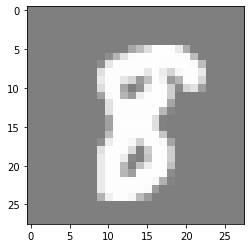

tensor(8)


In [0]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = dataiter.next()
image = images[0]
label = labels[0]

# show images
imshow(torchvision.utils.make_grid(image))
print(label)
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Pyro

In [0]:
!pip install pyro-ppl

     |████████████████████████████████| 501kB 2.8MB/s 
     |████████████████████████████████| 61kB 7.3MB/s 
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


In [0]:
import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [0]:
log_softmax = nn.LogSoftmax(dim=1)

# Define the model pyro

In [0]:
def model(x_data, y_data):
    #define the prior on the W and bias of the first layer ici normal 0,I pour les 2
    fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight)) 
    fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))
    
    #define the prior on the W ans bias of the second layer ici normal 0,I pour les 2 
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight))
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias))
    
    #on fait un dictionnaire avec ces 4 distributions
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,  'out.weight': outw_prior, 'out.bias': outb_prior}
    
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)


    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    #le resultat du regressor
    lhat = log_softmax(lifted_reg_model(x_data))
    #tirer une observation obs depuis les probas générés par le régresseur sampler 
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

# Define the pyro guide

The guide function help us to initialize a well behavied distribution that later we can optimize to approximate the true posterior

L'objectif du guide est de ressortir une variable normale qui approxime bien la fonction donné par le model

On va faire de l'inférence entre ces deux fonctions grace à la KL divergence

In [0]:
softplus = torch.nn.Softplus()

def guide(x_data, y_data):
    
    # First layer weight distribution priors 
    #chaque Wi,j suit une loi normale mui,j sigmai,j mais cette fois avec mui,j et sigmai,j sont
    #tirés aléatoirement depuis une normale 0,1
    fc1w_mu = torch.randn_like(net.fc1.weight) #on dis que le mu W est un vectreur de la bonne taillle
    fc1w_sigma = torch.randn_like(net.fc1.weight) #on dit que le mu sigma est un vecteur de la bonne taille
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu) #on défini le parametre Wmu du premier layer
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma)) #et le sigma
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param) #et on definit la loi priors de W
    # First layer bias distribution priors  
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(1)
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)

    #on met toutes nos priors dans un dictionnaire
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'out.weight': outw_prior, 'out.bias': outb_prior}
    

    #lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
   
    
    return lifted_module()

#Optimization


In [0]:
optim = Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO()) #variationnal inference using elbo

In [0]:
#Optimisation loop
num_iterations = 5
loss = 0

for j in range(num_iterations):
    loss = 0
    #data = (images,label) pairs
    #on fait l'inférence petit batch par petit batch à la fois
    for batch_id, data in enumerate(train_loader):
        # calculate the loss and take a gradient step
        loss += svi.step(data[0].view(-1,28*28), data[1])
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = loss / normalizer_train
    
    print("Epoch ", j, " Loss ", total_epoch_loss_train)

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


Epoch  0  Loss  2048.9952739423115
Epoch  1  Loss  348.75494833868345
Epoch  2  Loss  152.0304737305482
Epoch  3  Loss  108.37269184263548
Epoch  4  Loss  95.43336671277682


#Prédictions sans prendre en compte l'uncertainty

In [0]:
num_samples = 10
def predict(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]  #on tire plusieurs variables 10 fois pour chaque layer
    yhats = [model(x).data for model in sampled_models] #Pour chacun de ces models
    #On calcul l'output et on le store dans yhats
    mean = torch.mean(torch.stack(yhats), 0) #on calcul la moyenne de ses yhats
    return np.argmax(mean.numpy(), axis=1) #et on dit que l'approximation est l'argmax

In [0]:
from tqdm import tqdm

In [0]:
print('Prediction when network is forced to predict')
correct = 0
total = 0
for j, data in tqdm(enumerate(test_loader)):
    images, labels = data
    predicted = predict(images.view(-1,28*28))
    total += labels.size(0) #128 = la taille du batch
    correct += (np.array(predicted) == np.array(labels)).sum().item()
print("accuracy: %d %%" % (100 * correct / total))

0it [00:00, ?it/s]

Prediction when network is forced to predict


/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)
79it [00:47,  1.69it/s]

accuracy: 89 %


#Prédiction en prenant en compte l'uncertainty

In [0]:
classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')


In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    #plt.imshow(npimg,  cmap='gray')
    #fig.show(figsize=(1,1))
    
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.imshow(npimg,  cmap='gray', interpolation='nearest')
    plt.show()

In [0]:
num_samples = 100 #on va créer 100 models
def give_uncertainities(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [F.log_softmax(model(x.view(-1,28*28)).data, 1).detach().numpy() for model in sampled_models]
    #on return la liste des log_softmax sur l'input des 100 models
    return np.asarray(yhats)

In [0]:
def test_batch(images, labels, plot=True):
    y = give_uncertainities(images) #retournes les differentes log softmax 
    #des predictions faites pas les 100 reseaux
    predicted_for_images = 0 #le nombre de predictions faits
    correct_predictions=0 #le nombre de predictions correctes 

    for i in range(len(labels)): #pour chaque images
    
        if(plot): #Si on veut ploter
            print("Real: ",labels[i].item()) #on affiche le vrai label
            fig, axs = plt.subplots(1, 10, sharey=True,figsize=(20,2)) #et on prepare le plot
    
        all_digits_prob = [] #les proba medianes ( parmis nos 100 probas ) que l'image i soit dans
        #chacune des classe d'indice de la liste
    
        highted_something = False #highted si on pense avoir une réponse
    
        for j in range(len(classes)): #pour chacune des classes
        
            highlight=False #on initialise le surlignage a false
        
            histo = [] #on initialise notre histogram
            histo_exp = [] #et notre histogramme_exp
        
            for z in range(y.shape[0]): #pour chacun de nos reseaux
                histo.append(y[z][i][j])#on ajoute dans histo le log softmax de notre réseau que 
                histo_exp.append(np.exp(y[z][i][j])) #et exp de cette valeure dans histo_exp donc juste le softmax
                #ie la proba que l'image i soit dans la classe j d'apres le reseau z
            
            #au final a ce moment la dans histo_exp, on a les probabilités pour chacun de nos reseaux que l'image
            #i soit dans la classe j

            prob = np.percentile(histo_exp, 50) #on chope la probabilité médiane
        
            if(prob>0.2): #si cette probabilité médiane est supérieure à 20 pourcent
                highlight = True #on active le surlignage
        
            all_digits_prob.append(prob) #et on ajoute cette proba à la liste
            
            if(plot): # si on veut ploter
            
                N, bins, patches = axs[j].hist(histo, bins=8, color = "lightgray", lw=0,  weights=np.ones(len(histo)) / len(histo), density=False)
                axs[j].set_title(str(j)+" ("+str(round(prob,2))+")")  #on plot l'histogramme
        
            if(highlight): #si on a décidé de surligner
            
                highted_something = True #highted something passe a true
                
                if(plot): #et si on veut ploter

                    # We'll color code by height, but you could use any scalar
                    fracs = N / N.max()

                    # we need to normalize the data to 0..1 for the full range of the colormap
                    norm = colors.Normalize(fracs.min(), fracs.max())

                    # Now, we'll loop through our objects and set the color of each accordingly
                    for thisfrac, thispatch in zip(fracs, patches):
                        color = plt.cm.viridis(norm(thisfrac))
                        thispatch.set_facecolor(color)

        #on a fini de process l'image i 
        if(plot): #donc on fait le plot
            plt.show()
    
        predicted = np.argmax(all_digits_prob) #la valeur prédites est celle qui a la plus grande proba
    
        if(highted_something): #si on a décidé a un moment de highted something
            predicted_for_images+=1 #on ajoute un aux nombres d'images predites
            if(labels[i].item()==predicted): # si la prediction est correcte, on ajoute un au nombre d'immages bien prédites
                if(plot):
                    print("Correct")
                correct_predictions +=1.0
            else:
                if(plot):
                    print("Incorrect :()")
        else:
            if(plot):
                print("Undecided.")
        
        if(plot): #on affiche l'image
            imshow(images[i].squeeze())
        
    
    if(plot):
        print("Summary")
        print("Total images: ",len(labels))
        print("Predicted for: ",predicted_for_images)
        print("Accuracy when predicted: ",correct_predictions/predicted_for_images)
        
    return len(labels), correct_predictions, predicted_for_images

Prediction when network can refuse


/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


Real:  7


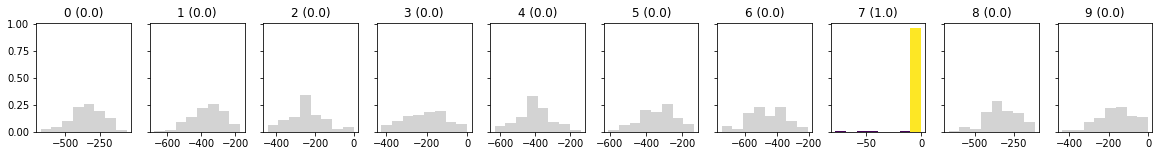

Correct


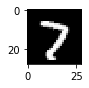

Real:  6


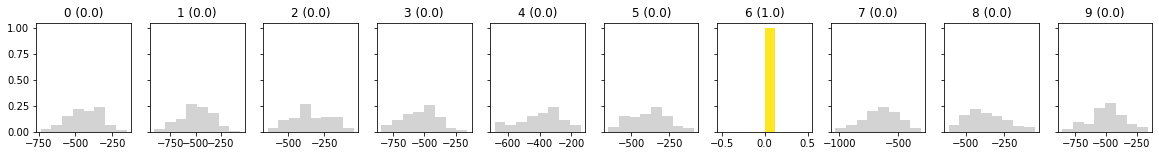

Correct


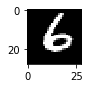

Real:  0


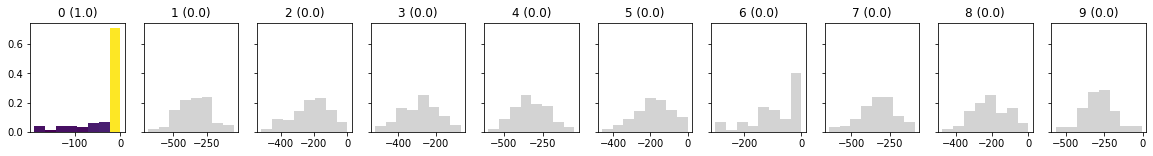

Correct


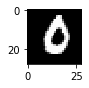

Real:  5


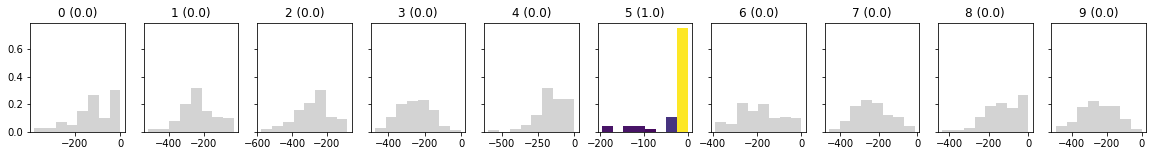

Correct


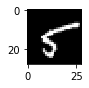

Real:  2


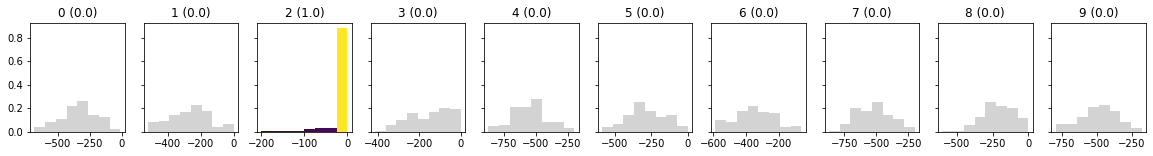

Correct


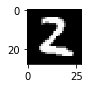

Real:  0


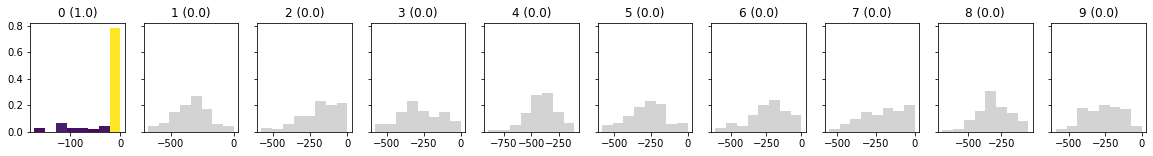

Correct


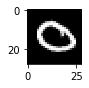

Real:  1


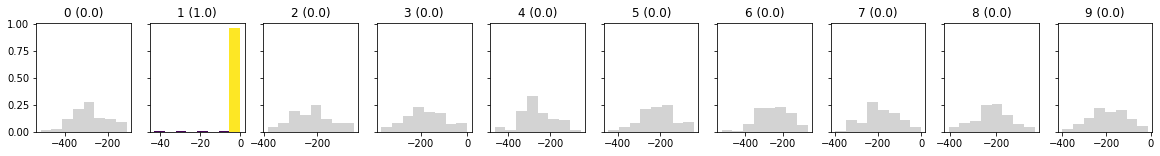

Correct


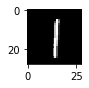

Real:  2


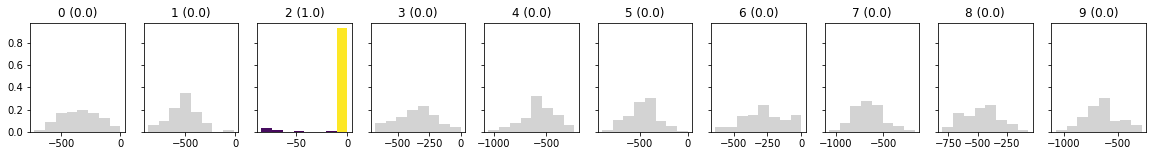

Correct


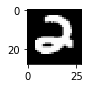

Real:  2


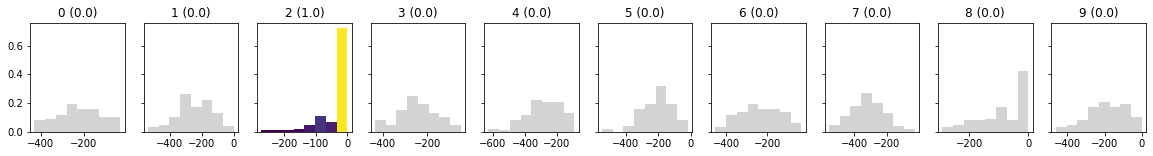

Correct


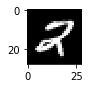

Real:  8


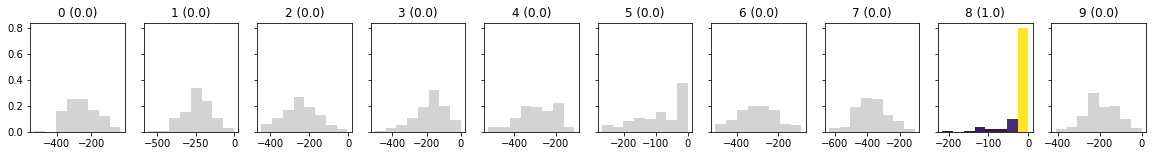

Correct


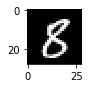

Real:  6


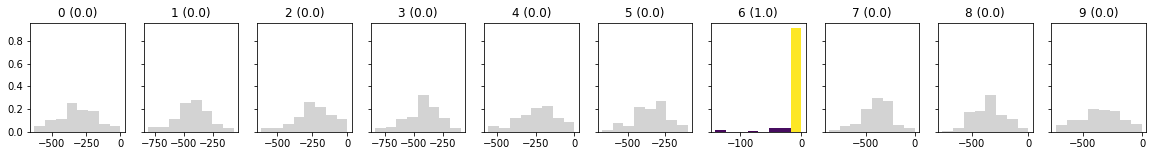

Correct


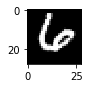

Real:  6


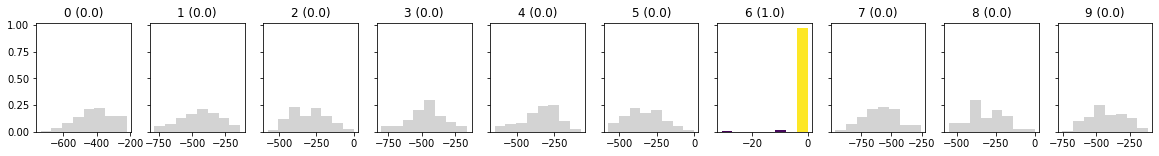

Correct


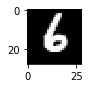

Real:  5


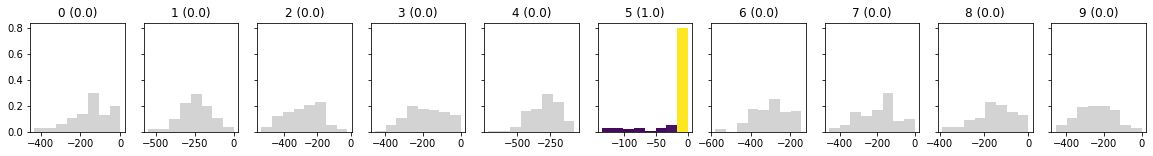

Correct


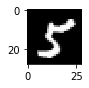

Real:  1


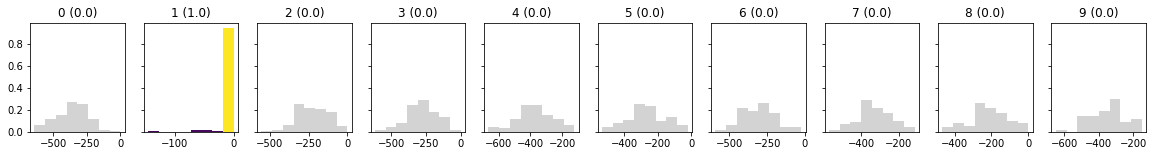

Correct


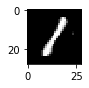

Real:  3


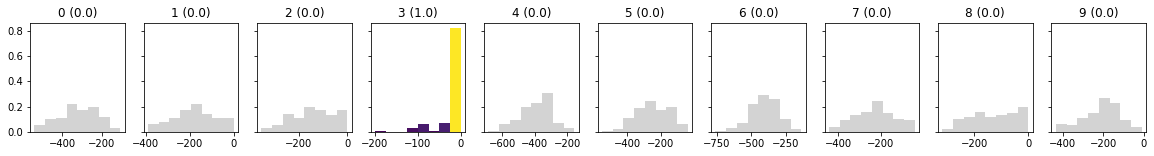

Correct


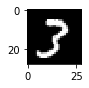

Real:  9


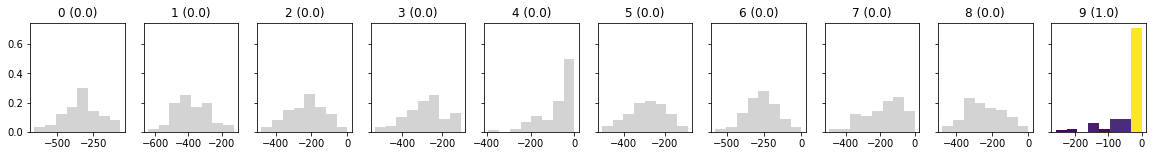

Correct


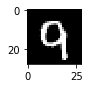

Real:  2


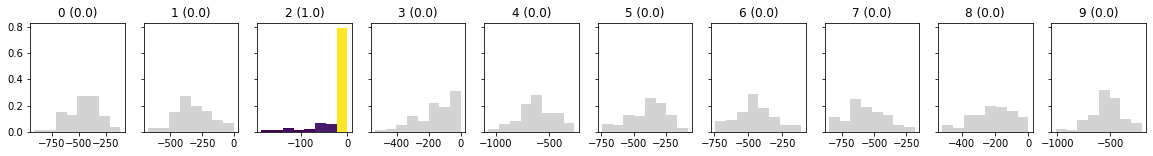

Correct


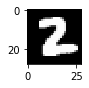

Real:  2


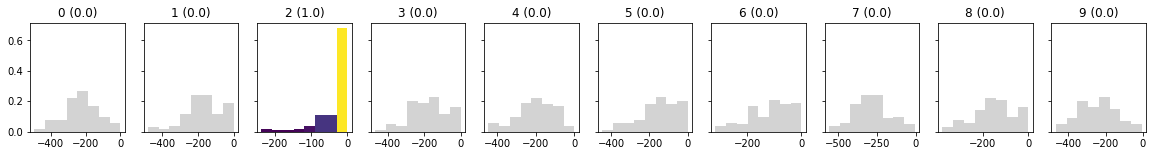

Correct


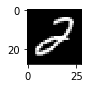

Real:  8


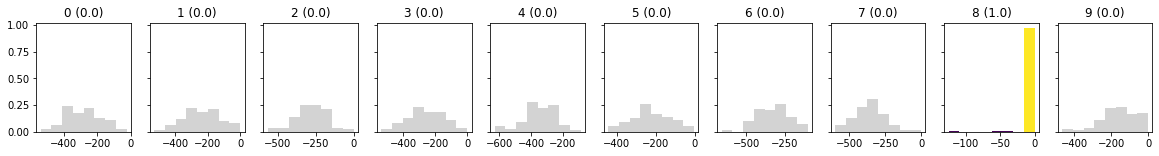

Correct


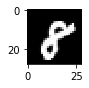

Real:  7


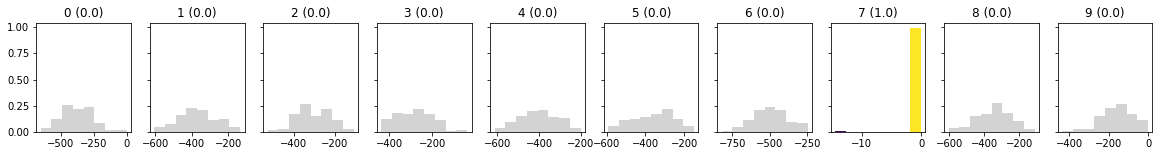

Correct


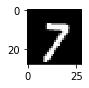

Real:  3


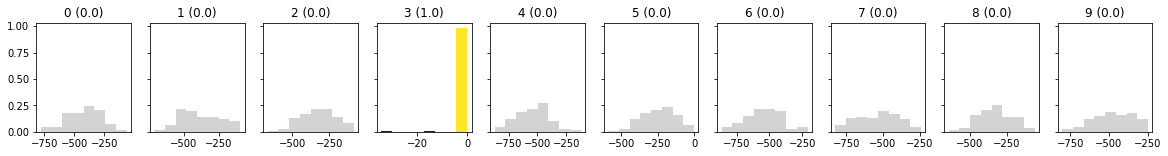

Correct


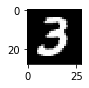

Real:  7


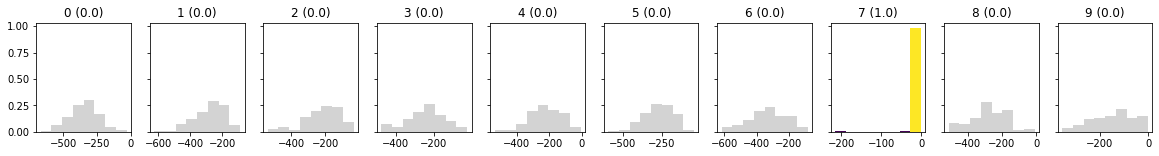

Correct


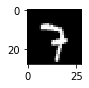

Real:  0


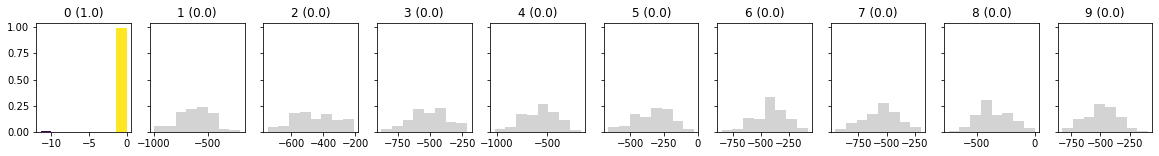

Correct


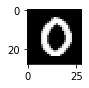

Real:  7


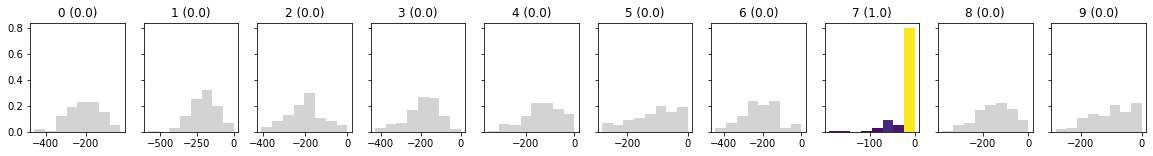

Correct


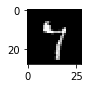

Real:  6


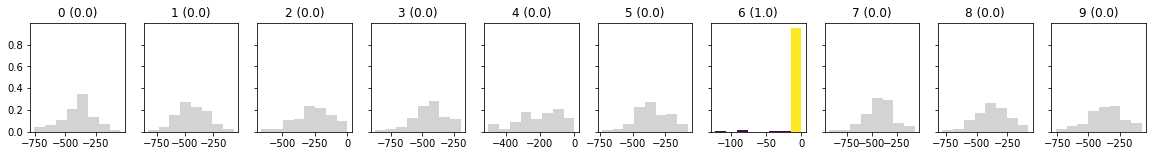

Correct


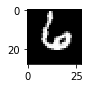

Real:  0


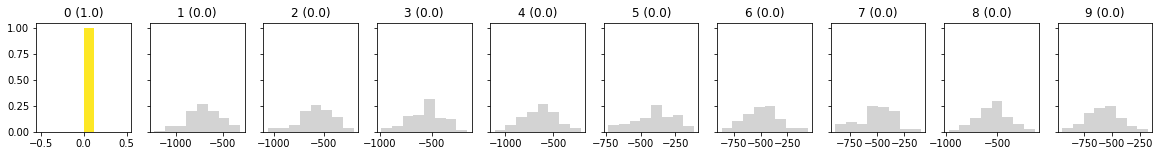

Correct


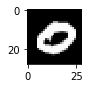

Real:  1


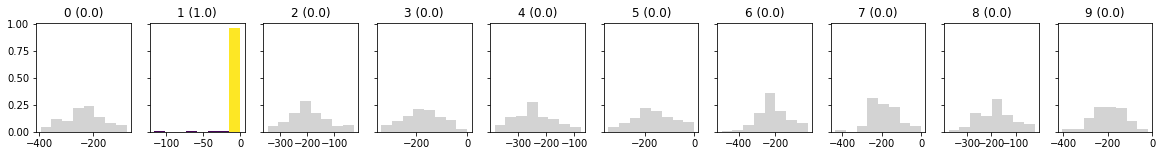

Correct


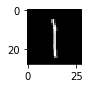

Real:  0


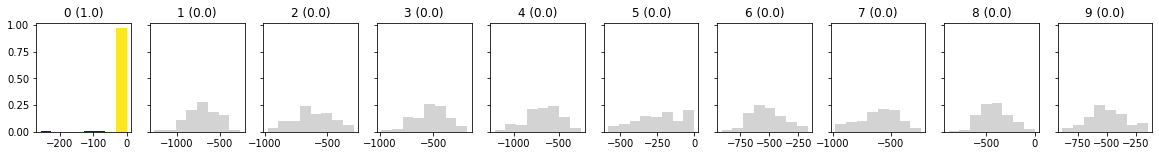

Correct


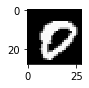

Real:  8


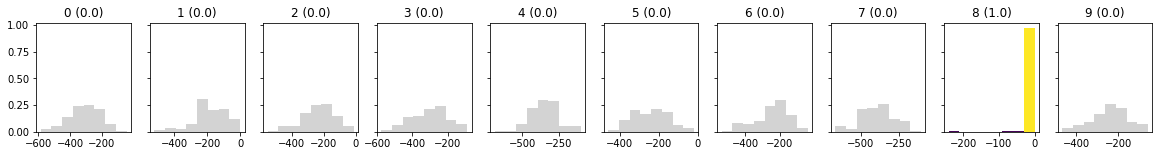

Correct


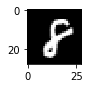

Real:  9


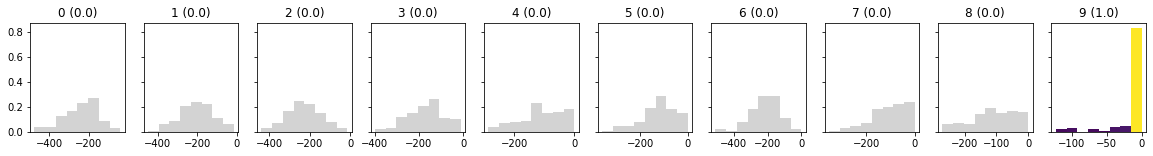

Correct


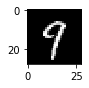

Real:  8


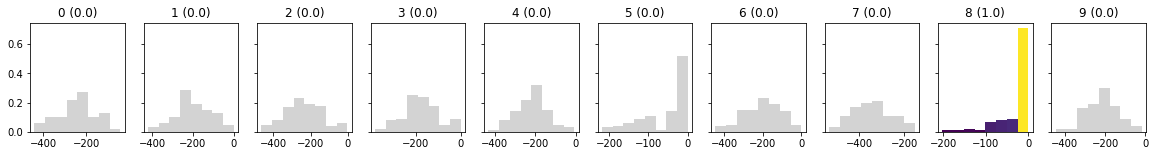

Correct


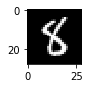

Real:  6


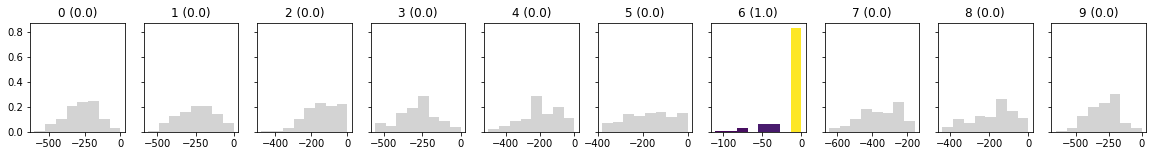

Correct


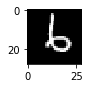

Real:  2


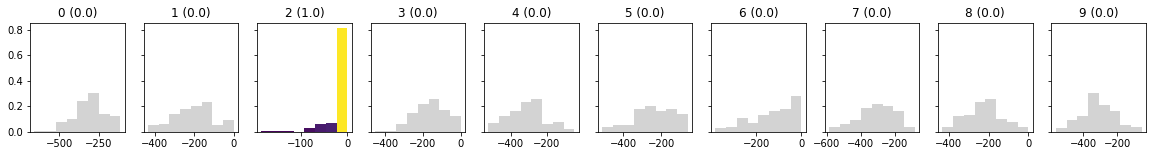

Correct


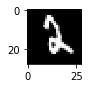

Real:  9


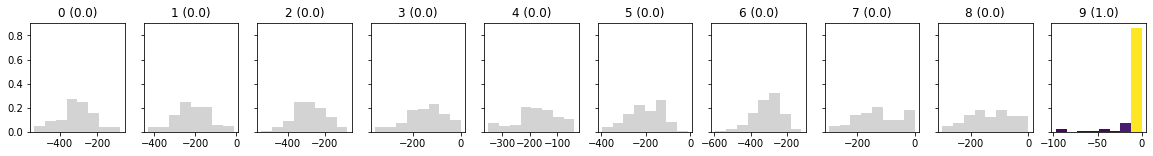

Correct


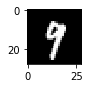

Real:  2


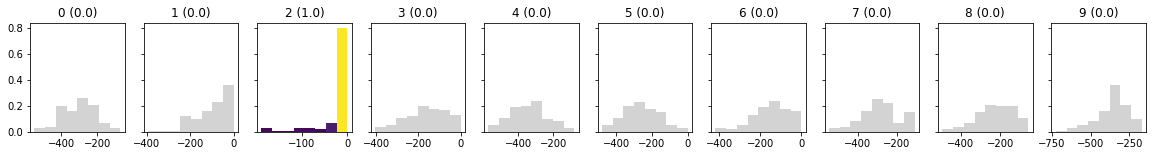

Correct


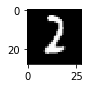

Real:  2


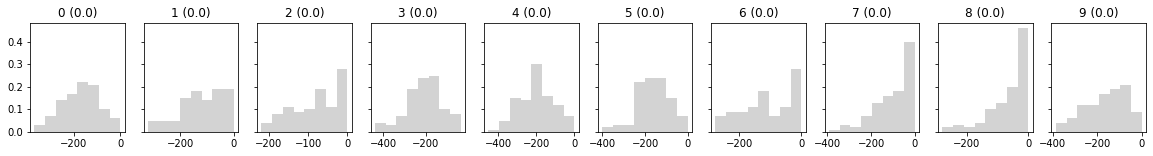

Undecided.


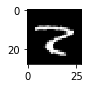

Real:  9


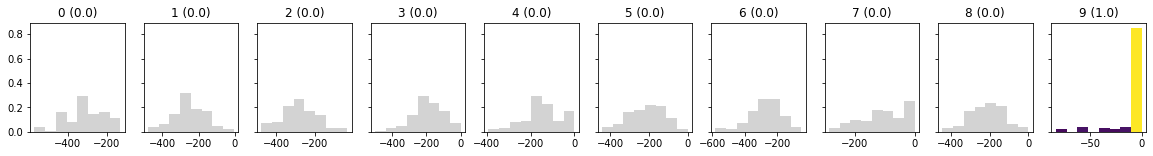

Correct


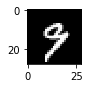

Real:  9


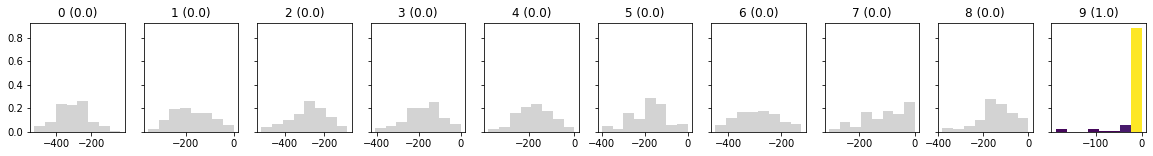

Correct


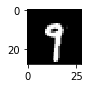

Real:  1


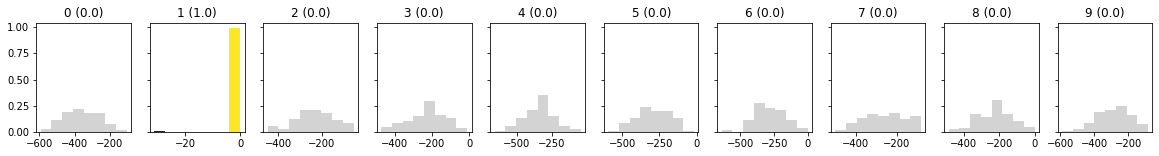

Correct


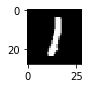

Real:  6


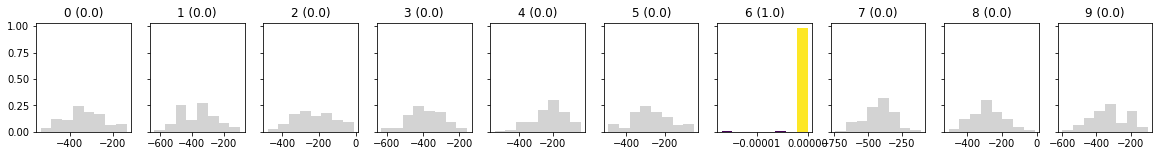

Correct


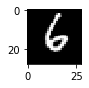

Real:  9


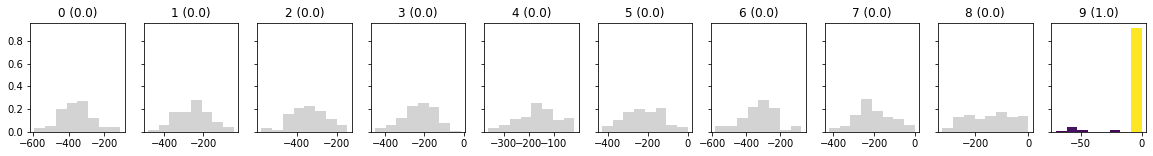

Correct


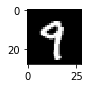

Real:  8


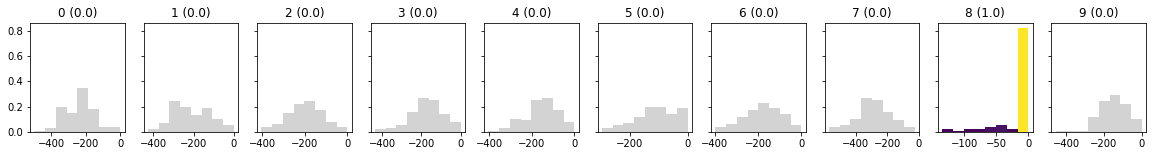

Correct


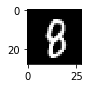

Real:  6


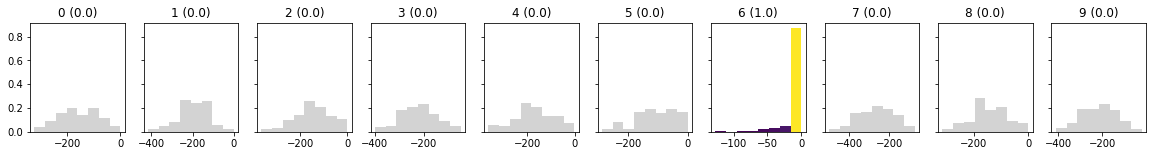

Correct


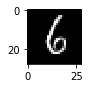

Real:  4


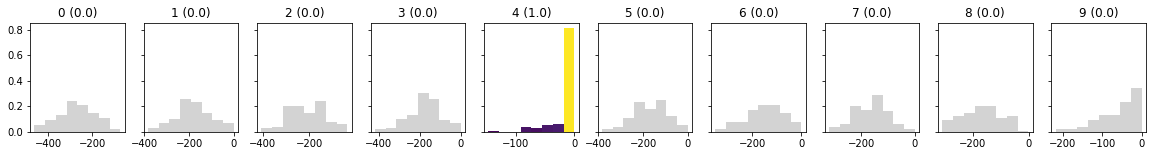

Correct


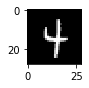

Real:  6


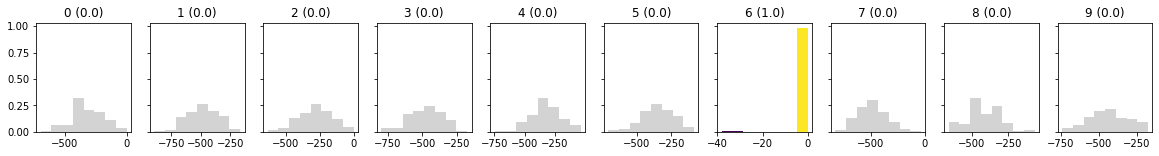

Correct


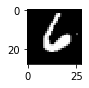

Real:  4


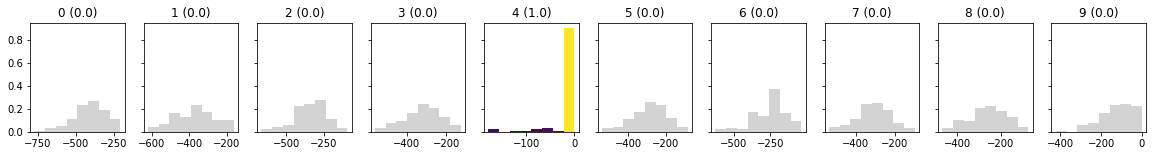

Correct


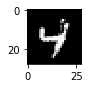

Real:  7


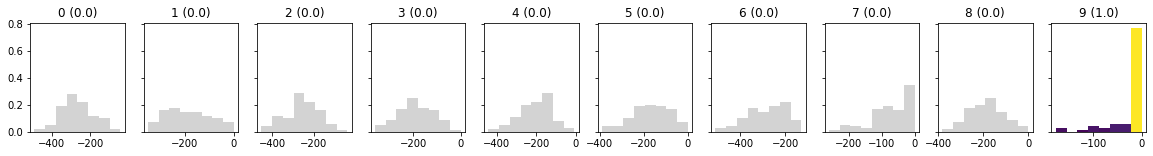

Incorrect :()


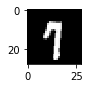

Real:  3


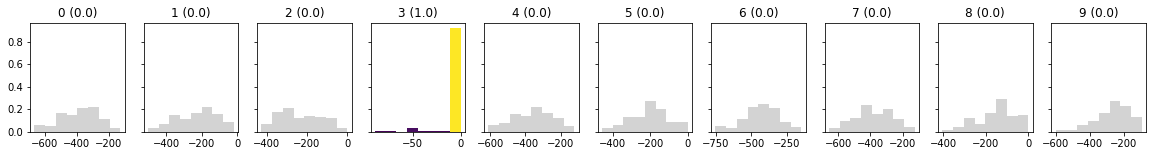

Correct


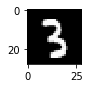

Real:  5


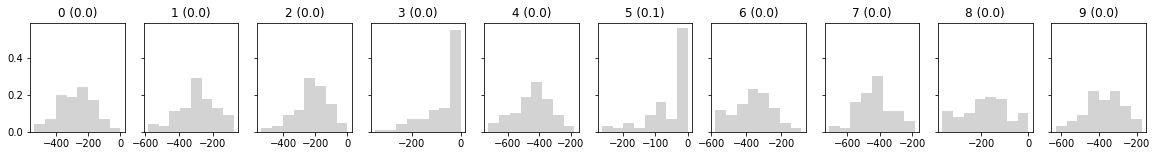

Undecided.


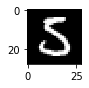

Real:  5


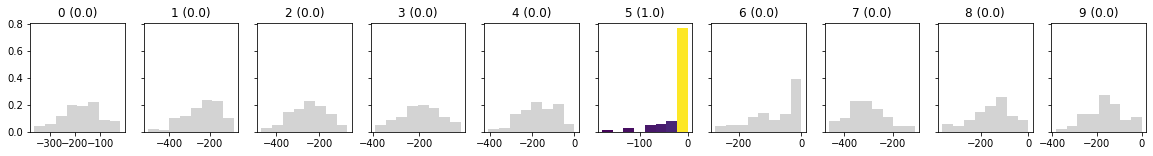

Correct


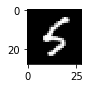

Real:  1


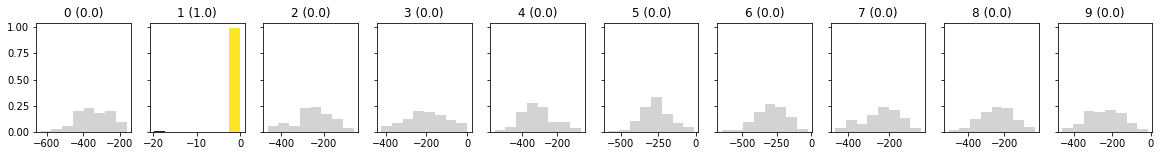

Correct


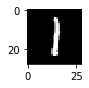

Real:  5


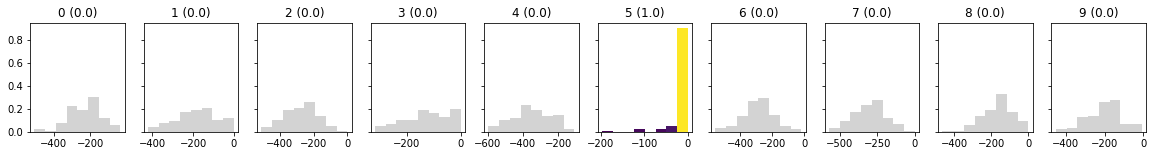

Correct


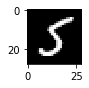

Real:  4


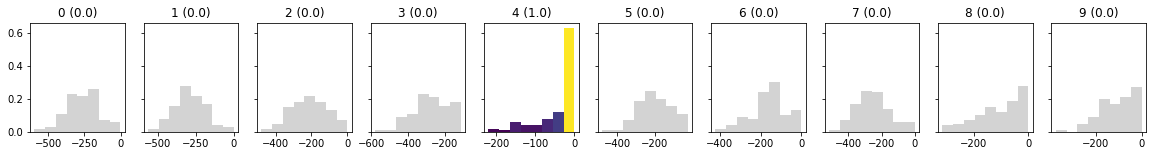

Correct


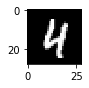

Real:  4


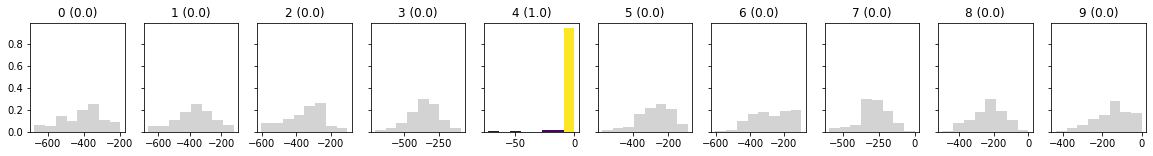

Correct


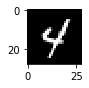

Real:  4


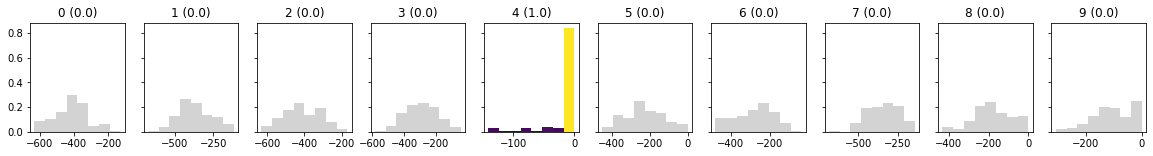

Correct


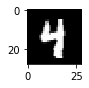

Real:  2


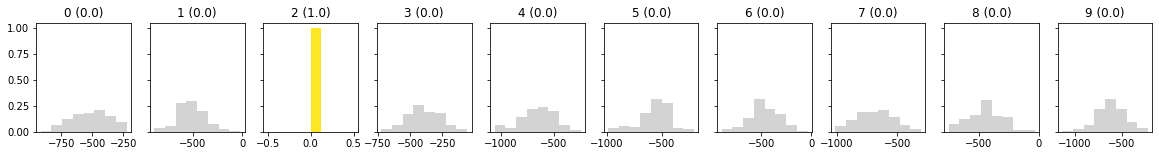

Correct


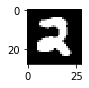

Real:  3


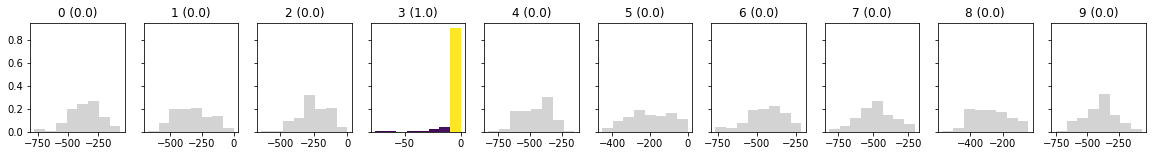

Correct


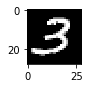

Real:  3


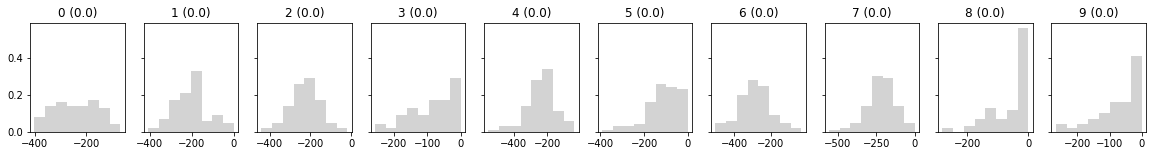

Undecided.


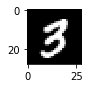

Real:  8


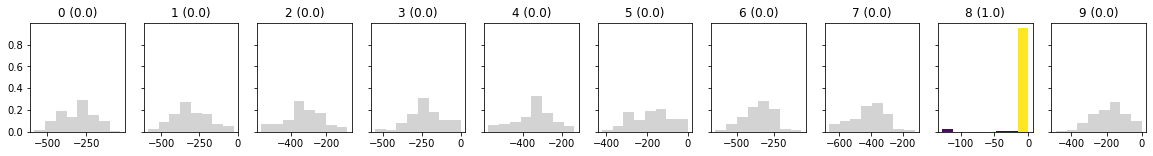

Correct


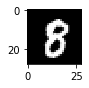

Real:  1


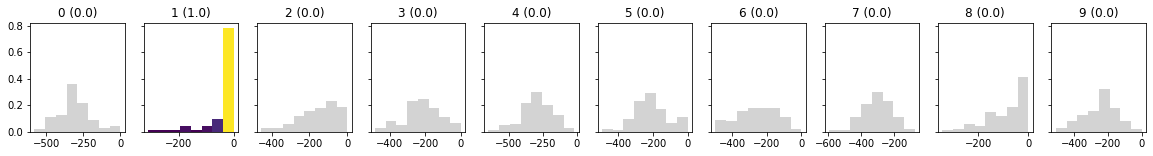

Correct


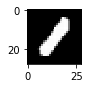

Real:  5


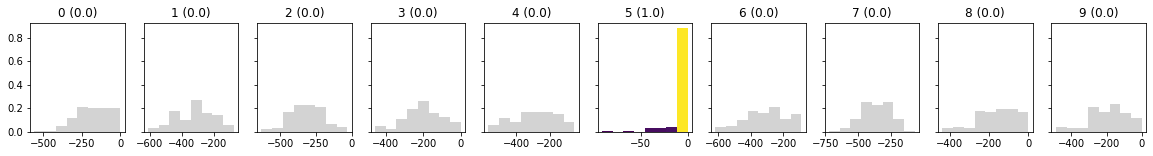

Correct


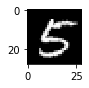

Real:  3


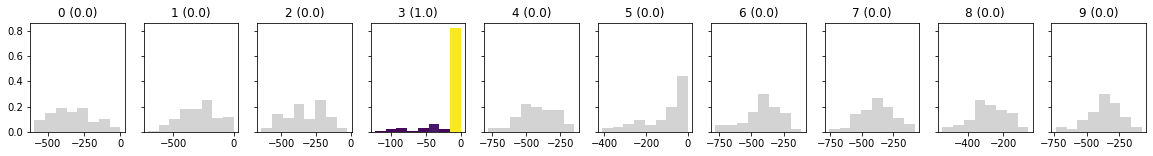

Correct


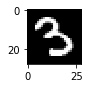

Real:  0


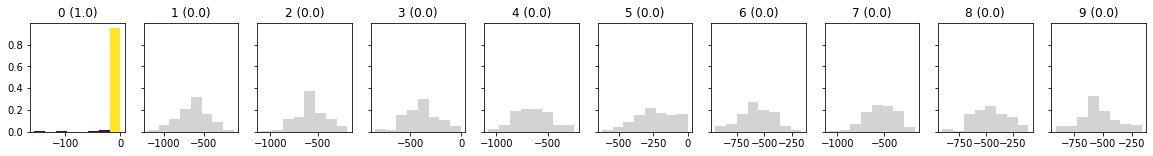

Correct


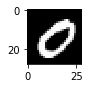

Real:  8


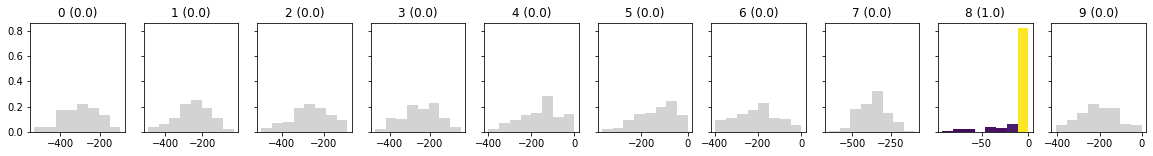

Correct


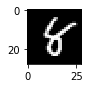

Real:  2


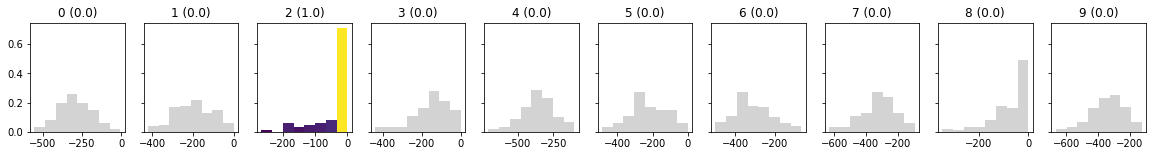

Correct


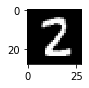

Real:  8


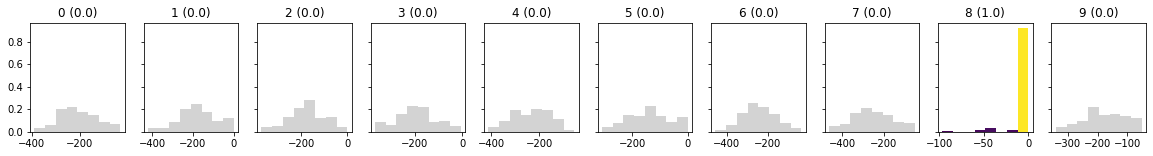

Correct


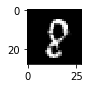

Real:  3


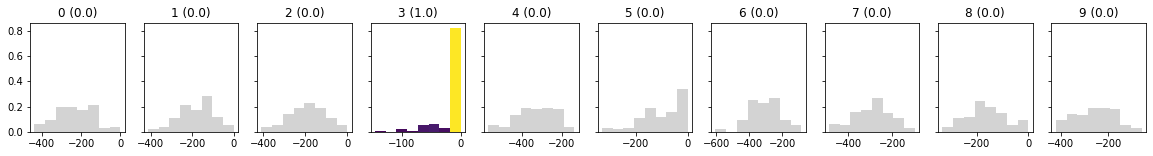

Correct


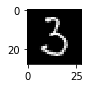

Real:  3


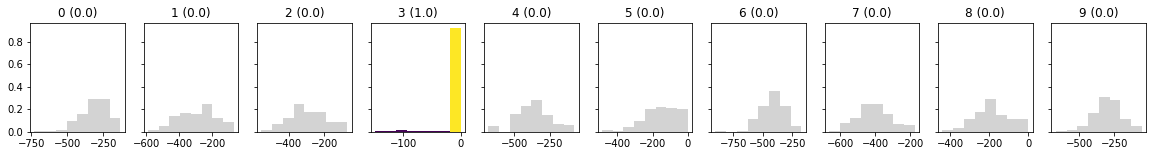

Correct


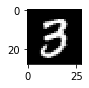

Real:  5


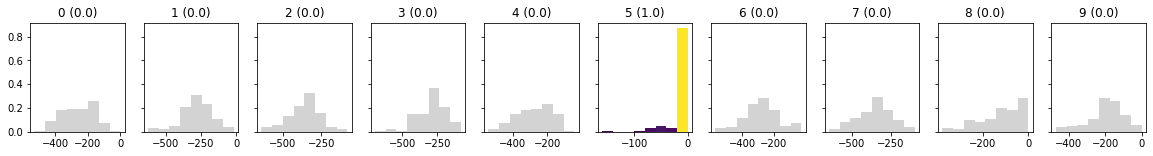

Correct


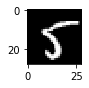

Real:  1


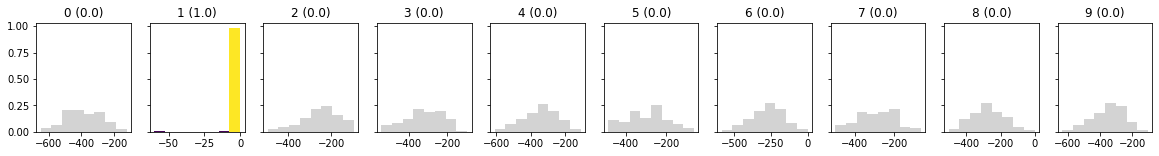

Correct


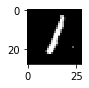

Real:  1


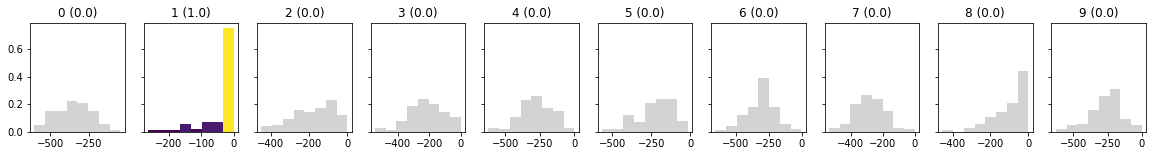

Correct


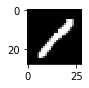

Real:  9


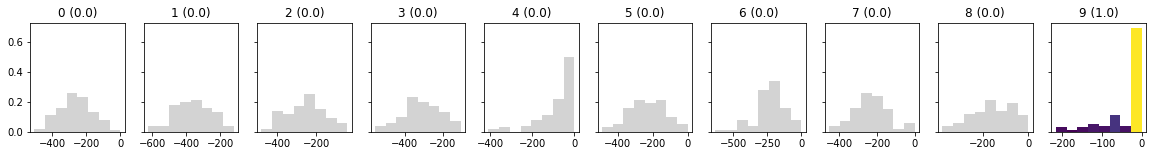

Correct


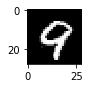

Real:  1


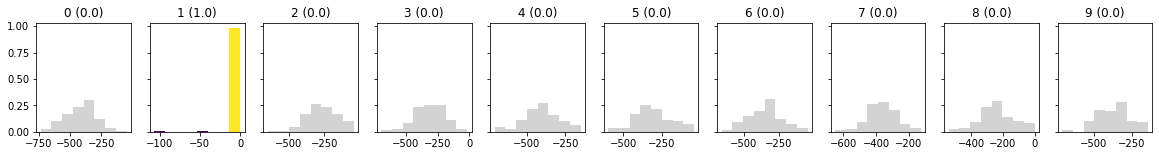

Correct


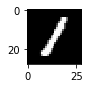

Real:  3


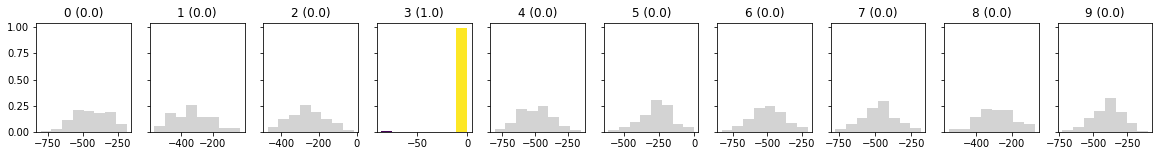

Correct


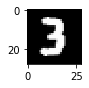

Real:  3


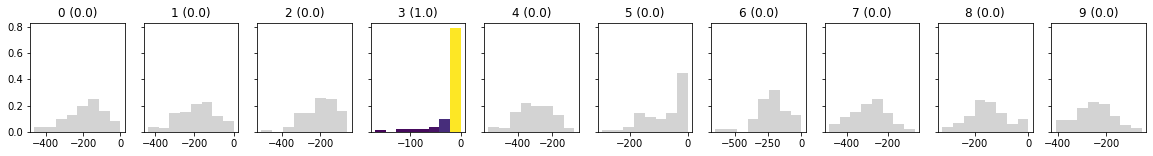

Correct


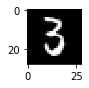

Real:  8


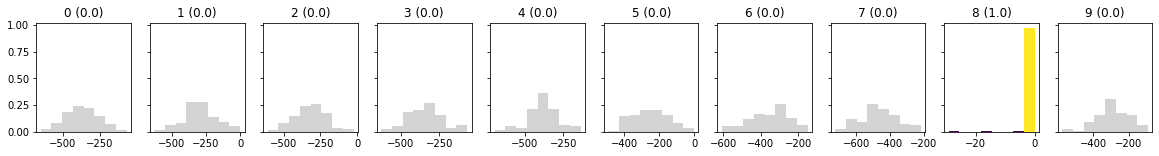

Correct


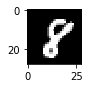

Real:  0


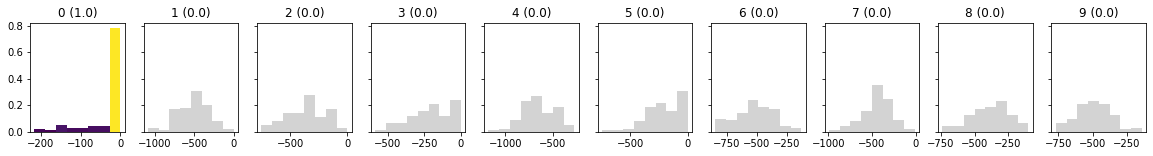

Correct


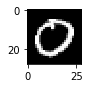

Real:  8


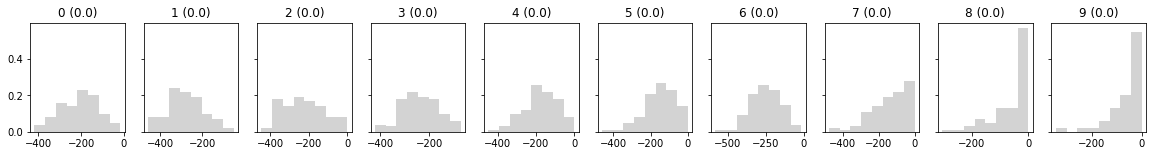

Undecided.


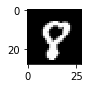

Real:  2


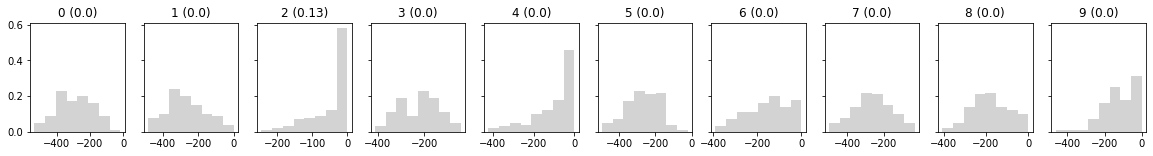

Undecided.


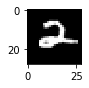

Real:  0


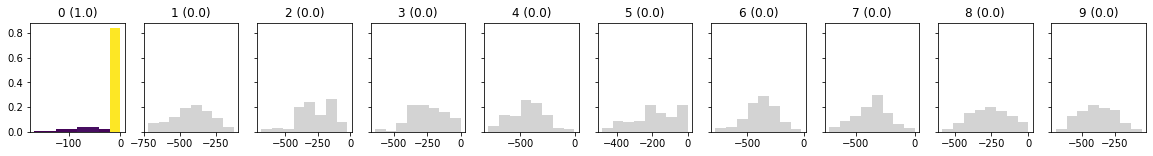

Correct


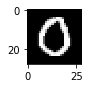

Real:  4


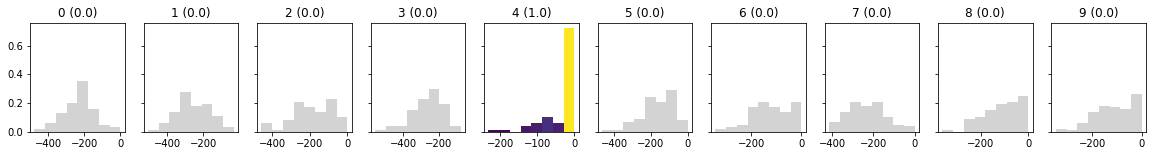

Correct


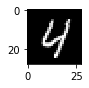

Real:  1


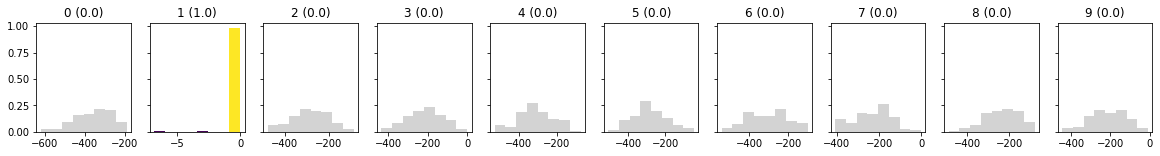

Correct


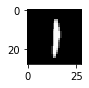

Real:  0


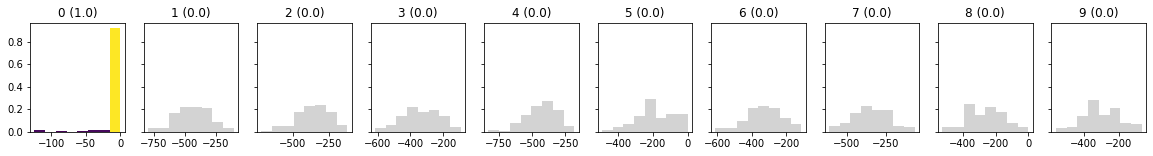

Correct


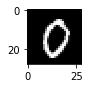

Real:  9


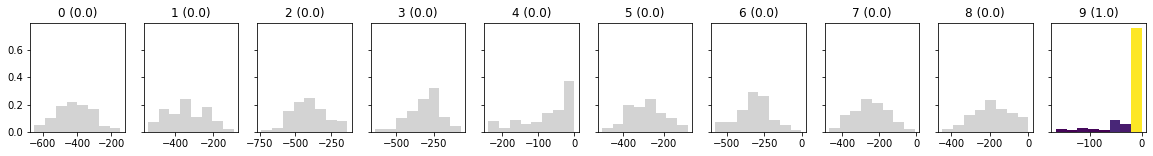

Correct


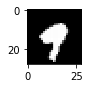

Real:  4


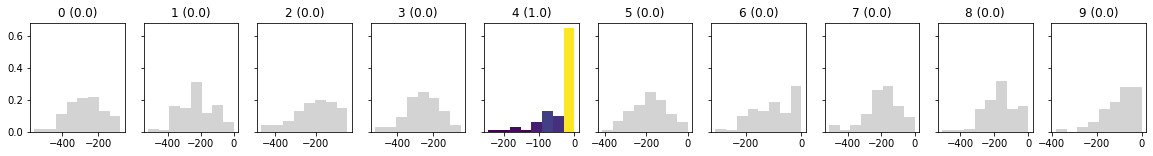

Correct


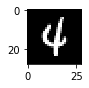

Real:  7


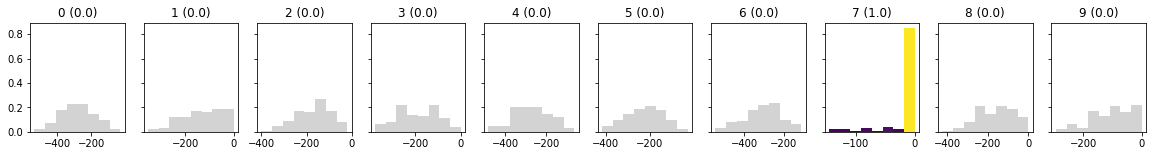

Correct


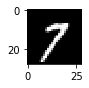

Real:  8


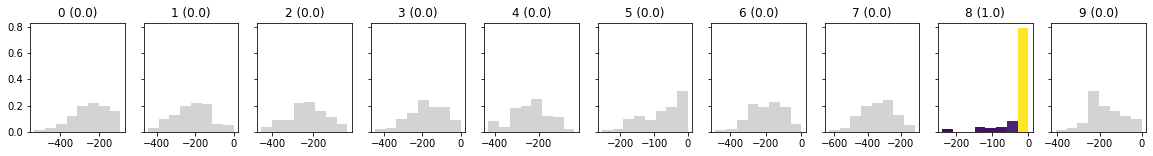

Correct


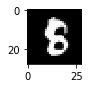

Real:  6


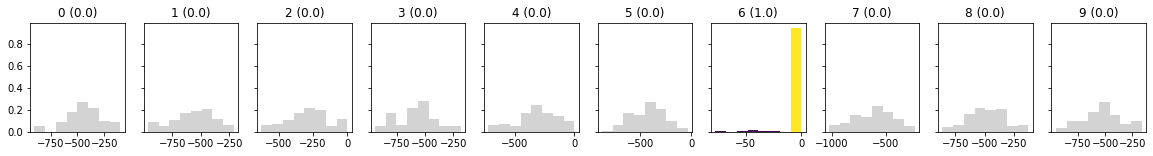

Correct


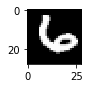

Real:  0


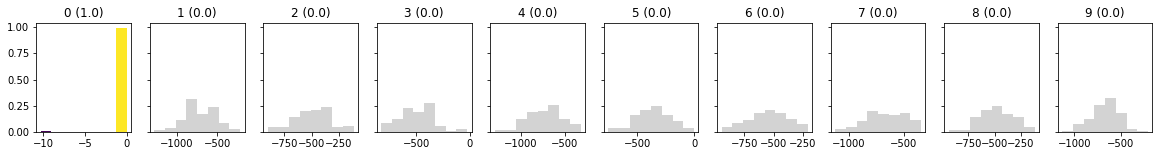

Correct


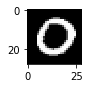

Real:  5


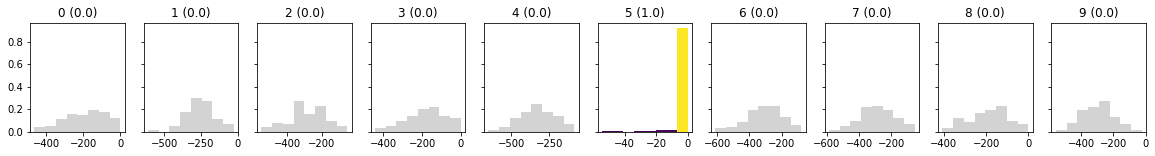

Correct


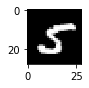

Real:  1


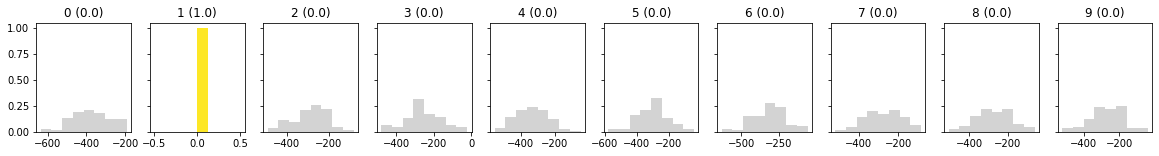

Correct


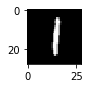

Real:  8


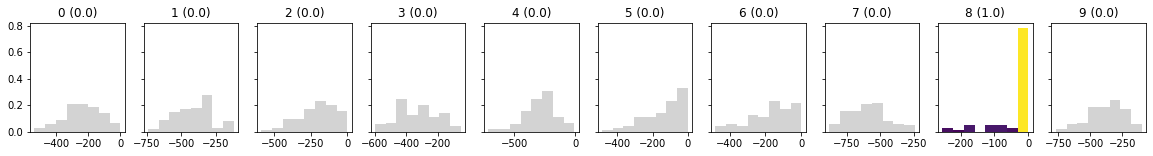

Correct


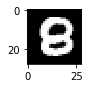

Real:  0


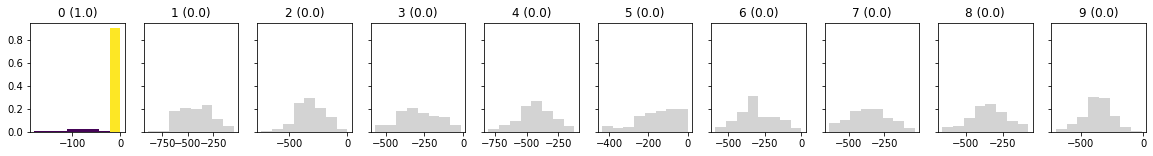

Correct


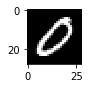

Real:  1


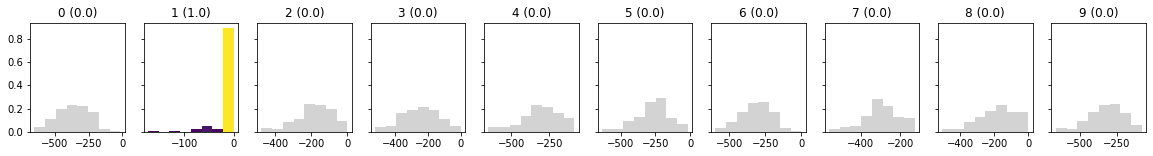

Correct


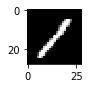

Real:  5


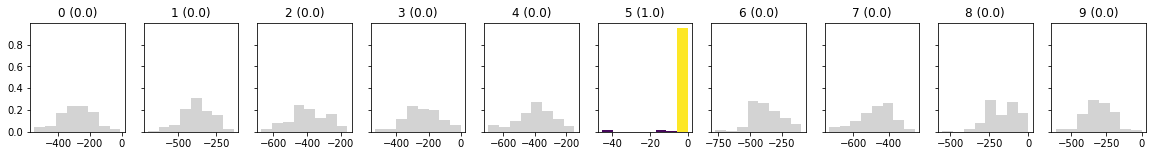

Correct


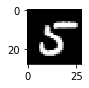

Real:  0


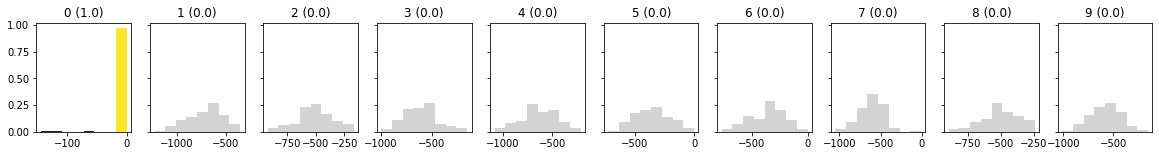

Correct


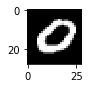

Real:  2


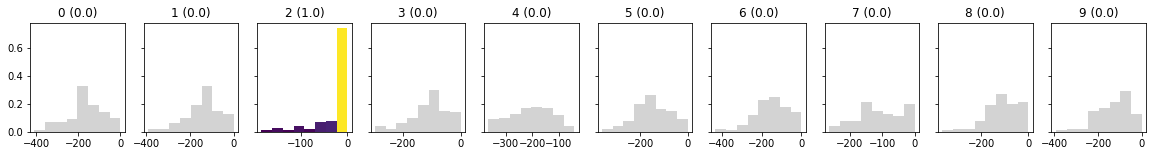

Correct


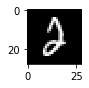

Real:  6


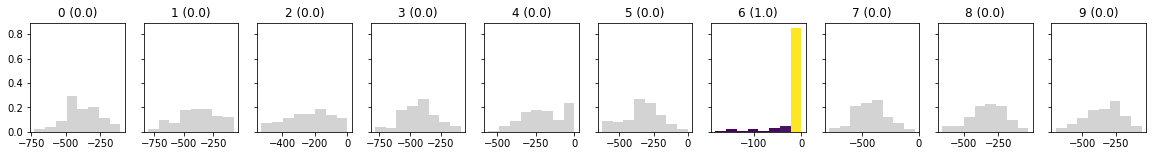

Correct


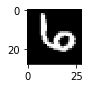

Real:  6


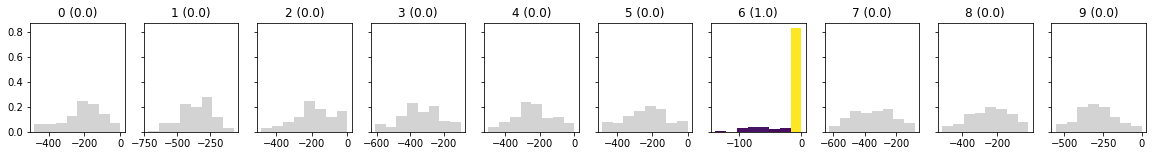

Correct


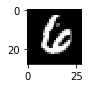

Real:  7


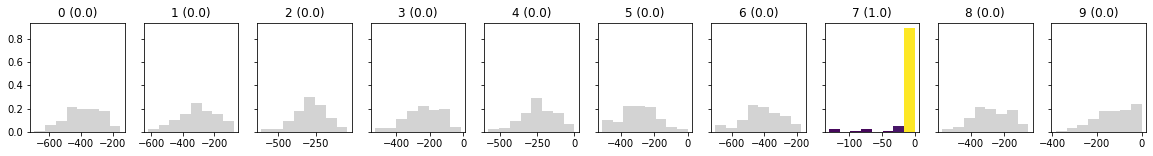

Correct


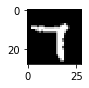

Real:  6


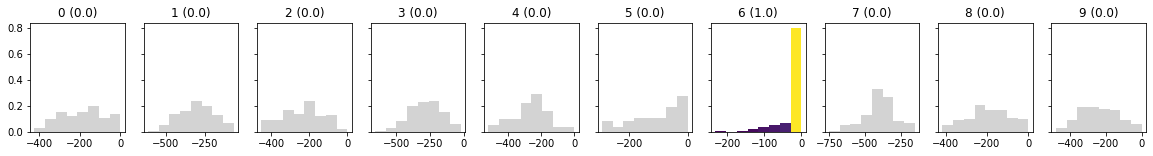

Correct


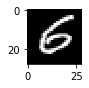

Real:  2


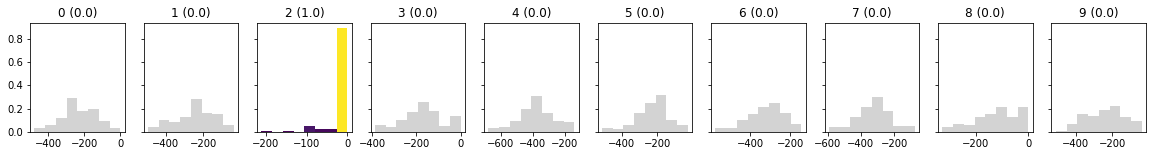

Correct


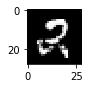

Real:  6


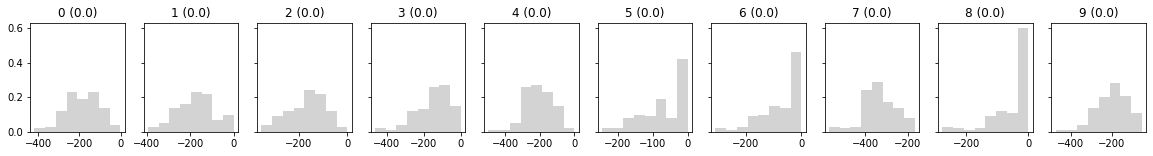

Undecided.


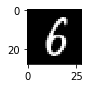

Real:  0


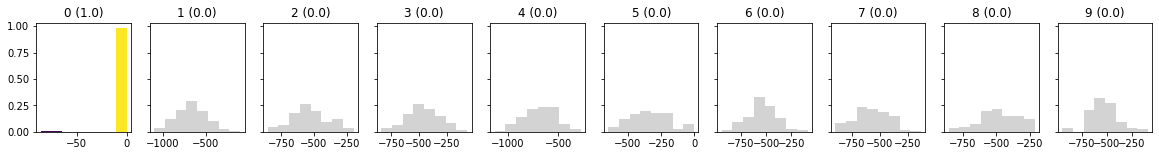

Correct


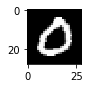

Real:  1


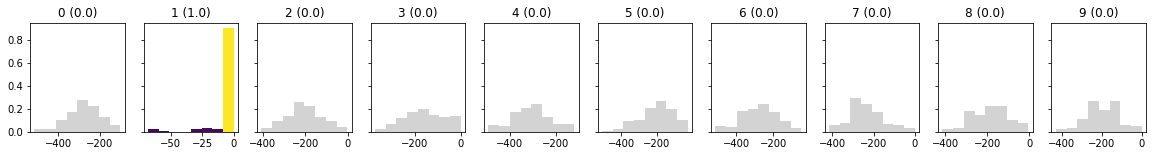

Correct


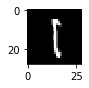

Real:  2


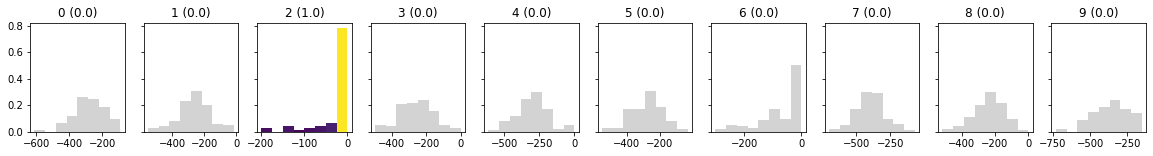

Correct


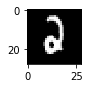

Real:  2


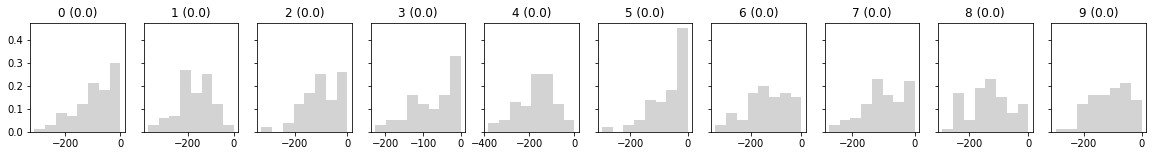

Undecided.


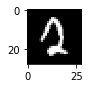

Real:  1


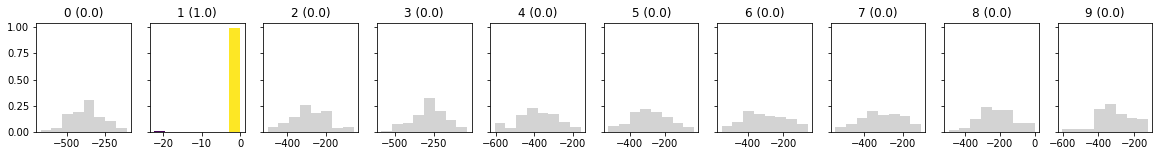

Correct


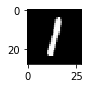

Real:  2


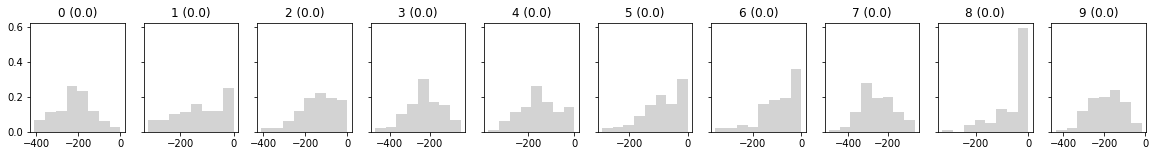

Undecided.


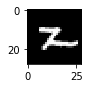

Real:  0


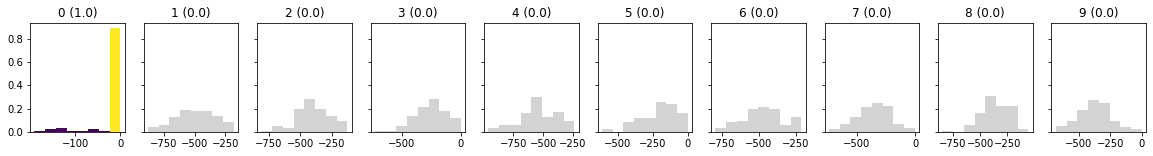

Correct


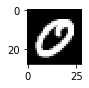

Real:  1


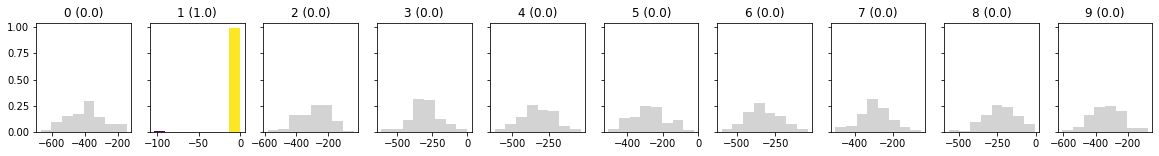

Correct


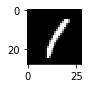

Real:  3


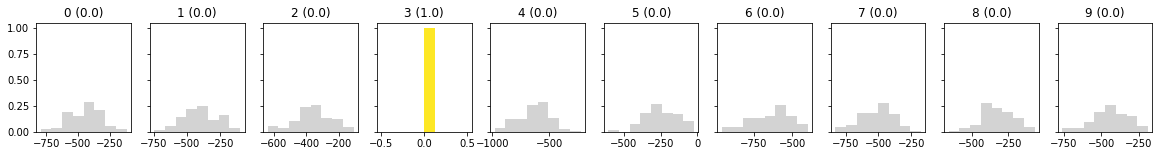

Correct


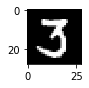

Real:  2


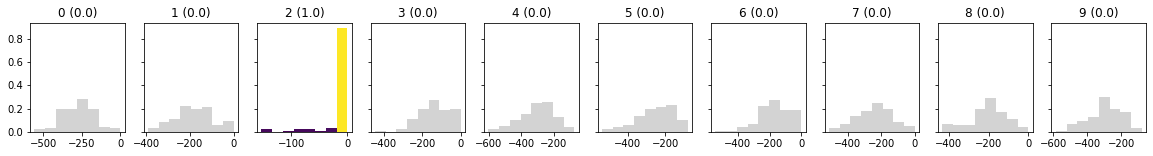

Correct


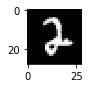

Real:  3


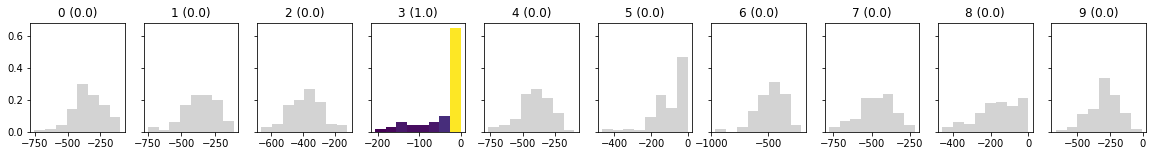

Correct


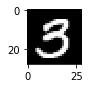

Real:  6


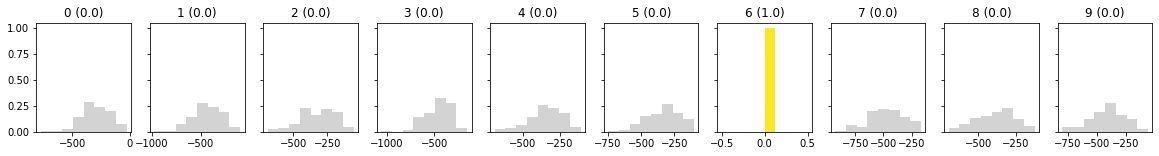

Correct


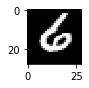

Real:  2


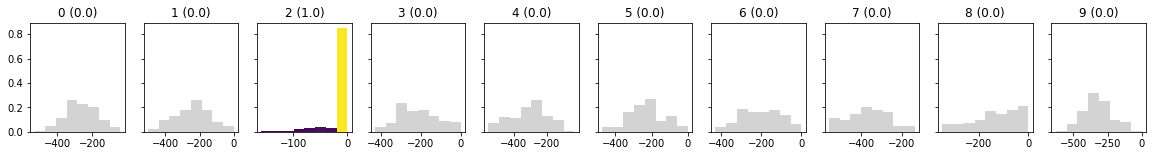

Correct


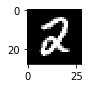

Real:  0


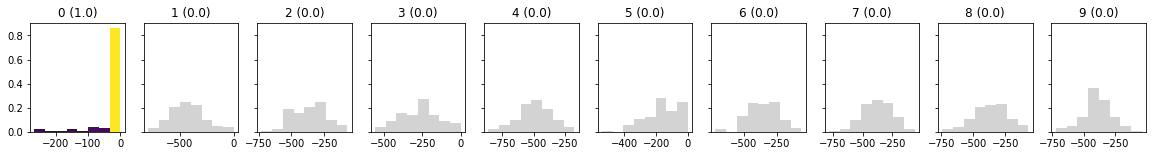

Correct


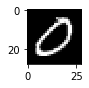

Real:  7


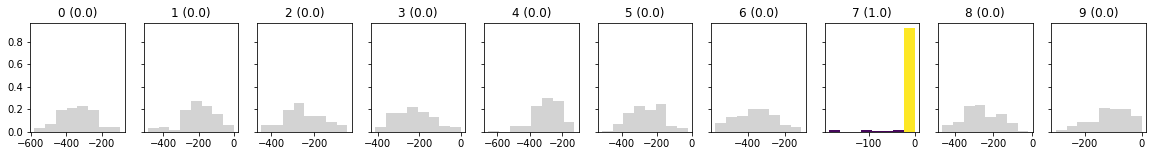

Correct


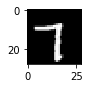

Real:  4


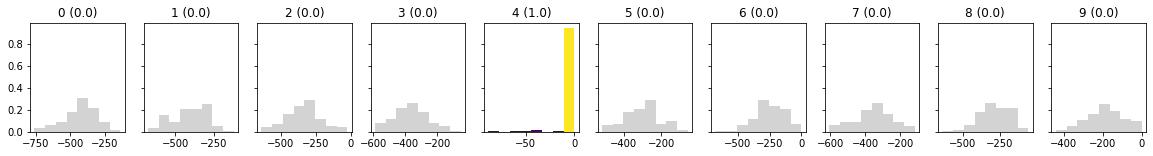

Correct


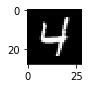

Real:  9


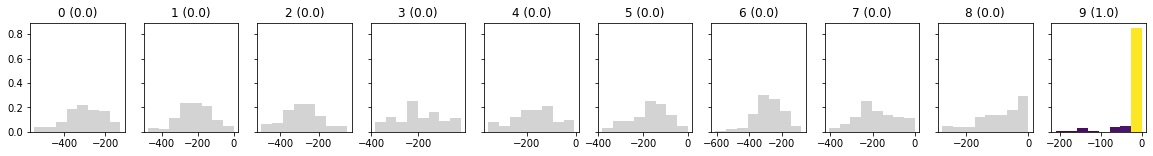

Correct


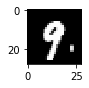

Real:  3


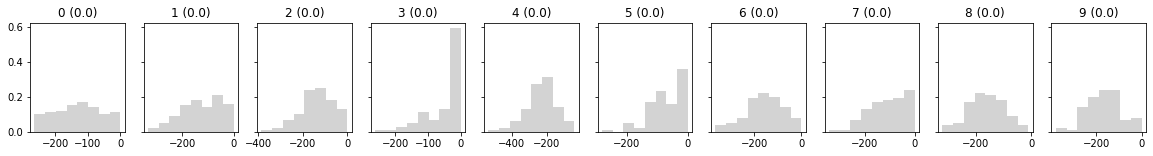

Undecided.


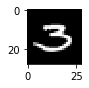

Real:  7


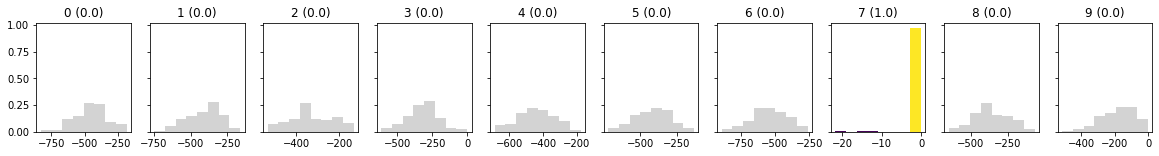

Correct


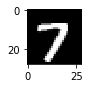

Real:  3


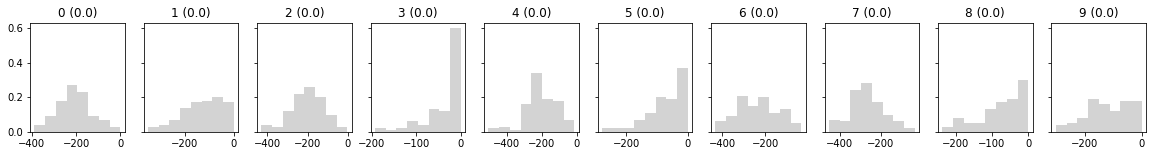

Undecided.


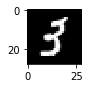

Real:  0


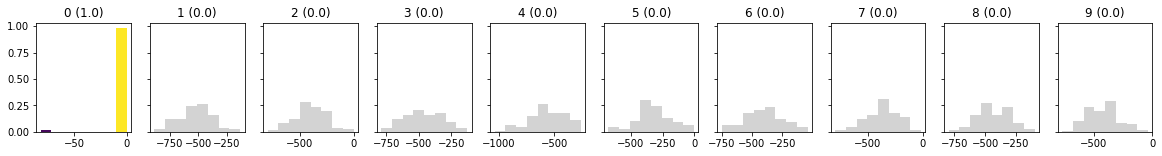

Correct


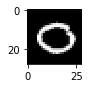

Real:  5


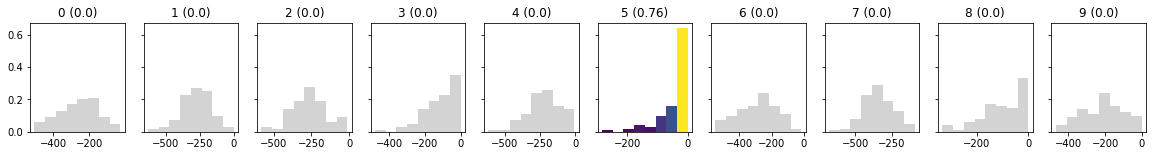

Correct


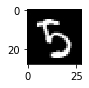

Real:  8


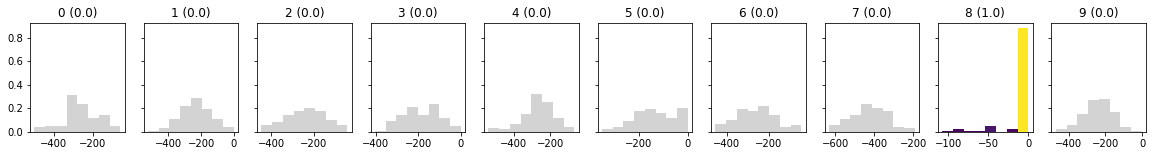

Correct


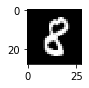

Real:  4


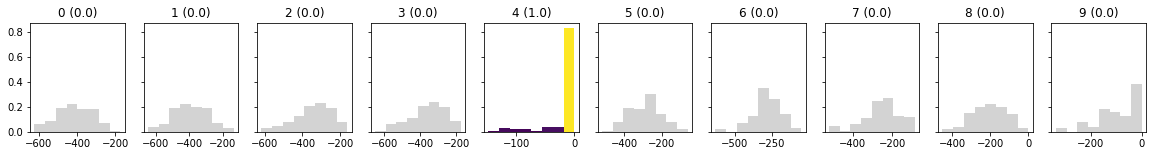

Correct


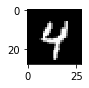

Real:  3


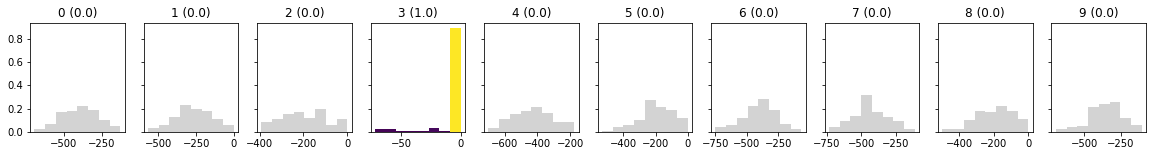

Correct


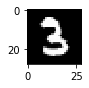

Summary
Total images:  128
Predicted for:  118
Accuracy when predicted:  0.9915254237288136
Total images:  128
Skipped:  10
Accuracy when made predictions: 99 %


In [0]:
# Prediction when network can decide not to predict

print('Prediction when network can refuse')
correct = 0
total = 0
total_predicted_for = 0
for j, data in enumerate(test_loader):
    images, labels = data
    
    total_minibatch, correct_minibatch, predictions_minibatch = test_batch(images, labels, plot=True)
    total += total_minibatch
    correct += correct_minibatch
    total_predicted_for += predictions_minibatch
    break

print("Total images: ", total)
print("Skipped: ", total-total_predicted_for)
print("Accuracy when made predictions: %d %%" % (100 * correct / total_predicted_for))

# An other way to print uncertainty

In [0]:
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=False, transform=transforms.Compose([transforms.Resize(28,28),transforms.ToTensor(),])
                       ),
        batch_size=128, shuffle=True)

In [0]:
def variance(yhats,mean): #tensor 100,128,10, tensor 128,10
  means = np.argmax(mean,axis = 1) #128 toutes nos preds moyennes
  toutes_preds = np.argmax(yhats,axis = 2) #tensor 100,128
  vals = [[(toutes_preds[i,j]== means[j]).item() for i in range(toutes_preds.shape[0])] for j in range(toutes_preds.shape[1])]  
  percent = [np.mean(vals[i]) for i in range(toutes_preds.shape[1])] #128
  var = [np.mean([((toutes_preds[i,j]==means[j]).item() - percent[j])**2 for i in range(toutes_preds.shape[0])]) for j in range(toutes_preds.shape[1])]
  return percent,means,var


In [0]:
num_samples = 100
def predict2(x,num_samples): #pour une image
    sampled_models = [guide(None, None) for _ in range(num_samples)]  
    yhats = [model(x).data for model in sampled_models] #Pour chacun de ces models
    mean = torch.mean(torch.stack(yhats), 0) #on calcul la moyenne de ses yhats
    percent,means,var = variance(torch.stack(yhats),mean)
    return percent,means,var,torch.stack(yhats)

In [0]:
correct = 0
total = 0
values = [] #value to input of the claasifier
labels_v = [] #label 0 or 1
labelss = [] #the class of the image
stacks = [] #all the output of the 100 NN for each images
for j, data in tqdm(enumerate(test_loader)):
    images, labels = data
    percent,means,var,stack = predict2(images.view(-1,28*28),100)
    for i in range(len(means)):
      values.append((percent[i],means[i],var[i]))
      labelss.append(labels[i].item())
      stacks.append(stack[:,i,:])
      if means[i] != labels[i].item():
        print("false")
        print(percent[i],means[i],labels[i],var[i])
        labels_v.append(0) #false
      else:
        print("correct")
        print(percent[i],means[i],labels[i],var[i])
        correct = correct +1
        labels_v.append(1)
      total = total + 1
print("ratio: ",correct/total)
  

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)
1it [00:07,  7.03s/it]

correct
0.94 tensor(1) tensor(1) 0.0564
correct
0.83 tensor(7) tensor(7) 0.14110000000000003
correct
0.84 tensor(6) tensor(6) 0.13440000000000005
correct
0.37 tensor(2) tensor(2) 0.23309999999999995
false
0.6 tensor(9) tensor(7) 0.24
correct
0.86 tensor(1) tensor(1) 0.1204
correct
0.93 tensor(1) tensor(1) 0.0651
correct
0.74 tensor(8) tensor(8) 0.19240000000000002
correct
0.96 tensor(1) tensor(1) 0.038400000000000004
correct
0.93 tensor(6) tensor(6) 0.06509999999999999
correct
0.96 tensor(6) tensor(6) 0.0384
correct
0.73 tensor(8) tensor(8) 0.19710000000000005
correct
0.4 tensor(6) tensor(6) 0.24
correct
0.68 tensor(4) tensor(4) 0.2176
correct
0.94 tensor(1) tensor(1) 0.056400000000000006
correct
0.93 tensor(7) tensor(7) 0.06510000000000002
correct
0.95 tensor(5) tensor(5) 0.04750000000000003
correct
0.76 tensor(2) tensor(2) 0.1824
correct
0.55 tensor(6) tensor(6) 0.24750000000000003
correct
0.75 tensor(9) tensor(9) 0.1875
correct
0.9 tensor(2) tensor(2) 0.09
correct
0.61 tensor(8) ten

2it [00:13,  6.88s/it]

correct
0.86 tensor(5) tensor(5) 0.1204
correct
0.86 tensor(6) tensor(6) 0.12040000000000001
correct
1.0 tensor(0) tensor(0) 0.0
correct
0.65 tensor(9) tensor(9) 0.22749999999999995
correct
0.96 tensor(7) tensor(7) 0.0384
correct
0.99 tensor(0) tensor(0) 0.009899999999999999
correct
0.87 tensor(1) tensor(1) 0.11309999999999999
correct
0.64 tensor(2) tensor(2) 0.2304
correct
0.86 tensor(9) tensor(9) 0.12040000000000001
correct
0.88 tensor(3) tensor(3) 0.10560000000000003
correct
0.66 tensor(9) tensor(9) 0.22440000000000004
correct
0.8 tensor(3) tensor(3) 0.16
correct
0.87 tensor(4) tensor(4) 0.11309999999999999
correct
0.42 tensor(3) tensor(3) 0.24360000000000007
correct
0.45 tensor(3) tensor(3) 0.24750000000000003
correct
0.9 tensor(1) tensor(1) 0.09
correct
0.91 tensor(4) tensor(4) 0.08190000000000001
false
0.47 tensor(3) tensor(5) 0.2490999999999999
correct
0.94 tensor(1) tensor(1) 0.0564
false
0.5 tensor(4) tensor(5) 0.25
correct
0.87 tensor(1) tensor(1) 0.11309999999999996
correct


3it [00:20,  6.76s/it]

correct
0.91 tensor(4) tensor(4) 0.08190000000000001
correct
0.69 tensor(7) tensor(7) 0.21389999999999998
correct
0.99 tensor(0) tensor(0) 0.009899999999999997
correct
1.0 tensor(2) tensor(2) 0.0
false
0.54 tensor(8) tensor(3) 0.24839999999999995
correct
0.9 tensor(0) tensor(0) 0.09
correct
0.7 tensor(9) tensor(9) 0.20999999999999996
correct
1.0 tensor(1) tensor(1) 0.0
correct
1.0 tensor(7) tensor(7) 0.0
false
0.74 tensor(0) tensor(2) 0.1924
correct
0.68 tensor(8) tensor(8) 0.2176
correct
0.79 tensor(4) tensor(4) 0.16590000000000005
correct
0.99 tensor(1) tensor(1) 0.009899999999999999
correct
0.91 tensor(5) tensor(5) 0.08190000000000001
correct
0.94 tensor(6) tensor(6) 0.056400000000000006
correct
0.97 tensor(6) tensor(6) 0.029100000000000004
correct
0.96 tensor(4) tensor(4) 0.0384
correct
0.62 tensor(6) tensor(6) 0.23559999999999998
correct
0.46 tensor(3) tensor(3) 0.24839999999999995
correct
0.95 tensor(2) tensor(2) 0.047500000000000014
correct
0.76 tensor(6) tensor(6) 0.1824
correc

4it [00:26,  6.69s/it]

correct
0.35 tensor(7) tensor(7) 0.22749999999999995
correct
0.57 tensor(9) tensor(9) 0.24509999999999996
false
0.51 tensor(9) tensor(4) 0.2499
correct
0.85 tensor(9) tensor(9) 0.12750000000000003
false
0.7 tensor(5) tensor(3) 0.20999999999999996
correct
0.89 tensor(4) tensor(4) 0.09790000000000001
correct
0.95 tensor(8) tensor(8) 0.047500000000000014
correct
0.7 tensor(6) tensor(6) 0.20999999999999994
correct
0.92 tensor(0) tensor(0) 0.07360000000000001
correct
0.91 tensor(6) tensor(6) 0.08190000000000001
correct
0.87 tensor(7) tensor(7) 0.11309999999999999
correct
0.99 tensor(1) tensor(1) 0.009899999999999999
correct
0.74 tensor(9) tensor(9) 0.1924
correct
0.85 tensor(4) tensor(4) 0.1275
false
0.35 tensor(4) tensor(8) 0.22749999999999995
correct
0.93 tensor(1) tensor(1) 0.06510000000000002
correct
0.86 tensor(1) tensor(1) 0.1204
correct
0.98 tensor(6) tensor(6) 0.019599999999999996
correct
0.96 tensor(3) tensor(3) 0.0384
correct
0.56 tensor(6) tensor(6) 0.24640000000000004
correct
0.

5it [00:33,  6.64s/it]

correct
0.56 tensor(8) tensor(8) 0.2464
correct
0.5 tensor(6) tensor(6) 0.25
correct
0.94 tensor(1) tensor(1) 0.0564
correct
0.9 tensor(5) tensor(5) 0.08999999999999998
correct
0.69 tensor(1) tensor(1) 0.21389999999999992
correct
0.95 tensor(1) tensor(1) 0.04750000000000003
correct
0.91 tensor(5) tensor(5) 0.08190000000000001
correct
0.83 tensor(4) tensor(4) 0.14110000000000003
correct
0.94 tensor(5) tensor(5) 0.0564
correct
0.92 tensor(1) tensor(1) 0.0736
false
0.39 tensor(9) tensor(4) 0.2379
correct
0.33 tensor(4) tensor(4) 0.22109999999999996
correct
0.99 tensor(6) tensor(6) 0.009899999999999999
correct
0.86 tensor(4) tensor(4) 0.1204
correct
0.69 tensor(8) tensor(8) 0.21389999999999998
correct
0.51 tensor(0) tensor(0) 0.24989999999999996
correct
0.62 tensor(7) tensor(7) 0.23560000000000003
correct
0.92 tensor(2) tensor(2) 0.0736
correct
0.61 tensor(3) tensor(3) 0.2379
correct
0.52 tensor(2) tensor(2) 0.24959999999999996
correct
0.91 tensor(4) tensor(4) 0.08190000000000003
correct
0

6it [00:39,  6.60s/it]

correct
0.75 tensor(5) tensor(5) 0.1875
correct
0.53 tensor(3) tensor(3) 0.24909999999999993
correct
0.68 tensor(4) tensor(4) 0.2176
correct
0.67 tensor(4) tensor(4) 0.2211
correct
0.94 tensor(8) tensor(8) 0.056400000000000006
correct
0.81 tensor(9) tensor(9) 0.1539
correct
0.93 tensor(3) tensor(3) 0.0651
correct
0.47 tensor(5) tensor(5) 0.24909999999999993
correct
0.76 tensor(3) tensor(3) 0.18240000000000006
correct
0.82 tensor(9) tensor(9) 0.1476
correct
0.91 tensor(6) tensor(6) 0.08190000000000001
correct
0.99 tensor(0) tensor(0) 0.009899999999999999
correct
0.98 tensor(1) tensor(1) 0.019599999999999996
false
0.43 tensor(0) tensor(5) 0.24509999999999998
correct
0.84 tensor(2) tensor(2) 0.13440000000000002
correct
0.7 tensor(4) tensor(4) 0.20999999999999996
false
0.54 tensor(9) tensor(7) 0.24839999999999995
correct
1.0 tensor(0) tensor(0) 0.0
correct
0.7 tensor(8) tensor(8) 0.20999999999999996
correct
0.72 tensor(9) tensor(9) 0.2015999999999999
false
0.35 tensor(2) tensor(7) 0.2275
c

7it [00:46,  6.60s/it]

correct
0.44 tensor(9) tensor(9) 0.24640000000000006
correct
0.92 tensor(9) tensor(9) 0.0736
correct
0.87 tensor(7) tensor(7) 0.11309999999999999
correct
0.95 tensor(1) tensor(1) 0.04750000000000003
correct
0.93 tensor(1) tensor(1) 0.06510000000000002
correct
0.75 tensor(9) tensor(9) 0.1875
correct
0.98 tensor(2) tensor(2) 0.019599999999999996
correct
0.75 tensor(2) tensor(2) 0.1875
correct
0.81 tensor(6) tensor(6) 0.15389999999999998
correct
0.97 tensor(1) tensor(1) 0.029099999999999997
correct
0.7 tensor(3) tensor(3) 0.20999999999999996
false
0.32 tensor(1) tensor(4) 0.2175999999999999
correct
0.92 tensor(6) tensor(6) 0.0736
correct
0.9 tensor(8) tensor(8) 0.09
correct
0.94 tensor(3) tensor(3) 0.056400000000000006
correct
0.69 tensor(9) tensor(9) 0.21389999999999998
correct
0.91 tensor(4) tensor(4) 0.08190000000000001
correct
0.73 tensor(3) tensor(3) 0.1971
correct
0.75 tensor(2) tensor(2) 0.1875
correct
0.88 tensor(9) tensor(9) 0.10559999999999999
correct
0.98 tensor(1) tensor(1) 0.

8it [00:52,  6.58s/it]

correct
0.8 tensor(9) tensor(9) 0.16
correct
0.74 tensor(4) tensor(4) 0.19240000000000002
correct
0.97 tensor(4) tensor(4) 0.029100000000000004
correct
0.96 tensor(4) tensor(4) 0.0384
correct
0.88 tensor(4) tensor(4) 0.1056
correct
0.44 tensor(4) tensor(4) 0.24640000000000004
correct
0.61 tensor(8) tensor(8) 0.2379
correct
0.94 tensor(8) tensor(8) 0.0564
correct
0.74 tensor(5) tensor(5) 0.1924
correct
0.29 tensor(3) tensor(3) 0.20589999999999997
correct
0.9 tensor(8) tensor(8) 0.09
correct
0.97 tensor(1) tensor(1) 0.02910000000000001
correct
0.99 tensor(1) tensor(1) 0.009899999999999997
correct
0.5 tensor(2) tensor(2) 0.25
correct
0.62 tensor(9) tensor(9) 0.23559999999999998
correct
0.77 tensor(8) tensor(8) 0.1771
correct
0.47 tensor(8) tensor(8) 0.24909999999999993
correct
0.64 tensor(0) tensor(0) 0.23040000000000002
correct
0.95 tensor(4) tensor(4) 0.047500000000000014
correct
0.36 tensor(2) tensor(2) 0.23040000000000002
correct
0.84 tensor(1) tensor(1) 0.13440000000000002
correct
0.

9it [00:59,  6.57s/it]

correct
0.81 tensor(5) tensor(5) 0.1539
correct
0.82 tensor(8) tensor(8) 0.1476
correct
0.81 tensor(9) tensor(9) 0.15389999999999998
false
0.4 tensor(8) tensor(5) 0.24
false
0.22 tensor(9) tensor(5) 0.17160000000000003
correct
0.88 tensor(8) tensor(8) 0.1056
correct
0.74 tensor(9) tensor(9) 0.19240000000000002
correct
0.98 tensor(2) tensor(2) 0.019599999999999996
correct
0.37 tensor(7) tensor(7) 0.23309999999999995
correct
0.96 tensor(0) tensor(0) 0.038400000000000004
correct
0.81 tensor(9) tensor(9) 0.15389999999999998
correct
0.47 tensor(9) tensor(9) 0.2490999999999999
correct
0.58 tensor(7) tensor(7) 0.24360000000000007
correct
0.78 tensor(8) tensor(8) 0.17160000000000003
correct
0.77 tensor(2) tensor(2) 0.1771
correct
0.91 tensor(6) tensor(6) 0.08190000000000001
correct
0.54 tensor(6) tensor(6) 0.24839999999999995
correct
0.98 tensor(0) tensor(0) 0.019599999999999996
correct
1.0 tensor(2) tensor(2) 0.0
correct
0.72 tensor(8) tensor(8) 0.20159999999999992
correct
0.93 tensor(5) tens

10it [01:05,  6.55s/it]

correct
0.68 tensor(5) tensor(5) 0.2176
correct
0.77 tensor(3) tensor(3) 0.1771
correct
0.9 tensor(2) tensor(2) 0.09
false
0.43 tensor(9) tensor(4) 0.24509999999999998
correct
0.95 tensor(0) tensor(0) 0.04750000000000003
correct
0.91 tensor(4) tensor(4) 0.08190000000000003
correct
0.76 tensor(3) tensor(3) 0.1824
correct
0.9 tensor(7) tensor(7) 0.09
correct
0.83 tensor(6) tensor(6) 0.1411
correct
0.64 tensor(5) tensor(5) 0.2304
correct
0.98 tensor(0) tensor(0) 0.019599999999999992
correct
0.93 tensor(1) tensor(1) 0.06510000000000002
correct
0.98 tensor(0) tensor(0) 0.019599999999999992
correct
0.76 tensor(9) tensor(9) 0.1824
correct
0.86 tensor(4) tensor(4) 0.12040000000000002
correct
0.69 tensor(6) tensor(6) 0.21389999999999998
correct
0.92 tensor(7) tensor(7) 0.0736
correct
0.95 tensor(4) tensor(4) 0.047500000000000035
correct
0.78 tensor(8) tensor(8) 0.17160000000000003
correct
0.98 tensor(7) tensor(7) 0.019599999999999992
correct
0.96 tensor(1) tensor(1) 0.03840000000000001
correct


11it [01:12,  6.53s/it]

correct
0.58 tensor(3) tensor(3) 0.24360000000000007
correct
0.8 tensor(4) tensor(4) 0.16
correct
0.39 tensor(9) tensor(9) 0.23790000000000003
correct
0.47 tensor(7) tensor(7) 0.24909999999999993
correct
0.89 tensor(6) tensor(6) 0.09790000000000001
correct
0.74 tensor(5) tensor(5) 0.1924
correct
0.87 tensor(2) tensor(2) 0.1131
correct
0.93 tensor(8) tensor(8) 0.06510000000000002
correct
0.83 tensor(7) tensor(7) 0.1411
correct
0.98 tensor(2) tensor(2) 0.019599999999999996
correct
0.83 tensor(8) tensor(8) 0.1411
false
0.85 tensor(7) tensor(2) 0.1275
correct
0.78 tensor(9) tensor(9) 0.17160000000000003
correct
0.92 tensor(7) tensor(7) 0.0736
correct
0.91 tensor(5) tensor(5) 0.08190000000000001
correct
0.95 tensor(1) tensor(1) 0.04750000000000001
correct
0.91 tensor(8) tensor(8) 0.0819
false
0.26 tensor(1) tensor(5) 0.19240000000000002
correct
0.84 tensor(1) tensor(1) 0.13440000000000002
correct
0.87 tensor(7) tensor(7) 0.11309999999999999
correct
0.9 tensor(8) tensor(8) 0.09
correct
0.67 

12it [01:18,  6.52s/it]

correct
0.85 tensor(2) tensor(2) 0.1275
correct
0.81 tensor(6) tensor(6) 0.15389999999999998
correct
0.98 tensor(7) tensor(7) 0.019599999999999992
correct
0.82 tensor(8) tensor(8) 0.1476
correct
0.34 tensor(6) tensor(6) 0.22440000000000002
correct
0.89 tensor(1) tensor(1) 0.09790000000000001
correct
0.76 tensor(3) tensor(3) 0.1824
correct
0.78 tensor(2) tensor(2) 0.17160000000000003
correct
0.98 tensor(1) tensor(1) 0.019599999999999996
correct
0.72 tensor(6) tensor(6) 0.2015999999999999
correct
0.81 tensor(7) tensor(7) 0.1539
correct
0.98 tensor(1) tensor(1) 0.019599999999999996
correct
0.89 tensor(7) tensor(7) 0.09790000000000001
correct
0.85 tensor(0) tensor(0) 0.1275
correct
0.91 tensor(0) tensor(0) 0.0819
correct
0.92 tensor(1) tensor(1) 0.0736
correct
0.86 tensor(9) tensor(9) 0.1204
correct
0.81 tensor(6) tensor(6) 0.15389999999999998
correct
0.86 tensor(6) tensor(6) 0.1204
correct
0.98 tensor(0) tensor(0) 0.019599999999999992
correct
0.96 tensor(1) tensor(1) 0.0384
false
0.24 ten

13it [01:25,  6.50s/it]

correct
0.95 tensor(6) tensor(6) 0.04750000000000003
correct
0.93 tensor(0) tensor(0) 0.06510000000000002
correct
0.8 tensor(7) tensor(7) 0.15999999999999998
correct
0.91 tensor(8) tensor(8) 0.08190000000000003
correct
1.0 tensor(2) tensor(2) 0.0
correct
1.0 tensor(0) tensor(0) 0.0
correct
0.56 tensor(2) tensor(2) 0.24640000000000004
correct
0.67 tensor(6) tensor(6) 0.22109999999999994
false
0.42 tensor(8) tensor(6) 0.24360000000000007
correct
0.91 tensor(1) tensor(1) 0.08190000000000003
false
0.31 tensor(6) tensor(5) 0.21389999999999992
correct
0.97 tensor(0) tensor(0) 0.02910000000000001
correct
0.84 tensor(8) tensor(8) 0.13440000000000005
false
0.57 tensor(3) tensor(5) 0.24509999999999996
correct
1.0 tensor(0) tensor(0) 0.0
correct
0.75 tensor(5) tensor(5) 0.1875
correct
0.83 tensor(2) tensor(2) 0.14110000000000003
correct
0.91 tensor(5) tensor(5) 0.0819
correct
0.77 tensor(2) tensor(2) 0.1771
correct
0.8 tensor(7) tensor(7) 0.16000000000000003
correct
0.96 tensor(4) tensor(4) 0.038

14it [01:31,  6.50s/it]

false
0.63 tensor(8) tensor(2) 0.23309999999999995
correct
0.76 tensor(4) tensor(4) 0.1824
correct
0.83 tensor(4) tensor(4) 0.1411
correct
0.46 tensor(8) tensor(8) 0.24839999999999995
correct
0.51 tensor(7) tensor(7) 0.24989999999999996
correct
0.5 tensor(7) tensor(7) 0.25
correct
0.74 tensor(4) tensor(4) 0.19240000000000002
correct
0.73 tensor(7) tensor(7) 0.1971
correct
0.84 tensor(4) tensor(4) 0.13440000000000005
correct
0.96 tensor(1) tensor(1) 0.0384
correct
0.78 tensor(9) tensor(9) 0.17160000000000003
correct
0.76 tensor(1) tensor(1) 0.1824
correct
0.7 tensor(0) tensor(0) 0.20999999999999996
false
0.48 tensor(9) tensor(4) 0.24959999999999996
correct
0.62 tensor(4) tensor(4) 0.23560000000000006
correct
0.89 tensor(4) tensor(4) 0.09789999999999999
correct
0.83 tensor(5) tensor(5) 0.14110000000000003
correct
0.98 tensor(1) tensor(1) 0.019599999999999996
correct
0.9 tensor(7) tensor(7) 0.09
correct
0.97 tensor(1) tensor(1) 0.029100000000000004
correct
0.73 tensor(3) tensor(3) 0.19710

15it [01:38,  6.52s/it]

correct
0.71 tensor(4) tensor(4) 0.20590000000000003
correct
0.94 tensor(3) tensor(3) 0.0564
correct
0.66 tensor(8) tensor(8) 0.22440000000000004
correct
0.63 tensor(9) tensor(9) 0.23309999999999995
correct
0.99 tensor(0) tensor(0) 0.009899999999999999
correct
0.7 tensor(9) tensor(9) 0.20999999999999996
correct
0.93 tensor(1) tensor(1) 0.06510000000000002
correct
0.95 tensor(0) tensor(0) 0.04750000000000001
correct
0.92 tensor(6) tensor(6) 0.0736
correct
0.79 tensor(4) tensor(4) 0.1659
correct
0.6 tensor(3) tensor(3) 0.24000000000000005
correct
0.98 tensor(1) tensor(1) 0.019599999999999996
correct
0.94 tensor(7) tensor(7) 0.056400000000000006
correct
0.72 tensor(8) tensor(8) 0.20159999999999992
correct
0.82 tensor(9) tensor(9) 0.1476
correct
0.73 tensor(7) tensor(7) 0.1971
correct
0.87 tensor(5) tensor(5) 0.1131
correct
0.97 tensor(1) tensor(1) 0.029100000000000004
correct
0.81 tensor(9) tensor(9) 0.15389999999999998
false
0.41 tensor(2) tensor(6) 0.24189999999999998
correct
0.46 tenso

16it [01:44,  6.51s/it]

correct
0.62 tensor(5) tensor(5) 0.23560000000000003
correct
0.94 tensor(6) tensor(6) 0.0564
correct
0.82 tensor(8) tensor(8) 0.1476
false
0.28 tensor(2) tensor(6) 0.20159999999999992
correct
0.6 tensor(3) tensor(3) 0.24
correct
0.89 tensor(0) tensor(0) 0.09790000000000001
correct
1.0 tensor(0) tensor(0) 0.0
correct
0.73 tensor(8) tensor(8) 0.1971
correct
0.8 tensor(6) tensor(6) 0.16
correct
0.81 tensor(1) tensor(1) 0.15389999999999998
false
0.44 tensor(2) tensor(5) 0.24640000000000006
correct
0.59 tensor(3) tensor(3) 0.24189999999999995
correct
0.98 tensor(2) tensor(2) 0.019599999999999992
correct
0.78 tensor(4) tensor(4) 0.17160000000000003
correct
0.95 tensor(1) tensor(1) 0.04750000000000003
correct
0.95 tensor(1) tensor(1) 0.04750000000000001
false
0.34 tensor(2) tensor(7) 0.22440000000000004
correct
0.98 tensor(6) tensor(6) 0.019599999999999992
correct
0.77 tensor(9) tensor(9) 0.17710000000000004
correct
0.58 tensor(5) tensor(5) 0.24360000000000007
correct
0.98 tensor(7) tensor(7)

17it [01:51,  6.51s/it]

correct
0.94 tensor(0) tensor(0) 0.0564
correct
0.78 tensor(9) tensor(9) 0.1716
correct
0.91 tensor(4) tensor(4) 0.08190000000000001
correct
0.8 tensor(0) tensor(0) 0.16
correct
0.29 tensor(2) tensor(2) 0.20590000000000003
correct
0.77 tensor(9) tensor(9) 0.17710000000000004
correct
0.45 tensor(9) tensor(9) 0.24750000000000003
correct
0.87 tensor(6) tensor(6) 0.11309999999999999
correct
0.64 tensor(5) tensor(5) 0.2304
correct
0.99 tensor(0) tensor(0) 0.009899999999999999
correct
0.84 tensor(6) tensor(6) 0.13440000000000002
correct
0.76 tensor(8) tensor(8) 0.1824
correct
0.58 tensor(2) tensor(2) 0.24360000000000004
correct
0.93 tensor(6) tensor(6) 0.06510000000000002
correct
0.79 tensor(8) tensor(8) 0.1659
correct
0.39 tensor(3) tensor(3) 0.23790000000000006
correct
0.83 tensor(7) tensor(7) 0.14110000000000003
correct
0.49 tensor(3) tensor(3) 0.24989999999999996
correct
0.76 tensor(4) tensor(4) 0.1824
correct
0.87 tensor(8) tensor(8) 0.11309999999999999
correct
0.94 tensor(8) tensor(8) 

18it [01:57,  6.50s/it]

correct
0.87 tensor(1) tensor(1) 0.11309999999999999
correct
0.76 tensor(6) tensor(6) 0.1824
correct
0.86 tensor(5) tensor(5) 0.1204
correct
0.96 tensor(6) tensor(6) 0.03840000000000001
correct
0.86 tensor(4) tensor(4) 0.1204
correct
0.98 tensor(1) tensor(1) 0.019599999999999992
correct
0.76 tensor(8) tensor(8) 0.18240000000000006
correct
0.95 tensor(6) tensor(6) 0.047500000000000056
correct
0.98 tensor(1) tensor(1) 0.019599999999999996
correct
0.87 tensor(0) tensor(0) 0.11309999999999996
correct
0.98 tensor(1) tensor(1) 0.019599999999999996
correct
0.94 tensor(1) tensor(1) 0.056400000000000006
correct
0.95 tensor(1) tensor(1) 0.047500000000000014
correct
0.53 tensor(7) tensor(7) 0.24909999999999993
correct
0.98 tensor(1) tensor(1) 0.019599999999999996
correct
0.91 tensor(3) tensor(3) 0.08190000000000003
correct
0.7 tensor(5) tensor(5) 0.20999999999999996
correct
0.61 tensor(9) tensor(9) 0.23790000000000003
correct
0.88 tensor(8) tensor(8) 0.10559999999999999
correct
0.92 tensor(5) ten

19it [02:04,  6.49s/it]

correct
0.83 tensor(3) tensor(3) 0.14110000000000003
correct
0.79 tensor(7) tensor(7) 0.16590000000000005
false
0.42 tensor(1) tensor(8) 0.24360000000000007
correct
0.96 tensor(0) tensor(0) 0.03839999999999999
correct
1.0 tensor(0) tensor(0) 0.0
correct
0.66 tensor(5) tensor(5) 0.22440000000000004
correct
0.87 tensor(5) tensor(5) 0.11309999999999999
correct
0.98 tensor(1) tensor(1) 0.019599999999999996
correct
0.79 tensor(5) tensor(5) 0.1659
correct
0.98 tensor(4) tensor(4) 0.019599999999999992
correct
0.95 tensor(4) tensor(4) 0.047500000000000014
correct
0.74 tensor(9) tensor(9) 0.1924
correct
0.95 tensor(2) tensor(2) 0.047500000000000014
correct
1.0 tensor(2) tensor(2) 0.0
false
0.31 tensor(4) tensor(6) 0.21389999999999992
correct
0.96 tensor(0) tensor(0) 0.0384
correct
0.9 tensor(2) tensor(2) 0.09
correct
0.85 tensor(8) tensor(8) 0.1275
correct
0.61 tensor(0) tensor(0) 0.2379
correct
0.78 tensor(6) tensor(6) 0.1716
correct
0.96 tensor(1) tensor(1) 0.0384
correct
0.82 tensor(0) tenso

20it [02:10,  6.50s/it]

correct
0.65 tensor(9) tensor(9) 0.22749999999999995
correct
0.97 tensor(0) tensor(0) 0.0291
correct
0.85 tensor(2) tensor(2) 0.1275
correct
0.83 tensor(5) tensor(5) 0.1411
correct
0.84 tensor(9) tensor(9) 0.13440000000000002
correct
0.62 tensor(0) tensor(0) 0.23559999999999998
correct
0.87 tensor(4) tensor(4) 0.11309999999999999
correct
0.61 tensor(6) tensor(6) 0.2379
correct
0.55 tensor(3) tensor(3) 0.2475
correct
0.45 tensor(5) tensor(5) 0.24750000000000008
correct
0.93 tensor(1) tensor(1) 0.06510000000000002
correct
0.89 tensor(4) tensor(4) 0.09790000000000001
false
0.44 tensor(4) tensor(9) 0.24640000000000006
false
0.66 tensor(2) tensor(3) 0.22440000000000004
correct
0.94 tensor(7) tensor(7) 0.056400000000000006
correct
0.96 tensor(0) tensor(0) 0.038400000000000004
correct
0.61 tensor(0) tensor(0) 0.2379
correct
0.89 tensor(8) tensor(8) 0.09789999999999999
correct
0.92 tensor(3) tensor(3) 0.0736
correct
0.87 tensor(5) tensor(5) 0.11309999999999999
correct
0.75 tensor(6) tensor(6) 

21it [02:17,  6.51s/it]

correct
0.89 tensor(5) tensor(5) 0.09790000000000001
correct
1.0 tensor(7) tensor(7) 0.0
false
0.46 tensor(9) tensor(7) 0.24839999999999995
correct
0.86 tensor(7) tensor(7) 0.1204
correct
0.98 tensor(1) tensor(1) 0.019599999999999996
correct
0.92 tensor(2) tensor(2) 0.0736
correct
0.67 tensor(6) tensor(6) 0.22109999999999994
correct
0.81 tensor(7) tensor(7) 0.1539
correct
0.96 tensor(3) tensor(3) 0.0384
false
0.5 tensor(2) tensor(3) 0.25
correct
0.83 tensor(9) tensor(9) 0.14110000000000003
correct
0.87 tensor(6) tensor(6) 0.1131
correct
0.93 tensor(8) tensor(8) 0.0651
correct
1.0 tensor(0) tensor(0) 0.0
correct
0.37 tensor(1) tensor(1) 0.23310000000000003
correct
0.52 tensor(7) tensor(7) 0.24959999999999993
correct
0.91 tensor(1) tensor(1) 0.08190000000000001
false
0.85 tensor(4) tensor(8) 0.1275
correct
0.84 tensor(6) tensor(6) 0.13440000000000005
correct
0.67 tensor(9) tensor(9) 0.22109999999999994
correct
0.89 tensor(2) tensor(2) 0.09790000000000001
correct
0.97 tensor(3) tensor(3) 

22it [02:23,  6.52s/it]

correct
0.95 tensor(1) tensor(1) 0.047500000000000014
false
0.48 tensor(3) tensor(9) 0.24959999999999993
correct
0.88 tensor(9) tensor(9) 0.1056
correct
0.89 tensor(7) tensor(7) 0.09790000000000001
correct
0.66 tensor(8) tensor(8) 0.22440000000000004
correct
0.99 tensor(4) tensor(4) 0.009899999999999997
correct
0.88 tensor(6) tensor(6) 0.10559999999999999
correct
0.92 tensor(6) tensor(6) 0.0736
correct
0.7 tensor(9) tensor(9) 0.20999999999999996
correct
0.89 tensor(8) tensor(8) 0.09790000000000001
correct
0.74 tensor(4) tensor(4) 0.1924
false
0.26 tensor(1) tensor(7) 0.1924
correct
0.94 tensor(0) tensor(0) 0.056400000000000006
false
0.69 tensor(2) tensor(1) 0.21389999999999992
correct
0.36 tensor(5) tensor(5) 0.2304
false
0.53 tensor(8) tensor(5) 0.24909999999999993
correct
0.71 tensor(4) tensor(4) 0.20590000000000003
correct
0.41 tensor(2) tensor(2) 0.24189999999999995
false
0.56 tensor(8) tensor(1) 0.24640000000000004
correct
0.91 tensor(2) tensor(2) 0.08190000000000001
correct
0.94 

23it [02:30,  6.52s/it]

correct
0.87 tensor(1) tensor(1) 0.1131
correct
0.86 tensor(1) tensor(1) 0.1204
correct
0.56 tensor(9) tensor(9) 0.24640000000000004
correct
0.95 tensor(7) tensor(7) 0.04750000000000003
correct
0.62 tensor(6) tensor(6) 0.23559999999999998
correct
0.93 tensor(5) tensor(5) 0.06509999999999999
correct
0.99 tensor(7) tensor(7) 0.009899999999999997
correct
1.0 tensor(4) tensor(4) 0.0
correct
0.67 tensor(6) tensor(6) 0.2211
correct
0.71 tensor(7) tensor(7) 0.2059
correct
0.89 tensor(6) tensor(6) 0.09789999999999999
correct
0.92 tensor(0) tensor(0) 0.0736
correct
0.49 tensor(9) tensor(9) 0.2499
correct
0.77 tensor(9) tensor(9) 0.17710000000000004
correct
0.69 tensor(3) tensor(3) 0.21389999999999992
correct
0.94 tensor(7) tensor(7) 0.056400000000000006
correct
0.3 tensor(5) tensor(5) 0.20999999999999996
correct
0.63 tensor(2) tensor(2) 0.23310000000000003
false
0.51 tensor(8) tensor(1) 0.2499
correct
0.32 tensor(8) tensor(8) 0.21759999999999993
correct
0.59 tensor(3) tensor(3) 0.24189999999999

24it [02:36,  6.52s/it]

correct
0.99 tensor(4) tensor(4) 0.009899999999999997
correct
0.77 tensor(2) tensor(2) 0.17710000000000004
correct
0.39 tensor(3) tensor(3) 0.2379
correct
0.66 tensor(9) tensor(9) 0.22440000000000004
correct
0.9 tensor(7) tensor(7) 0.09
correct
0.68 tensor(9) tensor(9) 0.2176
correct
0.7 tensor(4) tensor(4) 0.20999999999999996
correct
1.0 tensor(0) tensor(0) 0.0
false
0.41 tensor(4) tensor(9) 0.24189999999999998
correct
0.7 tensor(5) tensor(5) 0.20999999999999996
correct
0.92 tensor(7) tensor(7) 0.0736
correct
0.98 tensor(7) tensor(7) 0.019599999999999992
correct
0.5 tensor(1) tensor(1) 0.25
correct
0.89 tensor(8) tensor(8) 0.09789999999999999
correct
0.71 tensor(3) tensor(3) 0.20590000000000003
correct
0.95 tensor(1) tensor(1) 0.047500000000000014
correct
0.63 tensor(5) tensor(5) 0.23309999999999992
false
0.7 tensor(8) tensor(2) 0.20999999999999996
correct
0.9 tensor(3) tensor(3) 0.09
false
0.22 tensor(8) tensor(0) 0.1716
correct
0.75 tensor(5) tensor(5) 0.1875
correct
0.99 tensor(1) 

25it [02:43,  6.52s/it]

correct
0.81 tensor(9) tensor(9) 0.1539
correct
0.68 tensor(6) tensor(6) 0.2176
correct
0.96 tensor(4) tensor(4) 0.03840000000000001
correct
0.66 tensor(6) tensor(6) 0.22440000000000004
correct
0.99 tensor(1) tensor(1) 0.009899999999999999
correct
0.97 tensor(0) tensor(0) 0.029100000000000004
correct
0.94 tensor(4) tensor(4) 0.056400000000000006
correct
0.92 tensor(7) tensor(7) 0.0736
correct
0.84 tensor(9) tensor(9) 0.13440000000000002
correct
0.55 tensor(7) tensor(7) 0.24750000000000008
correct
0.92 tensor(7) tensor(7) 0.07360000000000001
correct
0.56 tensor(7) tensor(7) 0.24640000000000004
correct
0.77 tensor(5) tensor(5) 0.1771
correct
0.96 tensor(1) tensor(1) 0.0384
correct
0.7 tensor(5) tensor(5) 0.20999999999999996
correct
0.67 tensor(9) tensor(9) 0.22109999999999994
correct
0.64 tensor(0) tensor(0) 0.2304
correct
0.88 tensor(9) tensor(9) 0.10559999999999999
correct
0.92 tensor(8) tensor(8) 0.0736
correct
0.89 tensor(6) tensor(6) 0.09789999999999999
correct
1.0 tensor(4) tensor(

26it [02:49,  6.53s/it]

correct
0.92 tensor(6) tensor(6) 0.0736
correct
0.73 tensor(0) tensor(0) 0.19710000000000005
correct
0.77 tensor(5) tensor(5) 0.1771000000000001
correct
1.0 tensor(0) tensor(0) 0.0
correct
0.65 tensor(2) tensor(2) 0.2275
false
0.48 tensor(8) tensor(5) 0.24959999999999993
correct
0.39 tensor(5) tensor(5) 0.2379
correct
0.87 tensor(4) tensor(4) 0.11309999999999999
correct
0.68 tensor(6) tensor(6) 0.2176
correct
0.95 tensor(4) tensor(4) 0.04750000000000003
correct
0.92 tensor(3) tensor(3) 0.0736
correct
0.61 tensor(5) tensor(5) 0.23790000000000003
correct
0.88 tensor(9) tensor(9) 0.10560000000000003
correct
1.0 tensor(4) tensor(4) 0.0
correct
0.94 tensor(3) tensor(3) 0.056400000000000006
correct
0.71 tensor(3) tensor(3) 0.20589999999999997
correct
0.73 tensor(9) tensor(9) 0.19710000000000005
correct
0.38 tensor(5) tensor(5) 0.23560000000000006
correct
0.96 tensor(1) tensor(1) 0.0384
correct
0.83 tensor(4) tensor(4) 0.1411
correct
0.63 tensor(8) tensor(8) 0.23309999999999997
false
0.43 ten

27it [02:56,  6.54s/it]

correct
0.7 tensor(8) tensor(8) 0.20999999999999996
correct
0.92 tensor(1) tensor(1) 0.0736
correct
0.82 tensor(1) tensor(1) 0.1476
correct
0.53 tensor(9) tensor(9) 0.24909999999999993
correct
0.41 tensor(9) tensor(9) 0.24189999999999998
correct
0.56 tensor(5) tensor(5) 0.2464
correct
0.9 tensor(8) tensor(8) 0.09
correct
0.62 tensor(9) tensor(9) 0.23560000000000003
correct
0.87 tensor(8) tensor(8) 0.11309999999999999
correct
0.69 tensor(6) tensor(6) 0.21389999999999998
correct
0.99 tensor(2) tensor(2) 0.009899999999999999
correct
0.94 tensor(3) tensor(3) 0.0564
correct
0.48 tensor(5) tensor(5) 0.24959999999999993
correct
0.88 tensor(8) tensor(8) 0.1056
false
0.5 tensor(2) tensor(3) 0.25
correct
0.91 tensor(8) tensor(8) 0.0819
correct
0.99 tensor(2) tensor(2) 0.009899999999999999
false
0.55 tensor(8) tensor(3) 0.2475
false
0.51 tensor(5) tensor(6) 0.2499
correct
0.94 tensor(3) tensor(3) 0.056400000000000006
correct
0.97 tensor(0) tensor(0) 0.029100000000000004
correct
0.95 tensor(4) ten

28it [03:03,  6.54s/it]

correct
0.96 tensor(8) tensor(8) 0.03840000000000001
correct
0.69 tensor(5) tensor(5) 0.2138999999999999
false
0.88 tensor(0) tensor(2) 0.10559999999999999
correct
0.75 tensor(8) tensor(8) 0.1875
correct
0.96 tensor(1) tensor(1) 0.0384
correct
0.38 tensor(4) tensor(4) 0.23560000000000003
correct
0.69 tensor(0) tensor(0) 0.21389999999999992
correct
0.99 tensor(2) tensor(2) 0.009899999999999997
correct
0.9 tensor(3) tensor(3) 0.09
correct
0.82 tensor(6) tensor(6) 0.1476
correct
0.62 tensor(7) tensor(7) 0.23559999999999998
correct
0.99 tensor(1) tensor(1) 0.009899999999999997
correct
0.99 tensor(3) tensor(3) 0.009899999999999999
correct
0.83 tensor(6) tensor(6) 0.1411
correct
0.94 tensor(8) tensor(8) 0.056400000000000006
correct
0.85 tensor(0) tensor(0) 0.1275
false
0.68 tensor(2) tensor(7) 0.2176
correct
1.0 tensor(0) tensor(0) 0.0
correct
1.0 tensor(0) tensor(0) 0.0
correct
0.68 tensor(8) tensor(8) 0.2176
correct
0.44 tensor(5) tensor(5) 0.24640000000000004
correct
0.92 tensor(4) tensor

29it [03:09,  6.53s/it]

correct
0.39 tensor(7) tensor(7) 0.2379
correct
0.78 tensor(0) tensor(0) 0.1716
correct
0.81 tensor(2) tensor(2) 0.1539
correct
0.69 tensor(3) tensor(3) 0.21389999999999998
correct
0.82 tensor(9) tensor(9) 0.1476
correct
0.34 tensor(5) tensor(5) 0.2244
false
0.62 tensor(1) tensor(9) 0.23560000000000006
correct
0.74 tensor(0) tensor(0) 0.1924
correct
0.92 tensor(2) tensor(2) 0.0736
correct
0.61 tensor(3) tensor(3) 0.2379
correct
0.98 tensor(1) tensor(1) 0.019599999999999996
correct
0.94 tensor(7) tensor(7) 0.0564
false
0.5 tensor(8) tensor(2) 0.25
correct
0.85 tensor(3) tensor(3) 0.12750000000000003
correct
0.94 tensor(6) tensor(6) 0.0564
correct
0.91 tensor(0) tensor(0) 0.08190000000000001
correct
0.55 tensor(3) tensor(3) 0.24750000000000003
correct
0.95 tensor(8) tensor(8) 0.047500000000000035
correct
0.59 tensor(0) tensor(0) 0.24189999999999995
correct
0.97 tensor(6) tensor(6) 0.029100000000000004
correct
0.62 tensor(8) tensor(8) 0.23560000000000003
correct
0.86 tensor(4) tensor(4) 0

30it [03:16,  6.51s/it]

correct
0.96 tensor(6) tensor(6) 0.0384
correct
0.98 tensor(1) tensor(1) 0.019599999999999992
correct
0.84 tensor(9) tensor(9) 0.13440000000000002
correct
0.95 tensor(6) tensor(6) 0.04750000000000003
correct
0.79 tensor(4) tensor(4) 0.1659
correct
0.96 tensor(4) tensor(4) 0.038400000000000004
correct
0.57 tensor(3) tensor(3) 0.24509999999999998
correct
0.71 tensor(9) tensor(9) 0.20590000000000003
correct
0.77 tensor(4) tensor(4) 0.1771
correct
1.0 tensor(0) tensor(0) 0.0
correct
0.96 tensor(7) tensor(7) 0.0384
correct
0.88 tensor(2) tensor(2) 0.1056
correct
0.97 tensor(0) tensor(0) 0.029100000000000004
correct
1.0 tensor(0) tensor(0) 0.0
correct
0.71 tensor(4) tensor(4) 0.2059
correct
1.0 tensor(8) tensor(8) 0.0
correct
0.68 tensor(7) tensor(7) 0.2176
correct
0.57 tensor(5) tensor(5) 0.2450999999999999
correct
0.94 tensor(3) tensor(3) 0.0564
correct
0.95 tensor(1) tensor(1) 0.047500000000000014
correct
0.85 tensor(9) tensor(9) 0.1275
correct
0.96 tensor(1) tensor(1) 0.03840000000000000

31it [03:22,  6.50s/it]

correct
0.87 tensor(0) tensor(0) 0.11309999999999999
correct
0.86 tensor(3) tensor(3) 0.1204
correct
0.98 tensor(1) tensor(1) 0.019599999999999996
correct
0.62 tensor(4) tensor(4) 0.23560000000000003
correct
0.87 tensor(9) tensor(9) 0.11309999999999999
correct
0.37 tensor(0) tensor(0) 0.23309999999999995
correct
0.93 tensor(1) tensor(1) 0.06510000000000002
correct
0.92 tensor(4) tensor(4) 0.0736
correct
0.93 tensor(4) tensor(4) 0.0651
correct
0.71 tensor(6) tensor(6) 0.20589999999999997
correct
0.92 tensor(8) tensor(8) 0.0736
false
0.32 tensor(9) tensor(3) 0.2175999999999999
correct
0.75 tensor(7) tensor(7) 0.1875
false
0.73 tensor(0) tensor(2) 0.19710000000000008
correct
0.75 tensor(9) tensor(9) 0.1875
correct
0.77 tensor(9) tensor(9) 0.1771
correct
0.56 tensor(7) tensor(7) 0.24640000000000004
correct
0.39 tensor(5) tensor(5) 0.2379
correct
0.77 tensor(6) tensor(6) 0.17710000000000004
correct
0.94 tensor(8) tensor(8) 0.0564
correct
0.56 tensor(2) tensor(2) 0.2464
correct
0.91 tensor(0

32it [03:29,  6.51s/it]

correct
0.69 tensor(8) tensor(8) 0.21389999999999992
correct
0.86 tensor(3) tensor(3) 0.12039999999999995
correct
0.6 tensor(9) tensor(9) 0.24000000000000005
correct
0.99 tensor(7) tensor(7) 0.009899999999999997
correct
1.0 tensor(0) tensor(0) 0.0
correct
0.85 tensor(8) tensor(8) 0.1275
correct
0.99 tensor(2) tensor(2) 0.009899999999999999
correct
0.89 tensor(4) tensor(4) 0.09790000000000001
correct
0.84 tensor(2) tensor(2) 0.13440000000000002
correct
0.88 tensor(4) tensor(4) 0.10559999999999999
correct
0.91 tensor(7) tensor(7) 0.0819
correct
0.6 tensor(4) tensor(4) 0.24000000000000005
correct
0.65 tensor(7) tensor(7) 0.22749999999999995
correct
0.72 tensor(7) tensor(7) 0.20159999999999997
correct
0.43 tensor(6) tensor(6) 0.24509999999999998
correct
0.96 tensor(4) tensor(4) 0.0384
correct
0.48 tensor(3) tensor(3) 0.24959999999999993
correct
0.34 tensor(8) tensor(8) 0.2244
correct
0.73 tensor(6) tensor(6) 0.1971
correct
0.79 tensor(5) tensor(5) 0.16590000000000005
correct
0.85 tensor(6)

33it [03:35,  6.51s/it]

correct
0.83 tensor(5) tensor(5) 0.1411
correct
0.98 tensor(7) tensor(7) 0.019599999999999996
correct
0.86 tensor(6) tensor(6) 0.1204
correct
0.51 tensor(7) tensor(7) 0.24989999999999996
correct
0.7 tensor(9) tensor(9) 0.20999999999999996
correct
0.78 tensor(0) tensor(0) 0.17160000000000003
correct
0.9 tensor(4) tensor(4) 0.09
correct
0.96 tensor(6) tensor(6) 0.03840000000000001
correct
0.98 tensor(1) tensor(1) 0.019599999999999992
correct
0.92 tensor(1) tensor(1) 0.0736
correct
0.59 tensor(6) tensor(6) 0.24189999999999998
false
0.59 tensor(4) tensor(8) 0.24189999999999998
correct
0.88 tensor(2) tensor(2) 0.10559999999999999
correct
0.75 tensor(3) tensor(3) 0.1875
correct
0.34 tensor(8) tensor(8) 0.22440000000000002
correct
0.58 tensor(9) tensor(9) 0.24360000000000004
correct
0.91 tensor(1) tensor(1) 0.08190000000000001
correct
0.98 tensor(0) tensor(0) 0.019599999999999992
correct
0.76 tensor(0) tensor(0) 0.1824
correct
0.82 tensor(8) tensor(8) 0.14759999999999998
correct
0.97 tensor(6

34it [03:42,  6.51s/it]

correct
0.52 tensor(3) tensor(3) 0.24959999999999996
correct
0.54 tensor(5) tensor(5) 0.24839999999999995
correct
0.94 tensor(8) tensor(8) 0.056400000000000006
correct
0.7 tensor(2) tensor(2) 0.21
correct
0.87 tensor(1) tensor(1) 0.11309999999999999
correct
0.94 tensor(5) tensor(5) 0.056400000000000006
correct
0.98 tensor(1) tensor(1) 0.019599999999999992
false
0.51 tensor(9) tensor(8) 0.2499
correct
0.55 tensor(2) tensor(2) 0.2475
correct
0.77 tensor(5) tensor(5) 0.17710000000000004
correct
0.6 tensor(1) tensor(1) 0.24
correct
0.49 tensor(8) tensor(8) 0.2499
correct
0.55 tensor(2) tensor(2) 0.24749999999999997
correct
0.82 tensor(4) tensor(4) 0.1476
correct
0.98 tensor(8) tensor(8) 0.019599999999999992
correct
0.84 tensor(2) tensor(2) 0.13440000000000002
correct
0.97 tensor(4) tensor(4) 0.0291
false
0.35 tensor(9) tensor(3) 0.2275
correct
0.69 tensor(5) tensor(5) 0.21389999999999992
correct
0.94 tensor(1) tensor(1) 0.056400000000000006
correct
0.79 tensor(4) tensor(4) 0.1659
correct
0

35it [03:48,  6.50s/it]

correct
0.98 tensor(2) tensor(2) 0.019599999999999992
correct
0.66 tensor(8) tensor(8) 0.22440000000000004
correct
0.57 tensor(3) tensor(3) 0.24509999999999996
correct
0.82 tensor(3) tensor(3) 0.1476
correct
1.0 tensor(4) tensor(4) 0.0
correct
1.0 tensor(2) tensor(2) 0.0
correct
0.78 tensor(3) tensor(3) 0.17160000000000003
correct
0.83 tensor(6) tensor(6) 0.1411
correct
0.65 tensor(9) tensor(9) 0.22749999999999995
correct
0.65 tensor(0) tensor(0) 0.2275
correct
0.58 tensor(1) tensor(1) 0.24360000000000007
correct
0.82 tensor(4) tensor(4) 0.1476
correct
0.95 tensor(5) tensor(5) 0.04750000000000003
correct
0.93 tensor(8) tensor(8) 0.06509999999999999
correct
0.7 tensor(5) tensor(5) 0.20999999999999996
correct
0.96 tensor(7) tensor(7) 0.0384
correct
0.76 tensor(9) tensor(9) 0.1824
correct
0.98 tensor(4) tensor(4) 0.019599999999999992
correct
0.98 tensor(4) tensor(4) 0.019599999999999996
correct
0.62 tensor(3) tensor(3) 0.23560000000000003
correct
0.71 tensor(7) tensor(7) 0.205899999999999

36it [03:55,  6.50s/it]

correct
0.67 tensor(8) tensor(8) 0.22109999999999994
correct
0.66 tensor(0) tensor(0) 0.22440000000000004
correct
0.89 tensor(7) tensor(7) 0.09790000000000001
correct
0.78 tensor(2) tensor(2) 0.1716
correct
1.0 tensor(0) tensor(0) 0.0
correct
0.87 tensor(7) tensor(7) 0.11309999999999999
correct
1.0 tensor(4) tensor(4) 0.0
correct
0.92 tensor(1) tensor(1) 0.0736
correct
0.57 tensor(7) tensor(7) 0.24509999999999996
correct
0.55 tensor(7) tensor(7) 0.24750000000000003
correct
0.38 tensor(3) tensor(3) 0.23560000000000006
correct
0.91 tensor(4) tensor(4) 0.08190000000000003
correct
0.95 tensor(1) tensor(1) 0.047500000000000014
correct
0.66 tensor(9) tensor(9) 0.22440000000000004
correct
0.62 tensor(4) tensor(4) 0.23560000000000006
correct
0.82 tensor(6) tensor(6) 0.1476
correct
0.8 tensor(4) tensor(4) 0.16000000000000003
correct
0.82 tensor(3) tensor(3) 0.1476
correct
0.6 tensor(9) tensor(9) 0.24000000000000005
correct
0.79 tensor(8) tensor(8) 0.16589999999999996
correct
0.63 tensor(9) tens

37it [04:01,  6.49s/it]

correct
0.92 tensor(0) tensor(0) 0.0736
correct
0.85 tensor(1) tensor(1) 0.1275
correct
0.88 tensor(2) tensor(2) 0.10560000000000003
correct
0.79 tensor(9) tensor(9) 0.1659
correct
0.99 tensor(4) tensor(4) 0.009899999999999997
correct
0.54 tensor(4) tensor(4) 0.24839999999999995
correct
0.87 tensor(8) tensor(8) 0.1131
correct
0.89 tensor(0) tensor(0) 0.09790000000000001
correct
0.81 tensor(5) tensor(5) 0.15389999999999998
correct
0.86 tensor(6) tensor(6) 0.1204
correct
0.84 tensor(6) tensor(6) 0.13440000000000005
correct
0.93 tensor(4) tensor(4) 0.06510000000000002
correct
0.6 tensor(4) tensor(4) 0.24
correct
0.98 tensor(2) tensor(2) 0.019599999999999992
false
0.67 tensor(7) tensor(2) 0.22109999999999996
correct
0.77 tensor(0) tensor(0) 0.1771
correct
0.98 tensor(8) tensor(8) 0.019599999999999992
correct
0.94 tensor(1) tensor(1) 0.056399999999999985
correct
0.34 tensor(5) tensor(5) 0.22440000000000002
correct
0.52 tensor(7) tensor(7) 0.24959999999999996
correct
0.84 tensor(7) tensor(7)

38it [04:08,  6.50s/it]

correct
0.67 tensor(4) tensor(4) 0.2211
correct
0.43 tensor(6) tensor(6) 0.24509999999999998
correct
0.96 tensor(1) tensor(1) 0.0384
correct
0.96 tensor(3) tensor(3) 0.038400000000000004
correct
0.61 tensor(6) tensor(6) 0.2379
correct
0.74 tensor(1) tensor(1) 0.1924
correct
0.9 tensor(4) tensor(4) 0.09
correct
0.48 tensor(8) tensor(8) 0.24959999999999993
correct
0.98 tensor(3) tensor(3) 0.019599999999999992
correct
0.97 tensor(5) tensor(5) 0.0291
correct
0.67 tensor(3) tensor(3) 0.2211
correct
0.92 tensor(6) tensor(6) 0.0736
correct
0.94 tensor(1) tensor(1) 0.0564
correct
0.84 tensor(6) tensor(6) 0.13440000000000005
correct
0.65 tensor(6) tensor(6) 0.22749999999999995
correct
0.62 tensor(3) tensor(3) 0.23560000000000003
false
0.45 tensor(8) tensor(2) 0.2475000000000001
correct
0.89 tensor(4) tensor(4) 0.09789999999999999
correct
0.69 tensor(2) tensor(2) 0.21389999999999998
correct
0.95 tensor(8) tensor(8) 0.047500000000000035
correct
0.94 tensor(0) tensor(0) 0.056400000000000006
correc

39it [04:14,  6.52s/it]

correct
0.91 tensor(1) tensor(1) 0.08190000000000003
correct
0.99 tensor(2) tensor(2) 0.009899999999999999
false
0.42 tensor(8) tensor(5) 0.24360000000000007
correct
0.89 tensor(7) tensor(7) 0.09790000000000001
correct
0.68 tensor(3) tensor(3) 0.21759999999999993
correct
0.5 tensor(3) tensor(3) 0.25
correct
0.59 tensor(7) tensor(7) 0.24189999999999998
correct
0.99 tensor(1) tensor(1) 0.009899999999999997
correct
0.55 tensor(9) tensor(9) 0.24750000000000008
correct
0.86 tensor(5) tensor(5) 0.1204
correct
0.61 tensor(5) tensor(5) 0.2379
correct
0.91 tensor(1) tensor(1) 0.08190000000000001
correct
0.77 tensor(5) tensor(5) 0.1771
correct
0.51 tensor(3) tensor(3) 0.2499
correct
0.97 tensor(1) tensor(1) 0.029100000000000004
correct
0.85 tensor(6) tensor(6) 0.1275
false
0.58 tensor(3) tensor(1) 0.24360000000000007
correct
0.96 tensor(7) tensor(7) 0.03840000000000001
correct
0.87 tensor(2) tensor(2) 0.1131
correct
0.98 tensor(2) tensor(2) 0.019599999999999992
correct
0.95 tensor(1) tensor(1) 0

40it [04:21,  6.51s/it]

correct
0.77 tensor(3) tensor(3) 0.17710000000000004
correct
0.96 tensor(0) tensor(0) 0.0384
correct
0.93 tensor(1) tensor(1) 0.06509999999999999
correct
0.76 tensor(9) tensor(9) 0.18240000000000006
correct
0.9 tensor(3) tensor(3) 0.09000000000000002
correct
0.88 tensor(6) tensor(6) 0.10559999999999999
correct
0.5 tensor(4) tensor(4) 0.25
correct
0.5 tensor(8) tensor(8) 0.25
correct
0.78 tensor(1) tensor(1) 0.17160000000000003
correct
0.81 tensor(4) tensor(4) 0.15389999999999998
correct
0.99 tensor(2) tensor(2) 0.009899999999999999
false
0.3 tensor(2) tensor(6) 0.20999999999999994
correct
0.28 tensor(7) tensor(7) 0.20159999999999992
correct
0.43 tensor(4) tensor(4) 0.24509999999999998
correct
0.56 tensor(4) tensor(4) 0.2464
correct
0.88 tensor(7) tensor(7) 0.10559999999999999
correct
0.83 tensor(0) tensor(0) 0.1411
correct
0.85 tensor(3) tensor(3) 0.1275
correct
0.95 tensor(1) tensor(1) 0.047500000000000035
correct
0.9 tensor(2) tensor(2) 0.09
correct
0.45 tensor(7) tensor(7) 0.2475000

41it [04:27,  6.53s/it]

correct
0.97 tensor(1) tensor(1) 0.02910000000000001
correct
0.98 tensor(4) tensor(4) 0.01959999999999999
correct
0.76 tensor(5) tensor(5) 0.1824
correct
0.94 tensor(7) tensor(7) 0.0564
correct
0.72 tensor(6) tensor(6) 0.20159999999999992
correct
0.5 tensor(4) tensor(4) 0.25
correct
0.9 tensor(1) tensor(1) 0.08999999999999998
correct
0.99 tensor(2) tensor(2) 0.009899999999999999
correct
0.38 tensor(8) tensor(8) 0.23560000000000006
correct
0.87 tensor(6) tensor(6) 0.11309999999999999
correct
0.82 tensor(6) tensor(6) 0.14759999999999998
correct
0.8 tensor(4) tensor(4) 0.16000000000000003
correct
0.95 tensor(0) tensor(0) 0.04750000000000003
correct
0.72 tensor(8) tensor(8) 0.2015999999999999
correct
0.52 tensor(8) tensor(8) 0.24959999999999996
correct
0.93 tensor(1) tensor(1) 0.06510000000000002
correct
0.94 tensor(7) tensor(7) 0.056400000000000006
correct
0.91 tensor(4) tensor(4) 0.08190000000000001
correct
0.53 tensor(6) tensor(6) 0.2490999999999999
false
0.28 tensor(1) tensor(3) 0.2015

42it [04:34,  6.52s/it]

correct
0.54 tensor(5) tensor(5) 0.24839999999999993
correct
0.79 tensor(2) tensor(2) 0.1659
correct
1.0 tensor(2) tensor(2) 0.0
correct
0.68 tensor(6) tensor(6) 0.2176
false
0.39 tensor(5) tensor(6) 0.2379
correct
0.84 tensor(9) tensor(9) 0.13440000000000002
correct
0.97 tensor(1) tensor(1) 0.029100000000000004
correct
0.7 tensor(8) tensor(8) 0.20999999999999994
correct
0.48 tensor(9) tensor(9) 0.24959999999999996
correct
0.73 tensor(5) tensor(5) 0.19710000000000005
false
0.63 tensor(7) tensor(5) 0.23309999999999995
correct
1.0 tensor(2) tensor(2) 0.0
correct
0.9 tensor(9) tensor(9) 0.09
correct
0.8 tensor(9) tensor(9) 0.16000000000000003
correct
0.96 tensor(1) tensor(1) 0.0384
correct
0.94 tensor(1) tensor(1) 0.056400000000000006
correct
0.71 tensor(6) tensor(6) 0.20589999999999997
correct
0.95 tensor(1) tensor(1) 0.04750000000000001
correct
0.97 tensor(2) tensor(2) 0.02910000000000001
correct
0.8 tensor(8) tensor(8) 0.16000000000000003
correct
0.75 tensor(4) tensor(4) 0.1875
correct

43it [04:40,  6.51s/it]

correct
0.98 tensor(0) tensor(0) 0.019599999999999996
correct
0.99 tensor(0) tensor(0) 0.009899999999999999
correct
0.73 tensor(9) tensor(9) 0.1971
correct
1.0 tensor(2) tensor(2) 0.0
correct
0.67 tensor(1) tensor(1) 0.22109999999999994
correct
0.93 tensor(8) tensor(8) 0.06510000000000002
correct
0.98 tensor(2) tensor(2) 0.019599999999999992
correct
0.95 tensor(1) tensor(1) 0.04750000000000001
correct
0.9 tensor(1) tensor(1) 0.09
correct
0.4 tensor(3) tensor(3) 0.24000000000000005
correct
0.88 tensor(7) tensor(7) 0.1056
correct
0.88 tensor(7) tensor(7) 0.10559999999999999
correct
0.99 tensor(8) tensor(8) 0.009899999999999997
correct
0.73 tensor(5) tensor(5) 0.19710000000000005
correct
0.75 tensor(3) tensor(3) 0.1875
false
0.38 tensor(0) tensor(5) 0.23560000000000003
false
0.57 tensor(5) tensor(8) 0.24509999999999998
correct
0.59 tensor(9) tensor(9) 0.24189999999999995
correct
0.87 tensor(7) tensor(7) 0.11309999999999999
correct
0.58 tensor(5) tensor(5) 0.24360000000000007
correct
0.72 

44it [04:47,  6.55s/it]

correct
1.0 tensor(2) tensor(2) 0.0
correct
0.84 tensor(1) tensor(1) 0.13440000000000005
correct
0.97 tensor(1) tensor(1) 0.0291
correct
0.83 tensor(5) tensor(5) 0.1411
false
0.29 tensor(9) tensor(4) 0.20589999999999997
correct
0.83 tensor(2) tensor(2) 0.14110000000000003
correct
1.0 tensor(0) tensor(0) 0.0
correct
1.0 tensor(2) tensor(2) 0.0
correct
0.98 tensor(2) tensor(2) 0.019599999999999996
correct
0.98 tensor(0) tensor(0) 0.019599999999999996
correct
0.81 tensor(3) tensor(3) 0.1539
correct
0.75 tensor(8) tensor(8) 0.1875
correct
1.0 tensor(0) tensor(0) 0.0
correct
0.97 tensor(1) tensor(1) 0.02910000000000001
correct
0.91 tensor(4) tensor(4) 0.08190000000000001
correct
0.76 tensor(9) tensor(9) 0.1824
correct
0.98 tensor(1) tensor(1) 0.019599999999999992
correct
0.96 tensor(2) tensor(2) 0.0384
false
0.44 tensor(7) tensor(5) 0.24640000000000004
correct
0.92 tensor(1) tensor(1) 0.0736
correct
0.61 tensor(8) tensor(8) 0.2379
false
0.53 tensor(9) tensor(7) 0.24909999999999993
correct
0

45it [04:53,  6.56s/it]

correct
0.57 tensor(4) tensor(4) 0.2450999999999999
correct
0.95 tensor(0) tensor(0) 0.04750000000000001
false
0.33 tensor(9) tensor(5) 0.22109999999999996
correct
0.57 tensor(9) tensor(9) 0.24509999999999996
correct
1.0 tensor(2) tensor(2) 0.0
correct
0.99 tensor(0) tensor(0) 0.009899999999999997
correct
0.84 tensor(1) tensor(1) 0.13440000000000002
correct
0.9 tensor(0) tensor(0) 0.09
false
0.38 tensor(1) tensor(3) 0.23560000000000006
correct
0.96 tensor(1) tensor(1) 0.038400000000000004
correct
0.58 tensor(2) tensor(2) 0.24360000000000007
correct
0.96 tensor(6) tensor(6) 0.0384
correct
0.63 tensor(9) tensor(9) 0.23309999999999997
correct
0.69 tensor(9) tensor(9) 0.21389999999999992
correct
0.79 tensor(7) tensor(7) 0.16590000000000005
correct
0.7 tensor(5) tensor(5) 0.21
correct
0.86 tensor(1) tensor(1) 0.1204
correct
0.85 tensor(0) tensor(0) 0.1275
correct
0.69 tensor(1) tensor(1) 0.21389999999999998
correct
0.97 tensor(1) tensor(1) 0.02910000000000001
correct
1.0 tensor(0) tensor(0)

46it [05:00,  6.55s/it]

false
0.53 tensor(1) tensor(9) 0.2490999999999999
correct
0.65 tensor(8) tensor(8) 0.22749999999999995
correct
0.8 tensor(8) tensor(8) 0.16000000000000003
correct
0.72 tensor(5) tensor(5) 0.2015999999999999
false
0.9 tensor(1) tensor(7) 0.09
correct
0.68 tensor(8) tensor(8) 0.2176
correct
0.83 tensor(7) tensor(7) 0.1411
correct
1.0 tensor(7) tensor(7) 0.0
false
0.33 tensor(7) tensor(5) 0.22109999999999996
correct
0.9 tensor(9) tensor(9) 0.09
correct
0.96 tensor(5) tensor(5) 0.038400000000000004
correct
0.88 tensor(5) tensor(5) 0.1056
correct
0.85 tensor(4) tensor(4) 0.1275
correct
0.97 tensor(1) tensor(1) 0.02910000000000001
correct
0.98 tensor(6) tensor(6) 0.019599999999999996
correct
0.96 tensor(5) tensor(5) 0.038400000000000004
correct
0.3 tensor(4) tensor(4) 0.20999999999999996
correct
0.98 tensor(0) tensor(0) 0.019599999999999996
correct
0.83 tensor(3) tensor(3) 0.14110000000000003
correct
0.77 tensor(9) tensor(9) 0.1771000000000001
correct
0.53 tensor(3) tensor(3) 0.2490999999999

47it [05:06,  6.57s/it]

correct
0.97 tensor(4) tensor(4) 0.02910000000000001
correct
0.47 tensor(9) tensor(9) 0.24909999999999993
correct
0.98 tensor(4) tensor(4) 0.019599999999999992
correct
0.99 tensor(0) tensor(0) 0.009899999999999999
correct
0.32 tensor(5) tensor(5) 0.21759999999999993
correct
0.98 tensor(3) tensor(3) 0.019599999999999992
correct
0.96 tensor(4) tensor(4) 0.03840000000000001
correct
0.77 tensor(5) tensor(5) 0.1771
correct
0.93 tensor(1) tensor(1) 0.06510000000000002
correct
0.8 tensor(1) tensor(1) 0.16
correct
0.76 tensor(5) tensor(5) 0.18239999999999998
correct
1.0 tensor(0) tensor(0) 0.0
correct
0.82 tensor(4) tensor(4) 0.1476
correct
0.77 tensor(9) tensor(9) 0.1771
correct
0.65 tensor(1) tensor(1) 0.2275
correct
0.47 tensor(2) tensor(2) 0.24909999999999996
correct
0.62 tensor(3) tensor(3) 0.23560000000000006
false
0.77 tensor(9) tensor(5) 0.1771
correct
0.99 tensor(2) tensor(2) 0.009899999999999997
correct
0.94 tensor(5) tensor(5) 0.0564
correct
0.92 tensor(1) tensor(1) 0.0736
correct
0

48it [05:13,  6.56s/it]

false
0.43 tensor(4) tensor(7) 0.24509999999999998
correct
0.98 tensor(8) tensor(8) 0.019599999999999992
false
0.58 tensor(3) tensor(5) 0.24360000000000007
correct
0.86 tensor(0) tensor(0) 0.1204
correct
0.52 tensor(9) tensor(9) 0.24959999999999996
correct
0.81 tensor(7) tensor(7) 0.1539
correct
0.89 tensor(3) tensor(3) 0.09790000000000001
correct
0.6 tensor(3) tensor(3) 0.24
correct
0.8 tensor(4) tensor(4) 0.16
correct
0.92 tensor(6) tensor(6) 0.0736
correct
0.83 tensor(4) tensor(4) 0.1411
correct
0.95 tensor(1) tensor(1) 0.047500000000000014
correct
0.71 tensor(8) tensor(8) 0.20590000000000003
correct
0.54 tensor(5) tensor(5) 0.2483999999999999
correct
0.72 tensor(7) tensor(7) 0.20159999999999997
correct
0.83 tensor(6) tensor(6) 0.14110000000000003
correct
0.72 tensor(4) tensor(4) 0.20159999999999997
correct
0.46 tensor(9) tensor(9) 0.24839999999999995
correct
0.65 tensor(8) tensor(8) 0.22749999999999995
correct
0.64 tensor(7) tensor(7) 0.23040000000000002
false
0.77 tensor(0) tensor

49it [05:20,  6.56s/it]

correct
0.91 tensor(6) tensor(6) 0.08190000000000001
correct
0.76 tensor(9) tensor(9) 0.1824
correct
0.42 tensor(9) tensor(9) 0.24360000000000007
correct
0.47 tensor(4) tensor(4) 0.24909999999999993
correct
0.85 tensor(6) tensor(6) 0.1275
correct
0.54 tensor(8) tensor(8) 0.24839999999999995
correct
0.77 tensor(9) tensor(9) 0.1771
false
0.29 tensor(1) tensor(7) 0.20589999999999997
correct
0.92 tensor(3) tensor(3) 0.0736
correct
0.58 tensor(9) tensor(9) 0.24360000000000007
correct
0.89 tensor(6) tensor(6) 0.09789999999999999
false
0.37 tensor(4) tensor(9) 0.23309999999999995
correct
0.99 tensor(2) tensor(2) 0.009899999999999997
false
0.43 tensor(1) tensor(2) 0.24509999999999998
false
0.39 tensor(9) tensor(7) 0.23790000000000003
correct
0.72 tensor(1) tensor(1) 0.20159999999999992
false
0.38 tensor(9) tensor(8) 0.23560000000000006
false
0.6 tensor(8) tensor(2) 0.24
correct
0.98 tensor(0) tensor(0) 0.019599999999999992
correct
0.45 tensor(3) tensor(3) 0.24750000000000008
correct
0.89 tenso

50it [05:26,  6.54s/it]

correct
0.92 tensor(8) tensor(8) 0.0736
correct
0.88 tensor(4) tensor(4) 0.1056
correct
0.69 tensor(9) tensor(9) 0.21389999999999998
correct
0.79 tensor(7) tensor(7) 0.16590000000000005
correct
0.44 tensor(3) tensor(3) 0.24640000000000004
correct
0.71 tensor(7) tensor(7) 0.2059
correct
0.66 tensor(7) tensor(7) 0.22440000000000004
correct
0.96 tensor(1) tensor(1) 0.0384
correct
0.81 tensor(8) tensor(8) 0.15389999999999998
correct
0.48 tensor(8) tensor(8) 0.24959999999999996
correct
0.66 tensor(1) tensor(1) 0.22440000000000004
correct
0.74 tensor(9) tensor(9) 0.1924
correct
0.75 tensor(6) tensor(6) 0.1875
correct
0.46 tensor(8) tensor(8) 0.24839999999999995
correct
0.98 tensor(1) tensor(1) 0.019599999999999996
correct
0.86 tensor(1) tensor(1) 0.1204
correct
0.72 tensor(9) tensor(9) 0.20159999999999992
correct
0.88 tensor(6) tensor(6) 0.1056
correct
0.78 tensor(6) tensor(6) 0.17160000000000003
correct
0.99 tensor(2) tensor(2) 0.009899999999999999
false
0.88 tensor(2) tensor(7) 0.105599999

51it [05:33,  6.53s/it]

correct
0.96 tensor(1) tensor(1) 0.0384
correct
0.94 tensor(1) tensor(1) 0.056400000000000006
correct
0.96 tensor(1) tensor(1) 0.03840000000000001
correct
0.66 tensor(6) tensor(6) 0.22440000000000004
correct
0.8 tensor(6) tensor(6) 0.16
correct
0.99 tensor(0) tensor(0) 0.009899999999999997
correct
0.94 tensor(7) tensor(7) 0.056400000000000006
correct
0.69 tensor(3) tensor(3) 0.21389999999999992
correct
0.48 tensor(3) tensor(3) 0.24959999999999996
correct
0.93 tensor(7) tensor(7) 0.06509999999999999
correct
0.97 tensor(1) tensor(1) 0.029100000000000004
correct
0.99 tensor(4) tensor(4) 0.009899999999999999
correct
0.9 tensor(3) tensor(3) 0.09
correct
0.77 tensor(2) tensor(2) 0.1771
correct
0.75 tensor(5) tensor(5) 0.1875
correct
0.9 tensor(3) tensor(3) 0.09000000000000002
correct
0.6 tensor(1) tensor(1) 0.24000000000000005
correct
0.88 tensor(4) tensor(4) 0.10559999999999999
correct
0.67 tensor(5) tensor(5) 0.2211
correct
0.59 tensor(9) tensor(9) 0.24189999999999998
correct
0.94 tensor(2

52it [05:39,  6.51s/it]

correct
0.8 tensor(9) tensor(9) 0.16
correct
1.0 tensor(7) tensor(7) 0.0
correct
0.72 tensor(8) tensor(8) 0.2015999999999999
correct
0.91 tensor(3) tensor(3) 0.08190000000000001
correct
0.94 tensor(2) tensor(2) 0.0564
correct
0.87 tensor(5) tensor(5) 0.11309999999999999
false
0.33 tensor(2) tensor(4) 0.22109999999999996
correct
0.51 tensor(7) tensor(7) 0.24989999999999996
correct
0.75 tensor(7) tensor(7) 0.1875
correct
0.84 tensor(4) tensor(4) 0.13440000000000005
correct
0.86 tensor(0) tensor(0) 0.1204
false
0.92 tensor(2) tensor(3) 0.0736
correct
0.94 tensor(4) tensor(4) 0.056400000000000006
correct
0.86 tensor(1) tensor(1) 0.12040000000000002
correct
0.87 tensor(6) tensor(6) 0.11309999999999999
false
0.52 tensor(9) tensor(7) 0.24959999999999996
correct
0.62 tensor(3) tensor(3) 0.23560000000000003
false
0.45 tensor(4) tensor(5) 0.24750000000000008
correct
0.83 tensor(3) tensor(3) 0.1411
correct
0.92 tensor(1) tensor(1) 0.0736
correct
1.0 tensor(0) tensor(0) 0.0
correct
0.51 tensor(3) 

53it [05:46,  6.52s/it]

correct
0.94 tensor(4) tensor(4) 0.056400000000000006
correct
0.98 tensor(1) tensor(1) 0.019599999999999992
correct
0.96 tensor(8) tensor(8) 0.0384
correct
0.25 tensor(9) tensor(9) 0.1875
correct
0.91 tensor(1) tensor(1) 0.08190000000000003
false
0.62 tensor(4) tensor(5) 0.23560000000000006
correct
0.98 tensor(2) tensor(2) 0.019599999999999996
correct
0.94 tensor(4) tensor(4) 0.0564
correct
0.71 tensor(5) tensor(5) 0.2059
false
0.38 tensor(8) tensor(9) 0.23560000000000003
correct
1.0 tensor(2) tensor(2) 0.0
correct
1.0 tensor(0) tensor(0) 0.0
correct
0.8 tensor(8) tensor(8) 0.16
false
0.46 tensor(5) tensor(9) 0.24839999999999995
correct
0.83 tensor(6) tensor(6) 0.1411
correct
0.95 tensor(6) tensor(6) 0.04750000000000003
correct
0.43 tensor(7) tensor(7) 0.24509999999999998
correct
0.91 tensor(5) tensor(5) 0.08190000000000003
correct
0.79 tensor(6) tensor(6) 0.16590000000000005
false
0.56 tensor(8) tensor(9) 0.24640000000000004
correct
0.49 tensor(9) tensor(9) 0.2499
correct
0.97 tensor(

54it [05:52,  6.54s/it]

correct
0.86 tensor(4) tensor(4) 0.1204
correct
0.96 tensor(3) tensor(3) 0.03840000000000001
correct
0.64 tensor(9) tensor(9) 0.23040000000000002
correct
0.49 tensor(9) tensor(9) 0.2499
correct
0.67 tensor(8) tensor(8) 0.22109999999999994
false
0.77 tensor(4) tensor(9) 0.1771
correct
0.9 tensor(0) tensor(0) 0.09
correct
0.93 tensor(5) tensor(5) 0.06510000000000002
correct
0.95 tensor(3) tensor(3) 0.04750000000000003
correct
0.92 tensor(6) tensor(6) 0.0736
false
0.4 tensor(0) tensor(5) 0.24
false
0.57 tensor(2) tensor(4) 0.2450999999999999
correct
0.99 tensor(0) tensor(0) 0.009899999999999999
correct
0.87 tensor(9) tensor(9) 0.11309999999999999
correct
0.81 tensor(0) tensor(0) 0.1539
correct
0.99 tensor(7) tensor(7) 0.009899999999999999
false
0.49 tensor(4) tensor(9) 0.2499
correct
0.81 tensor(4) tensor(4) 0.15389999999999998
correct
0.87 tensor(1) tensor(1) 0.11309999999999999
correct
0.75 tensor(8) tensor(8) 0.1875
correct
0.95 tensor(1) tensor(1) 0.04750000000000003
correct
0.68 tens

55it [05:59,  6.62s/it]

correct
0.81 tensor(9) tensor(9) 0.15389999999999998
correct
0.46 tensor(6) tensor(6) 0.24839999999999995
correct
0.73 tensor(8) tensor(8) 0.1971
false
0.75 tensor(9) tensor(7) 0.1875
correct
0.91 tensor(7) tensor(7) 0.0819
correct
0.43 tensor(5) tensor(5) 0.24509999999999998
correct
0.81 tensor(1) tensor(1) 0.1539
correct
0.97 tensor(0) tensor(0) 0.029100000000000004
correct
0.77 tensor(5) tensor(5) 0.1771
correct
0.83 tensor(6) tensor(6) 0.1411
correct
0.92 tensor(3) tensor(3) 0.0736
correct
0.95 tensor(7) tensor(7) 0.047500000000000014
correct
0.9 tensor(7) tensor(7) 0.08999999999999998
correct
0.96 tensor(4) tensor(4) 0.0384
correct
0.96 tensor(1) tensor(1) 0.03840000000000001
correct
0.78 tensor(9) tensor(9) 0.17160000000000003
correct
1.0 tensor(2) tensor(2) 0.0
correct
0.95 tensor(4) tensor(4) 0.04750000000000003
correct
0.94 tensor(0) tensor(0) 0.056400000000000006
correct
0.78 tensor(6) tensor(6) 0.17160000000000003
correct
0.92 tensor(1) tensor(1) 0.07360000000000001
correct


56it [06:06,  6.61s/it]

correct
0.6 tensor(4) tensor(4) 0.24
correct
0.7 tensor(3) tensor(3) 0.21
correct
0.45 tensor(3) tensor(3) 0.24750000000000008
correct
0.81 tensor(2) tensor(2) 0.15389999999999998
correct
0.65 tensor(3) tensor(3) 0.22749999999999995
correct
0.97 tensor(2) tensor(2) 0.029100000000000004
correct
0.88 tensor(7) tensor(7) 0.1056
correct
0.48 tensor(5) tensor(5) 0.24959999999999996
correct
0.81 tensor(3) tensor(3) 0.15389999999999998
correct
0.71 tensor(2) tensor(2) 0.20590000000000003
correct
0.85 tensor(5) tensor(5) 0.1275
correct
0.79 tensor(9) tensor(9) 0.1659
correct
0.73 tensor(1) tensor(1) 0.19710000000000005
correct
0.85 tensor(3) tensor(3) 0.1275
correct
0.81 tensor(5) tensor(5) 0.1539
correct
0.93 tensor(1) tensor(1) 0.06510000000000002
correct
0.6 tensor(8) tensor(8) 0.24
correct
0.86 tensor(6) tensor(6) 0.12040000000000002
correct
0.6 tensor(0) tensor(0) 0.24000000000000005
correct
0.86 tensor(8) tensor(8) 0.12040000000000001
correct
0.9 tensor(6) tensor(6) 0.08999999999999998
c

57it [06:12,  6.60s/it]

correct
0.97 tensor(1) tensor(1) 0.029100000000000004
correct
0.88 tensor(0) tensor(0) 0.10559999999999999
correct
1.0 tensor(0) tensor(0) 0.0
false
0.46 tensor(9) tensor(4) 0.24839999999999995
correct
0.89 tensor(6) tensor(6) 0.09790000000000003
correct
0.85 tensor(0) tensor(0) 0.1275
correct
0.84 tensor(5) tensor(5) 0.13440000000000002
correct
0.96 tensor(6) tensor(6) 0.03840000000000001
correct
0.84 tensor(6) tensor(6) 0.13440000000000005
correct
0.87 tensor(7) tensor(7) 0.11309999999999999
correct
0.71 tensor(3) tensor(3) 0.20590000000000003
correct
0.92 tensor(4) tensor(4) 0.0736
correct
0.57 tensor(5) tensor(5) 0.24509999999999996
correct
0.41 tensor(4) tensor(4) 0.24189999999999995
correct
0.64 tensor(6) tensor(6) 0.2304
correct
0.54 tensor(4) tensor(4) 0.24839999999999993
correct
0.86 tensor(5) tensor(5) 0.1204
correct
0.94 tensor(1) tensor(1) 0.056399999999999985
correct
0.8 tensor(3) tensor(3) 0.16
correct
0.97 tensor(2) tensor(2) 0.0291
correct
0.92 tensor(6) tensor(6) 0.073

58it [06:19,  6.57s/it]

correct
1.0 tensor(0) tensor(0) 0.0
correct
0.94 tensor(7) tensor(7) 0.056400000000000006
correct
0.86 tensor(5) tensor(5) 0.12040000000000001
correct
0.81 tensor(4) tensor(4) 0.1539
correct
0.97 tensor(4) tensor(4) 0.02910000000000001
correct
0.98 tensor(3) tensor(3) 0.019599999999999992
correct
0.91 tensor(3) tensor(3) 0.08190000000000001
correct
0.84 tensor(8) tensor(8) 0.13440000000000002
correct
0.79 tensor(4) tensor(4) 0.1659
correct
0.76 tensor(9) tensor(9) 0.1824
correct
0.93 tensor(3) tensor(3) 0.06509999999999999
correct
0.91 tensor(7) tensor(7) 0.0819
correct
0.76 tensor(5) tensor(5) 0.18239999999999998
correct
0.84 tensor(4) tensor(4) 0.13440000000000002
correct
0.75 tensor(4) tensor(4) 0.1875
correct
0.95 tensor(4) tensor(4) 0.047500000000000035
false
0.58 tensor(0) tensor(8) 0.24360000000000007
correct
0.48 tensor(9) tensor(9) 0.24959999999999993
correct
0.89 tensor(1) tensor(1) 0.09790000000000001
correct
0.88 tensor(1) tensor(1) 0.1056
correct
0.61 tensor(8) tensor(8) 0

59it [06:25,  6.54s/it]

correct
0.98 tensor(0) tensor(0) 0.019599999999999992
correct
0.92 tensor(2) tensor(2) 0.0736
false
0.56 tensor(9) tensor(7) 0.24640000000000004
correct
0.6 tensor(9) tensor(9) 0.24
correct
0.56 tensor(0) tensor(0) 0.2464
correct
0.75 tensor(4) tensor(4) 0.1875
correct
0.84 tensor(9) tensor(9) 0.13440000000000002
correct
0.81 tensor(2) tensor(2) 0.1539
correct
0.96 tensor(8) tensor(8) 0.0384
false
0.77 tensor(1) tensor(6) 0.1771
correct
0.91 tensor(7) tensor(7) 0.08190000000000003
correct
1.0 tensor(0) tensor(0) 0.0
correct
0.73 tensor(7) tensor(7) 0.1971
correct
0.88 tensor(7) tensor(7) 0.10559999999999999
correct
0.94 tensor(8) tensor(8) 0.0564
correct
0.67 tensor(3) tensor(3) 0.2211
correct
0.47 tensor(5) tensor(5) 0.24909999999999993
correct
0.75 tensor(7) tensor(7) 0.1875
correct
0.72 tensor(9) tensor(9) 0.2015999999999999
correct
0.96 tensor(8) tensor(8) 0.03840000000000001
correct
0.77 tensor(9) tensor(9) 0.17710000000000004
false
0.47 tensor(4) tensor(9) 0.24909999999999993
cor

60it [06:32,  6.54s/it]

false
0.31 tensor(4) tensor(5) 0.21389999999999992
correct
0.42 tensor(8) tensor(8) 0.24360000000000007
correct
0.93 tensor(1) tensor(1) 0.0651
correct
0.72 tensor(9) tensor(9) 0.20159999999999992
correct
0.88 tensor(5) tensor(5) 0.10559999999999999
correct
0.6 tensor(2) tensor(2) 0.24
correct
0.94 tensor(4) tensor(4) 0.056399999999999985
correct
0.92 tensor(1) tensor(1) 0.0736
correct
0.97 tensor(0) tensor(0) 0.029100000000000004
correct
0.95 tensor(5) tensor(5) 0.04750000000000003
correct
0.98 tensor(7) tensor(7) 0.019599999999999996
false
0.27 tensor(9) tensor(7) 0.19710000000000005
correct
0.67 tensor(9) tensor(9) 0.22109999999999994
correct
0.35 tensor(7) tensor(7) 0.22749999999999995
correct
0.81 tensor(3) tensor(3) 0.1539
false
0.4 tensor(2) tensor(7) 0.24000000000000005
correct
0.64 tensor(9) tensor(9) 0.2304
correct
0.75 tensor(8) tensor(8) 0.1875
correct
0.94 tensor(4) tensor(4) 0.056399999999999985
false
0.54 tensor(5) tensor(6) 0.24839999999999995
correct
0.38 tensor(2) ten

61it [06:38,  6.55s/it]

correct
0.87 tensor(3) tensor(3) 0.11309999999999996
correct
0.99 tensor(1) tensor(1) 0.009899999999999999
correct
0.97 tensor(4) tensor(4) 0.0291
correct
0.89 tensor(2) tensor(2) 0.09790000000000001
correct
0.92 tensor(6) tensor(6) 0.0736
correct
0.91 tensor(1) tensor(1) 0.08190000000000001
correct
0.98 tensor(7) tensor(7) 0.019599999999999992
correct
0.93 tensor(4) tensor(4) 0.06509999999999999
correct
0.92 tensor(5) tensor(5) 0.0736
correct
0.45 tensor(9) tensor(9) 0.24750000000000008
false
0.29 tensor(5) tensor(6) 0.2059
correct
0.95 tensor(4) tensor(4) 0.047500000000000014
correct
0.99 tensor(2) tensor(2) 0.009899999999999997
correct
0.42 tensor(7) tensor(7) 0.24360000000000007
correct
0.94 tensor(4) tensor(4) 0.056400000000000006
correct
0.43 tensor(8) tensor(8) 0.24509999999999998
correct
0.94 tensor(4) tensor(4) 0.056400000000000006
correct
0.86 tensor(7) tensor(7) 0.1204
correct
0.7 tensor(2) tensor(2) 0.20999999999999996
correct
0.95 tensor(1) tensor(1) 0.047500000000000035
c

62it [06:45,  6.53s/it]

correct
0.88 tensor(0) tensor(0) 0.1056
correct
0.85 tensor(8) tensor(8) 0.12750000000000003
correct
0.98 tensor(1) tensor(1) 0.019599999999999992
false
0.42 tensor(2) tensor(7) 0.24360000000000007
correct
0.89 tensor(3) tensor(3) 0.09790000000000001
correct
0.95 tensor(3) tensor(3) 0.047500000000000014
correct
0.65 tensor(7) tensor(7) 0.22749999999999995
correct
0.47 tensor(9) tensor(9) 0.24909999999999993
correct
0.97 tensor(6) tensor(6) 0.029100000000000004
correct
0.96 tensor(6) tensor(6) 0.03840000000000001
correct
0.55 tensor(2) tensor(2) 0.24750000000000003
correct
0.68 tensor(2) tensor(2) 0.2176
correct
0.97 tensor(0) tensor(0) 0.029100000000000004
correct
0.38 tensor(4) tensor(4) 0.23560000000000003
correct
0.38 tensor(6) tensor(6) 0.23560000000000003
correct
0.96 tensor(4) tensor(4) 0.0384
correct
0.81 tensor(8) tensor(8) 0.15389999999999998
correct
0.95 tensor(7) tensor(7) 0.047500000000000035
correct
0.93 tensor(1) tensor(1) 0.06510000000000002
false
0.35 tensor(4) tensor(1

63it [06:51,  6.52s/it]

correct
0.62 tensor(5) tensor(5) 0.23560000000000003
correct
0.51 tensor(5) tensor(5) 0.2499
false
0.55 tensor(8) tensor(5) 0.24750000000000003
correct
0.95 tensor(0) tensor(0) 0.047500000000000035
correct
0.59 tensor(5) tensor(5) 0.24189999999999998
correct
0.57 tensor(5) tensor(5) 0.24509999999999998
correct
0.99 tensor(4) tensor(4) 0.009899999999999999
false
0.71 tensor(0) tensor(5) 0.2059
correct
0.77 tensor(6) tensor(6) 0.17709999999999998
correct
0.8 tensor(3) tensor(3) 0.16
correct
0.5 tensor(3) tensor(3) 0.25
correct
0.91 tensor(7) tensor(7) 0.08190000000000001
correct
0.96 tensor(4) tensor(4) 0.0384
correct
0.95 tensor(7) tensor(7) 0.04750000000000003
correct
0.82 tensor(7) tensor(7) 0.1476
correct
0.8 tensor(7) tensor(7) 0.16
correct
0.98 tensor(0) tensor(0) 0.019599999999999992
correct
0.56 tensor(9) tensor(9) 0.2464
correct
0.63 tensor(7) tensor(7) 0.23309999999999995
correct
0.53 tensor(3) tensor(3) 0.24909999999999993
correct
0.63 tensor(9) tensor(9) 0.23309999999999997
c

64it [06:58,  6.53s/it]

correct
0.96 tensor(0) tensor(0) 0.0384
correct
0.85 tensor(9) tensor(9) 0.1275
correct
0.96 tensor(3) tensor(3) 0.0384
correct
0.9 tensor(1) tensor(1) 0.09
correct
0.93 tensor(2) tensor(2) 0.06510000000000002
correct
0.75 tensor(5) tensor(5) 0.1875
correct
0.77 tensor(1) tensor(1) 0.17710000000000004
correct
0.6 tensor(4) tensor(4) 0.24
correct
0.99 tensor(0) tensor(0) 0.009899999999999999
correct
0.94 tensor(1) tensor(1) 0.056400000000000006
false
0.39 tensor(8) tensor(5) 0.23790000000000003
correct
0.93 tensor(7) tensor(7) 0.0651
correct
0.84 tensor(4) tensor(4) 0.13440000000000005
correct
0.98 tensor(0) tensor(0) 0.019599999999999996
correct
0.72 tensor(7) tensor(7) 0.20159999999999992
correct
0.94 tensor(8) tensor(8) 0.056400000000000006
correct
0.9 tensor(5) tensor(5) 0.09
correct
0.97 tensor(1) tensor(1) 0.02910000000000001
correct
0.93 tensor(4) tensor(4) 0.06510000000000002
false
0.31 tensor(1) tensor(4) 0.21389999999999998
correct
0.96 tensor(0) tensor(0) 0.03840000000000001


65it [07:04,  6.51s/it]

correct
0.98 tensor(1) tensor(1) 0.019599999999999996
correct
0.65 tensor(5) tensor(5) 0.22749999999999995
correct
0.98 tensor(7) tensor(7) 0.019599999999999992
correct
0.92 tensor(6) tensor(6) 0.0736
correct
0.74 tensor(6) tensor(6) 0.1924
correct
0.96 tensor(2) tensor(2) 0.038400000000000004
correct
0.94 tensor(7) tensor(7) 0.0564
false
0.51 tensor(2) tensor(9) 0.2499
correct
0.62 tensor(6) tensor(6) 0.2356000000000001
correct
0.83 tensor(6) tensor(6) 0.1411
correct
0.81 tensor(9) tensor(9) 0.15389999999999998
correct
0.45 tensor(2) tensor(2) 0.24750000000000008
correct
0.9 tensor(2) tensor(2) 0.09
correct
0.96 tensor(0) tensor(0) 0.0384
correct
0.73 tensor(4) tensor(4) 0.19710000000000005
correct
0.66 tensor(6) tensor(6) 0.22440000000000004
correct
0.78 tensor(8) tensor(8) 0.1716
correct
0.91 tensor(7) tensor(7) 0.08190000000000001
correct
0.54 tensor(8) tensor(8) 0.24839999999999995
correct
0.87 tensor(1) tensor(1) 0.1131
false
0.42 tensor(9) tensor(4) 0.24360000000000007
false
0.4

66it [07:11,  6.50s/it]

correct
0.66 tensor(9) tensor(9) 0.22440000000000004
correct
0.94 tensor(0) tensor(0) 0.056400000000000006
correct
0.77 tensor(1) tensor(1) 0.1771
correct
0.82 tensor(1) tensor(1) 0.14759999999999998
correct
0.99 tensor(3) tensor(3) 0.009899999999999997
correct
0.94 tensor(2) tensor(2) 0.0564
correct
0.85 tensor(4) tensor(4) 0.1275
correct
0.95 tensor(1) tensor(1) 0.04750000000000003
correct
0.92 tensor(2) tensor(2) 0.07360000000000001
correct
0.75 tensor(6) tensor(6) 0.1875
correct
0.74 tensor(6) tensor(6) 0.19240000000000002
correct
0.7 tensor(3) tensor(3) 0.20999999999999996
correct
0.92 tensor(7) tensor(7) 0.0736
correct
0.8 tensor(9) tensor(9) 0.16000000000000003
correct
0.78 tensor(0) tensor(0) 0.17160000000000003
correct
0.95 tensor(6) tensor(6) 0.04750000000000003
correct
1.0 tensor(0) tensor(0) 0.0
correct
0.6 tensor(9) tensor(9) 0.24000000000000005
correct
0.92 tensor(3) tensor(3) 0.07359999999999998
correct
0.84 tensor(5) tensor(5) 0.13440000000000005
correct
0.94 tensor(1) 

67it [07:17,  6.49s/it]

false
0.24 tensor(1) tensor(3) 0.1824
correct
0.53 tensor(9) tensor(9) 0.24909999999999996
correct
0.57 tensor(3) tensor(3) 0.24509999999999996
correct
0.79 tensor(6) tensor(6) 0.1659
correct
0.66 tensor(3) tensor(3) 0.22440000000000004
correct
1.0 tensor(6) tensor(6) 0.0
correct
0.74 tensor(9) tensor(9) 0.19240000000000002
false
0.39 tensor(2) tensor(3) 0.2379
correct
0.79 tensor(8) tensor(8) 0.1659
correct
1.0 tensor(6) tensor(6) 0.0
correct
0.61 tensor(5) tensor(5) 0.2379
false
0.48 tensor(7) tensor(2) 0.24959999999999993
correct
0.46 tensor(5) tensor(5) 0.24839999999999995
correct
0.52 tensor(2) tensor(2) 0.24959999999999993
correct
0.43 tensor(4) tensor(4) 0.24509999999999998
false
0.54 tensor(8) tensor(2) 0.24839999999999995
correct
0.84 tensor(9) tensor(9) 0.13440000000000002
correct
0.98 tensor(0) tensor(0) 0.019599999999999992
correct
0.95 tensor(0) tensor(0) 0.047500000000000035
correct
0.87 tensor(2) tensor(2) 0.11309999999999999
correct
0.35 tensor(4) tensor(4) 0.2274999999

68it [07:24,  6.50s/it]

correct
0.94 tensor(6) tensor(6) 0.0564
correct
0.89 tensor(1) tensor(1) 0.09790000000000001
correct
0.89 tensor(3) tensor(3) 0.09790000000000001
correct
0.36 tensor(5) tensor(5) 0.2304
correct
0.54 tensor(9) tensor(9) 0.24839999999999995
correct
0.8 tensor(4) tensor(4) 0.16
correct
0.78 tensor(2) tensor(2) 0.17160000000000003
false
0.66 tensor(4) tensor(2) 0.22440000000000004
correct
0.98 tensor(0) tensor(0) 0.019599999999999992
correct
1.0 tensor(0) tensor(0) 0.0
correct
0.55 tensor(3) tensor(3) 0.24749999999999997
false
0.5 tensor(8) tensor(1) 0.25
correct
0.51 tensor(3) tensor(3) 0.24989999999999996
correct
0.99 tensor(0) tensor(0) 0.009899999999999999
correct
0.85 tensor(6) tensor(6) 0.1275
correct
0.96 tensor(1) tensor(1) 0.0384
correct
0.66 tensor(1) tensor(1) 0.22440000000000004
correct
0.97 tensor(6) tensor(6) 0.029100000000000004
correct
0.87 tensor(0) tensor(0) 0.11309999999999999
correct
1.0 tensor(2) tensor(2) 0.0
correct
0.75 tensor(7) tensor(7) 0.1875
correct
0.66 tensor

69it [07:30,  6.50s/it]

false
0.57 tensor(5) tensor(0) 0.2450999999999999
correct
0.77 tensor(6) tensor(6) 0.17710000000000004
correct
0.97 tensor(3) tensor(3) 0.029100000000000004
correct
0.92 tensor(1) tensor(1) 0.0736
correct
0.59 tensor(8) tensor(8) 0.24189999999999998
correct
0.76 tensor(9) tensor(9) 0.1824
correct
0.9 tensor(6) tensor(6) 0.09
correct
0.92 tensor(6) tensor(6) 0.0736
correct
0.87 tensor(5) tensor(5) 0.11309999999999999
correct
0.81 tensor(7) tensor(7) 0.1539
correct
0.93 tensor(3) tensor(3) 0.0651
correct
0.58 tensor(9) tensor(9) 0.24360000000000004
correct
0.89 tensor(1) tensor(1) 0.09790000000000001
correct
0.66 tensor(9) tensor(9) 0.22440000000000002
correct
0.87 tensor(9) tensor(9) 0.1131
correct
0.57 tensor(9) tensor(9) 0.24509999999999998
correct
0.5 tensor(7) tensor(7) 0.25
correct
0.75 tensor(6) tensor(6) 0.1875
correct
0.87 tensor(4) tensor(4) 0.11309999999999999
correct
0.87 tensor(6) tensor(6) 0.1131
correct
0.79 tensor(9) tensor(9) 0.1659
correct
1.0 tensor(0) tensor(0) 0.0
co

70it [07:37,  6.50s/it]

correct
0.78 tensor(5) tensor(5) 0.17160000000000003
correct
0.93 tensor(8) tensor(8) 0.06510000000000002
correct
0.83 tensor(9) tensor(9) 0.14110000000000003
correct
0.66 tensor(9) tensor(9) 0.22440000000000004
correct
0.64 tensor(6) tensor(6) 0.2304
correct
0.89 tensor(1) tensor(1) 0.09790000000000001
correct
0.25 tensor(5) tensor(5) 0.1875
correct
0.76 tensor(8) tensor(8) 0.1824
correct
0.67 tensor(2) tensor(2) 0.2211
correct
0.9 tensor(1) tensor(1) 0.09
correct
0.84 tensor(1) tensor(1) 0.13440000000000002
correct
0.71 tensor(4) tensor(4) 0.20589999999999997
correct
1.0 tensor(2) tensor(2) 0.0
correct
0.82 tensor(8) tensor(8) 0.1476
correct
0.71 tensor(4) tensor(4) 0.20589999999999997
false
0.47 tensor(5) tensor(8) 0.24909999999999993
correct
0.99 tensor(4) tensor(4) 0.009899999999999997
correct
0.35 tensor(9) tensor(9) 0.22749999999999995
correct
0.94 tensor(7) tensor(7) 0.0564
correct
0.83 tensor(9) tensor(9) 0.1411
correct
0.87 tensor(6) tensor(6) 0.1131
correct
0.69 tensor(9) te

71it [07:43,  6.50s/it]

correct
0.41 tensor(8) tensor(8) 0.24189999999999998
correct
1.0 tensor(7) tensor(7) 0.0
correct
0.47 tensor(6) tensor(6) 0.2490999999999999
correct
0.85 tensor(2) tensor(2) 0.1275
false
0.36 tensor(7) tensor(5) 0.23040000000000002
false
0.62 tensor(8) tensor(2) 0.23560000000000003
correct
0.88 tensor(6) tensor(6) 0.1056
correct
0.93 tensor(2) tensor(2) 0.0651
correct
0.76 tensor(0) tensor(0) 0.1824
correct
0.86 tensor(5) tensor(5) 0.1204
false
0.55 tensor(1) tensor(6) 0.24750000000000003
correct
0.46 tensor(7) tensor(7) 0.24839999999999995
correct
0.78 tensor(2) tensor(2) 0.17160000000000003
correct
0.95 tensor(1) tensor(1) 0.047500000000000014
correct
0.9 tensor(1) tensor(1) 0.09
correct
0.59 tensor(3) tensor(3) 0.24189999999999998
correct
0.95 tensor(1) tensor(1) 0.04750000000000003
correct
0.8 tensor(9) tensor(9) 0.16000000000000003
correct
0.89 tensor(4) tensor(4) 0.09790000000000001
correct
0.88 tensor(1) tensor(1) 0.10559999999999999
false
0.58 tensor(8) tensor(2) 0.243600000000

72it [07:50,  6.50s/it]

correct
0.98 tensor(2) tensor(2) 0.019599999999999992
correct
0.46 tensor(7) tensor(7) 0.24839999999999995
correct
0.46 tensor(8) tensor(8) 0.24839999999999995
correct
0.75 tensor(1) tensor(1) 0.1875
correct
0.93 tensor(1) tensor(1) 0.06509999999999999
correct
0.92 tensor(4) tensor(4) 0.07360000000000001
correct
0.75 tensor(1) tensor(1) 0.1875
correct
0.75 tensor(1) tensor(1) 0.1875
false
0.51 tensor(4) tensor(6) 0.24989999999999987
correct
0.5 tensor(4) tensor(4) 0.25
correct
0.73 tensor(2) tensor(2) 0.1971
correct
0.8 tensor(4) tensor(4) 0.16000000000000003
correct
0.7 tensor(3) tensor(3) 0.20999999999999994
correct
0.95 tensor(1) tensor(1) 0.047500000000000035
correct
0.85 tensor(8) tensor(8) 0.1275
correct
0.97 tensor(1) tensor(1) 0.02910000000000001
correct
0.86 tensor(6) tensor(6) 0.12039999999999998
correct
0.92 tensor(1) tensor(1) 0.0736
correct
0.55 tensor(9) tensor(9) 0.2475
correct
0.76 tensor(9) tensor(9) 0.1824
correct
1.0 tensor(2) tensor(2) 0.0
correct
0.62 tensor(8) ten

73it [07:56,  6.51s/it]

correct
0.39 tensor(5) tensor(5) 0.23789999999999994
correct
0.97 tensor(3) tensor(3) 0.029099999999999997
correct
0.81 tensor(9) tensor(9) 0.15389999999999998
false
0.5 tensor(9) tensor(7) 0.25
correct
0.95 tensor(7) tensor(7) 0.04750000000000001
correct
0.98 tensor(1) tensor(1) 0.019599999999999992
correct
0.35 tensor(0) tensor(0) 0.22749999999999995
correct
0.72 tensor(2) tensor(2) 0.2015999999999999
correct
0.99 tensor(4) tensor(4) 0.009899999999999999
correct
0.88 tensor(1) tensor(1) 0.1056
correct
0.97 tensor(6) tensor(6) 0.029100000000000004
correct
0.85 tensor(1) tensor(1) 0.1275
correct
0.84 tensor(2) tensor(2) 0.13440000000000005
correct
1.0 tensor(0) tensor(0) 0.0
correct
0.99 tensor(7) tensor(7) 0.009899999999999997
correct
1.0 tensor(0) tensor(0) 0.0
false
0.3 tensor(4) tensor(9) 0.20999999999999994
correct
0.9 tensor(9) tensor(9) 0.09
correct
1.0 tensor(0) tensor(0) 0.0
correct
0.98 tensor(8) tensor(8) 0.019599999999999996
correct
1.0 tensor(1) tensor(1) 0.0
correct
0.67 

74it [08:03,  6.50s/it]

correct
1.0 tensor(2) tensor(2) 0.0
correct
0.91 tensor(5) tensor(5) 0.08190000000000001
correct
0.58 tensor(5) tensor(5) 0.24360000000000007
correct
0.98 tensor(1) tensor(1) 0.019599999999999996
correct
0.47 tensor(5) tensor(5) 0.24909999999999993
false
0.5 tensor(3) tensor(5) 0.25
correct
0.83 tensor(4) tensor(4) 0.14110000000000003
correct
0.51 tensor(9) tensor(9) 0.24989999999999996
correct
0.94 tensor(6) tensor(6) 0.056399999999999985
correct
0.62 tensor(9) tensor(9) 0.2356000000000001
false
0.22 tensor(8) tensor(4) 0.17160000000000003
correct
0.91 tensor(0) tensor(0) 0.0819
correct
0.83 tensor(9) tensor(9) 0.1411
correct
0.81 tensor(3) tensor(3) 0.1539
correct
0.92 tensor(4) tensor(4) 0.0736
correct
0.76 tensor(2) tensor(2) 0.1824
correct
0.74 tensor(7) tensor(7) 0.1924
correct
0.81 tensor(6) tensor(6) 0.1539
correct
0.73 tensor(9) tensor(9) 0.1971
correct
0.92 tensor(2) tensor(2) 0.0736
correct
0.84 tensor(4) tensor(4) 0.13440000000000002
correct
0.89 tensor(6) tensor(6) 0.09790

75it [08:09,  6.49s/it]

correct
0.52 tensor(9) tensor(9) 0.24959999999999993
correct
0.9 tensor(5) tensor(5) 0.08999999999999998
correct
0.66 tensor(2) tensor(2) 0.22440000000000004
correct
0.69 tensor(5) tensor(5) 0.21389999999999998
correct
0.73 tensor(3) tensor(3) 0.1971
correct
0.57 tensor(9) tensor(9) 0.24509999999999998
correct
0.94 tensor(0) tensor(0) 0.056400000000000006
correct
0.81 tensor(4) tensor(4) 0.1539
false
0.63 tensor(8) tensor(4) 0.23309999999999997
correct
0.91 tensor(3) tensor(3) 0.08190000000000003
false
0.47 tensor(9) tensor(7) 0.24909999999999993
correct
0.74 tensor(0) tensor(0) 0.1924
correct
0.98 tensor(2) tensor(2) 0.019599999999999996
correct
0.95 tensor(0) tensor(0) 0.047500000000000035
correct
0.88 tensor(8) tensor(8) 0.10559999999999999
correct
0.83 tensor(9) tensor(9) 0.14110000000000003
correct
0.68 tensor(9) tensor(9) 0.2176
correct
0.56 tensor(5) tensor(5) 0.24640000000000004
correct
0.48 tensor(5) tensor(5) 0.24959999999999993
correct
0.9 tensor(0) tensor(0) 0.09
correct
0.

76it [08:16,  6.49s/it]

correct
0.98 tensor(7) tensor(7) 0.019599999999999996
correct
0.98 tensor(3) tensor(3) 0.019599999999999992
false
0.35 tensor(9) tensor(4) 0.22749999999999995
false
0.45 tensor(4) tensor(9) 0.24750000000000003
correct
0.74 tensor(8) tensor(8) 0.1924
correct
0.56 tensor(4) tensor(4) 0.2464
correct
0.89 tensor(9) tensor(9) 0.09790000000000001
correct
0.77 tensor(9) tensor(9) 0.1771
correct
0.5 tensor(1) tensor(1) 0.25
correct
0.98 tensor(7) tensor(7) 0.019599999999999996
correct
0.95 tensor(1) tensor(1) 0.047500000000000035
correct
0.51 tensor(5) tensor(5) 0.2499
correct
0.81 tensor(9) tensor(9) 0.15389999999999998
correct
0.75 tensor(9) tensor(9) 0.1875
correct
0.68 tensor(8) tensor(8) 0.2176
correct
0.99 tensor(1) tensor(1) 0.009899999999999999
correct
0.95 tensor(4) tensor(4) 0.047500000000000035
correct
0.79 tensor(7) tensor(7) 0.1659
correct
0.82 tensor(5) tensor(5) 0.1476
correct
0.27 tensor(3) tensor(3) 0.1971
correct
0.67 tensor(1) tensor(1) 0.22109999999999994
correct
0.74 tenso

77it [08:22,  6.49s/it]

correct
0.83 tensor(5) tensor(5) 0.1411
correct
0.77 tensor(2) tensor(2) 0.1771
correct
0.99 tensor(0) tensor(0) 0.009899999999999997
correct
0.83 tensor(9) tensor(9) 0.14110000000000003
correct
0.58 tensor(9) tensor(9) 0.24360000000000007
correct
0.49 tensor(3) tensor(3) 0.24989999999999996
correct
0.92 tensor(7) tensor(7) 0.07360000000000001
correct
0.81 tensor(6) tensor(6) 0.15389999999999998
false
0.5 tensor(4) tensor(9) 0.25
correct
0.9 tensor(6) tensor(6) 0.09
correct
0.99 tensor(7) tensor(7) 0.009899999999999997
correct
0.65 tensor(5) tensor(5) 0.2275
correct
0.83 tensor(5) tensor(5) 0.14110000000000003
correct
0.26 tensor(6) tensor(6) 0.1924
correct
0.41 tensor(7) tensor(7) 0.2418999999999999
correct
0.95 tensor(6) tensor(6) 0.047500000000000014
correct
0.98 tensor(1) tensor(1) 0.0196
correct
0.96 tensor(0) tensor(0) 0.038400000000000004
correct
1.0 tensor(0) tensor(0) 0.0
correct
0.66 tensor(9) tensor(9) 0.22440000000000004
correct
0.53 tensor(2) tensor(2) 0.24909999999999993


78it [08:29,  6.49s/it]

correct
0.9 tensor(3) tensor(3) 0.08999999999999997
correct
0.7 tensor(3) tensor(3) 0.21
correct
1.0 tensor(0) tensor(0) 0.0
correct
0.65 tensor(1) tensor(1) 0.22749999999999995
correct
0.9 tensor(2) tensor(2) 0.09
correct
0.43 tensor(0) tensor(0) 0.24509999999999998
correct
0.96 tensor(0) tensor(0) 0.03840000000000001
correct
0.94 tensor(6) tensor(6) 0.056400000000000006
correct
0.93 tensor(4) tensor(4) 0.06509999999999999
correct
0.99 tensor(0) tensor(0) 0.009899999999999997
correct
0.79 tensor(8) tensor(8) 0.1659
correct
0.99 tensor(7) tensor(7) 0.009899999999999999
correct
0.89 tensor(5) tensor(5) 0.09789999999999999
correct
0.88 tensor(7) tensor(7) 0.10559999999999999
correct
0.82 tensor(2) tensor(2) 0.1476
correct
0.55 tensor(8) tensor(8) 0.2475
correct
0.95 tensor(1) tensor(1) 0.047500000000000014
correct
0.96 tensor(1) tensor(1) 0.03840000000000001
false
0.39 tensor(2) tensor(8) 0.2379
correct
0.82 tensor(3) tensor(3) 0.1476
correct
0.96 tensor(7) tensor(7) 0.038400000000000004

79it [08:34,  6.24s/it]

correct
0.88 tensor(7) tensor(7) 0.10559999999999999
correct
0.95 tensor(1) tensor(1) 0.047500000000000014
correct
0.46 tensor(5) tensor(5) 0.24839999999999995
correct
0.65 tensor(2) tensor(2) 0.2275
correct
0.81 tensor(5) tensor(5) 0.1539
correct
0.98 tensor(0) tensor(0) 0.019599999999999992
correct
0.7 tensor(6) tensor(6) 0.20999999999999996
correct
0.86 tensor(7) tensor(7) 0.1204
correct
0.61 tensor(2) tensor(2) 0.2379
correct
0.4 tensor(3) tensor(3) 0.24000000000000005
correct
0.81 tensor(4) tensor(4) 0.15389999999999998
correct
0.79 tensor(7) tensor(7) 0.16590000000000005
correct
0.74 tensor(3) tensor(3) 0.19240000000000002
correct
0.94 tensor(2) tensor(2) 0.056400000000000006
correct
0.7 tensor(4) tensor(4) 0.20999999999999996
correct
0.78 tensor(1) tensor(1) 0.17160000000000003
ratio:  0.9072


In [0]:
X = values[:int(len(values)/2)]
Y = labels_v[:int(len(values)/2)]
labels_train = labelss[:int(len(labelss)/2)]
stacks_train = stacks[:int(len(stacks)/2)]
X_test = values[int(len(values)/2):]
Y_test = labels_v[int(len(values)/2):]
labels_test = labelss[int(len(labelss)/2):]
stacks_test = stacks[int(len(stacks)/2):]

#Prediction on the test set if we use only the mean of our BNN, without looking the uncertainty

In [0]:
count = 0
for i in range(len(X_test)):
  if X_test[i][1].item() == labels_test[i]:
    count = count +1
print("Accuracy :", count / len(X_test))


Accuracy : 0.9046


In [0]:
print("Nombre de réponses:",len(X_test))
print("Nombre de réponses bonnes:", count)

Nombre de réponses: 5000
Nombre de réponses bonnes: 4523


# Train a classifier to decide if we want to predict a value or not

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

reg = LogisticRegression()
reg.fit(X, Y)
reg.score(X_test,Y_test)

0.9092

In [0]:
pred = reg.predict(X_test)

In [0]:
count = 0
n_answer = 0
n_unanswer = 0
n_unanswer_false = 0
n_answer_false = 0
n_answer_true = 0
n_unanswer_true = 0
for i in range(len(X_test)):
  if pred[i] == 1:
    n_answer = n_answer + 1
    if X_test[i][1].item() == labels_test[i]:
      n_answer_true = n_answer_true +1
    else:
      n_answer_false = n_answer_false +1
  else:
    n_unanswer = n_unanswer + 1
    if X_test[i][1].item() == labels_test[i]:
      n_unanswer_false = n_unanswer_false +1
    else:
      n_unanswer_true = n_unanswer_true +1
    

In [0]:
print("nombre de réponses: ",n_answer)
print("nombre de bonnes réponses: ",n_answer_true)
print("nombre de mauvaises réponses: ",n_answer_false)
print("Accuracy when decide to answer: ",n_answer_true/n_answer)

nombre de réponses:  4783
nombre de bonnes réponses:  4426
nombre de mauvaises réponses:  357
Accuracy when decide to answer:  0.9253606523102655


In [0]:
print("nombre de réponses évités: ",n_unanswer)
print("nombre de réponses évitées à raison: ",n_unanswer_true)
print("nombre de réponses évitées à tord: ",n_unanswer_false)
print("pourcentage de fois ou l'on a bien fait de ne pas répondre: ",n_unanswer_true/n_unanswer)

nombre de réponses évités:  217
nombre de réponses évitées à raison:  120
nombre de réponses évitées à tord:  97
pourcentage de fois ou l'on a bien fait de ne pas répondre:  0.5529953917050692


# Use a confidence interval to decide if we want to predict or not with OFUL

In [0]:
lower_bound_proba = 0.5

In [0]:
count = 0
n_answer = 0
n_unanswer = 0
n_unanswer_false = 0
n_answer_false = 0
n_answer_true = 0
n_unanswer_true = 0
for i in range(len(X_test)):
  percent,mean,var = X_test[i]
  if percent - (1.96 * var**0.5)/100 > lower_bound_proba:
    n_answer = n_answer + 1
    if X_test[i][1].item() == labels_test[i]:
      n_answer_true = n_answer_true +1
    else:
      n_answer_false = n_answer_false +1
  else:
    n_unanswer = n_unanswer + 1
    if X_test[i][1].item() == labels_test[i]:
      n_unanswer_false = n_unanswer_false +1
    else:
      n_unanswer_true = n_unanswer_true +1
    

In [0]:
print("nombre de réponses: ",n_answer)
print("nombre de bonnes réponses: ",n_answer_true)
print("nombre de mauvaises réponses: ",n_answer_false)
print("Accuracy when decide to answer: ",n_answer_true/n_answer)

nombre de réponses:  4323
nombre de bonnes réponses:  4156
nombre de mauvaises réponses:  167
Accuracy when decide to answer:  0.9613694193846866


In [0]:
print("nombre de réponses évités: ",n_unanswer)
print("nombre de réponses évitées à raison: ",n_unanswer_true)
print("nombre de réponses évitées à tord: ",n_unanswer_false)
print("pourcentage de fois ou l'on a bien fait de ne pas répondre: ",n_unanswer_true/n_unanswer)

nombre de réponses évités:  677
nombre de réponses évitées à raison:  310
nombre de réponses évitées à tord:  367
pourcentage de fois ou l'on a bien fait de ne pas répondre:  0.45790251107828656


# Make a prediction with a monkey image wich is not in the MNIST DATASET

In [0]:
transf = transforms.Compose([
    
    
    transforms.Resize((28,28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485],
                                 std=[0.229])
])

In [0]:
loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('/content/image',
                         transform=transf),
    batch_size=1, shuffle=False, num_workers=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


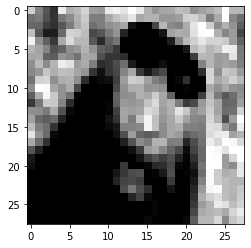

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(loader)
images, labels = dataiter.next()
image = images[0]
label = labels[0]

# show images
imshow(torchvision.utils.make_grid(image))

# Without taking into account uncertainty : False answer

In [0]:
correct = 0
total = 0
values = [] #value to input of the claasifier
labels_v = [] #label 0 or 1
labelss = [] #the class of the image
stacks = [] #all the output of the 100 NN for each images
for j, data in tqdm(enumerate(loader)):
    images, labels = data
    labels[0] = labels[0]+12
    percent,means,var,stack = predict2(images.view(-1,28*28),100)
    for i in range(len(means)):
      values.append((percent[i],means[i],var[i]))
      labelss.append(labels[i].item())
      stacks.append(stack[:,i,:])
      if means[i] != labels[i].item():
        print("false")
        print(percent[i],means[i],labels[i],var[i])
        labels_v.append(0) #false
      else:
        print("correct")
        print(percent[i],means[i],labels[i],var[i])
        correct = correct +1
        labels_v.append(1)
      total = total + 1
print("ratio: ",correct/total)
  







0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)






1it [00:06,  6.16s/it]







false
0.34 tensor(7) tensor(13) 0.22440000000000004
ratio:  0.0


# Taking uncertainty into account : Prefer not answer

In [0]:
pred = reg.predict(values)

In [0]:
count = 0
n_answer = 0
n_unanswer = 0
n_unanswer_false = 0
n_answer_false = 0
n_answer_true = 0
n_unanswer_true = 0
for i in range(len(values)):
  if pred[i] == 1:
    n_answer = n_answer + 1
    if values[i][1].item() == labels_test[i]:
      n_answer_true = n_answer_true +1
    else:
      n_answer_false = n_answer_false +1
  else:
    n_unanswer = n_unanswer + 1
    if values[i][1].item() == labels_test[i]:
      n_unanswer_false = n_unanswer_false +1
    else:
      n_unanswer_true = n_unanswer_true +1


In [0]:
print("nombre de réponses: ",n_answer)
print("nombre de bonnes réponses: ",n_answer_true)
print("nombre de mauvaises réponses: ",n_answer_false)

nombre de réponses:  0
nombre de bonnes réponses:  0
nombre de mauvaises réponses:  0


In [0]:
print("nombre de réponses évités: ",n_unanswer)
print("nombre de réponses évitées à raison: ",n_unanswer_true)
print("nombre de réponses évitées à tord: ",n_unanswer_false)

nombre de réponses évités:  1
nombre de réponses évitées à raison:  1
nombre de réponses évitées à tord:  0


# Plot the uncertainty for a MNIST image wrt the number of model generated 

In [0]:
num_samples = [i for i in range(101)]
def predict3(x,num_samples): #pour une image
    sampled_models = [guide(None, None) for _ in range(num_samples[-1])]  #on tire plusieurs variables 10 fois pour chaque layer
    yhats = [model(x).data for model in sampled_models] #Pour chacun de ces models
    liste = []
    for i in num_samples:
      y = torch.stack(yhats)[:i,:,:]
      mean = torch.mean(y, 0) #on calcul la moyenne de ses yhats
      percent,means,var = variance(y,mean)
      liste.append((percent,means,var))
    return liste

In [0]:
correct = 0
total = 0
values = {i:[] for i in num_samples}#[] #value to input of the claasifier
labels_v = {i:[] for i in num_samples} #[] #label 0 or 1
labelss ={i:[] for i in num_samples} #[] #the class of the image
for j, data in tqdm(enumerate(test_loader)):
    images, labels = data
    liste = predict3(images.view(-1,28*28),num_samples)
    for n in range(len(num_samples)) :
      percent,means,var = liste[n]
      tmp_values = []
      tmp_labels_v = []
      tmp_labelss = []
      for i in range(len(means)):
        tmp_values.append((percent[i],means[i],var[i]))
        tmp_labelss.append(labels[i].item())
        if means[i] != labels[i].item():
          tmp_labels_v.append(0) #false
        else:
          correct = correct +1
          tmp_labels_v.append(1)
        total = total + 1
      values[num_samples[n]].append(tmp_values)
      labels_v[num_samples[n]].append(tmp_labels_v)
      labelss[num_samples[n]].append(tmp_labelss)
      
    break


  

















0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [0]:
idx= 0
for i in range(len(labels_v[10][0])):
  if labels_v[2][0][i] == 0 and values[490][0][i][2]<0.15 :
    idx = i
    break

In [0]:
lab_time = [] #la réponse true ou false en fonction du temps
true_lab = [] # la classe
time_percent = [] #percent,mean,var en fonction du temps
time_mean = []
time_var = []
for i in num_samples: 
  lab_time.append(labels_v[i][0][idx])
  true_lab.append(labelss[i][0][idx])
  percent,mean,var = values[i][0][idx]
  time_mean.append(mean)
  time_percent.append(percent)
  time_var.append(var)


In [0]:
import matplotlib.pyplot as plt

In [0]:
good_pred = (np.array(time_mean) == true_lab)[:100]
false_idx = []
true_idx = []
for i in range(good_pred.shape[0]):
  if good_pred[i] == False:
    false_idx.append(i)
  else:
    true_idx.append(i)

false_idx.append(false_idx[-1]+1)

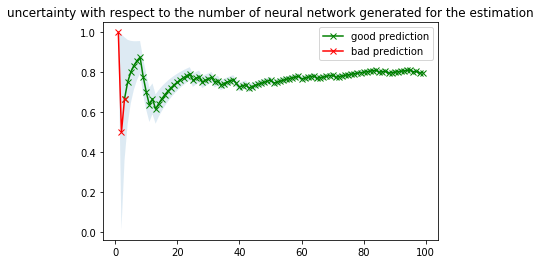

In [0]:
plt.plot(np.array(num_samples)[true_idx],np.array(time_percent)[true_idx],'H-',marker = "x",color = "green",label = "good prediction")
plt.plot(np.array(num_samples)[false_idx],np.array(time_percent)[false_idx],'H-',marker = "x",color = "red",label = "bad prediction")
plt.fill_between(np.array(num_samples[1:100]), np.array(time_percent[1:100]) - (1.96*np.array(time_var[1:100])**0.5)/np.array(num_samples[1:100]),np.array(time_percent[1:100]) + (1.96*np.array(time_var[1:100])**0.5)/np.array(num_samples[1:100]), alpha=0.15)
plt.title("uncertainty with respect to the number of neural network generated for the estimation")
plt.legend()

# We take uncertainty into account uncertainty for the monkey image

In [0]:
correct = 0
total = 0
values = {i:[] for i in num_samples}#[] #value to input of the claasifier
labels_v = {i:[] for i in num_samples} #[] #label 0 or 1
labelss ={i:[] for i in num_samples} #[] #the class of the image
for j, data in tqdm(enumerate(loader)):
    images, labels = data
    labels = labels + 12
    liste = predict3(images.view(-1,28*28),num_samples)
    for n in range(len(num_samples)) :
      percent,means,var = liste[n]
      tmp_values = []
      tmp_labels_v = []
      tmp_labelss = []
      for i in range(len(means)):
        tmp_values.append((percent[i],means[i],var[i]))
        tmp_labelss.append(labels[i].item())
        if means[i] != labels[i].item():
          tmp_labels_v.append(0) #false
        else:
          correct = correct +1
          tmp_labels_v.append(1)
        total = total + 1
      values[num_samples[n]].append(tmp_values)
      labels_v[num_samples[n]].append(tmp_labels_v)
      labelss[num_samples[n]].append(tmp_labelss)
      
    break





















0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [0]:
idx = 0

In [0]:
lab_time = [] #la réponse true ou false en fonction du temps liste de taille 500
true_lab = [] # la classe
time_percent = [] #percent,mean,var en fonction du temps
time_mean = []
time_var = []
for i in num_samples: 
  lab_time.append(labels_v[i][0][idx])
  true_lab.append(labelss[i][0][idx])
  percent,mean,var = values[i][0][idx]
  time_mean.append(mean)
  time_percent.append(percent)
  time_var.append(var)

In [0]:
x = []
label = []
for i in num_samples[1:]:
  x.append((time_percent[i],time_mean[i],time_var[i]))
  label.append(lab_time[i])

In [0]:
pred = [0]+list(reg.predict(x))

In [0]:
good_pred = (np.array(time_mean) == true_lab)[:100]
false_idx = []
true_idx = []
no_idx = []
for i in range(good_pred.shape[0]):
  if pred[i] == 1:
    no_idx.append(i)
  elif good_pred[i] == False:
    false_idx.append(i)
  else:
    true_idx.append(i)

false_idx.append(false_idx[-1]+1)

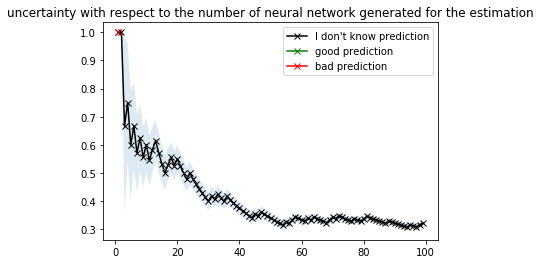

In [0]:
plt.plot(np.array(num_samples)[no_idx],np.array(time_percent)[no_idx],'H-',marker = "x",color = "black",label = "I don't know prediction")
plt.plot(np.array(num_samples)[true_idx],np.array(time_percent)[true_idx],'H-',marker = "x",color = "green",label = "good prediction")
plt.plot(np.array(num_samples)[false_idx],np.array(time_percent)[false_idx],'H-',marker = "x",color = "red",label = "bad prediction")
plt.fill_between(np.array(num_samples[1:100]), np.array(time_percent[1:100]) - (1.96*np.array(time_var[1:100])**0.5)/np.array(num_samples[1:100]),np.array(time_percent[1:100]) + (1.96*np.array(time_var[1:100])**0.5)/np.array(num_samples[1:100]), alpha=0.15)
plt.title("uncertainty with respect to the number of neural network generated for the estimation")
plt.legend()
  


# Same image but we don't take into account uncertainty

In [0]:
good_pred = (np.array(time_mean) == true_lab)[:100]
false_idx = []
true_idx = []
no_idx = []
for i in range(good_pred.shape[0]):
  if good_pred[i] == False:
    false_idx.append(i)
  else:
    true_idx.append(i)

false_idx.append(false_idx[-1]+1)

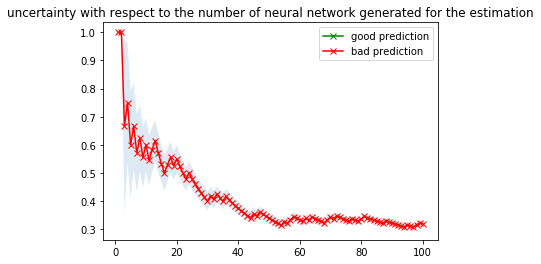

In [0]:
plt.plot(np.array(num_samples)[true_idx],np.array(time_percent)[true_idx],'H-',marker = "x",color = "green",label = "good prediction")
plt.plot(np.array(num_samples)[false_idx],np.array(time_percent)[false_idx],'H-',marker = "x",color = "red",label = "bad prediction")
plt.fill_between(np.array(num_samples[1:100]), np.array(time_percent[1:100]) - (1.96*np.array(time_var[1:100])**0.5)/np.array(num_samples[1:100]),np.array(time_percent[1:100]) + (1.96*np.array(time_var[1:100])**0.5)/np.array(num_samples[1:100]), alpha=0.15)
plt.title("uncertainty with respect to the number of neural network generated for the estimation")
plt.legend()